# Module Graphics
This Notebook is for developing the graphics for individual modules, showing our rating of their risk to ChatGPT and summarising their assessment types. It also demonstrates exactly how their rating was generated.

## Imports
Here is code we will need, either importing packages or input files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json
import matplotlib.ticker as mtick
import plotly.express as px
from fpdf import FPDF 
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

The below function handles files that were saved by the Module Scraper Code. It is a helper function that we use to access these files in other functions.

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    #assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    assessments["Assessment Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)
    #Return the desired assessment and description information
    return assessments, descriptors

Just to check that its working, we will print out the information for the entire college of Engineering and Architecture.

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Module Title,Stage,Student Credits,Assessment Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,74.0,2.00
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,968.5,3.25
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,1,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,149.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,14.00
1272,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,2.00
1273,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,6.00
1274,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,3.00


## Graphing Tools

Below is a python dictionary that associates each assessment type with a susceptibility to ChatGPT value. These can easily be changed or updated as this project progresses.


In [4]:
susceptibility={"Assignment" :5, \
                "Attendance": 0, \
                "Class Test" : 0, \
                "Continuous Assessment": 5, \
               "Essay": 5, \
                "Examination": 0, \
                "Fieldwork": 0, \
                "Group Project": 3, \
                "Journal": 3,\
               "Lab Report": 2, \
                "Multiple Choice Questionnaire": 2, \
                "Oral Examination": 0, \
               "Portfolio" : 2.5,  \
                "Practical Examination": 0, \
                "Presentation" : 0, \
                "Project": 5, \
               "Seminar": 0, \
               "Studio Examination" : 0,\
                   "Assessments worth <2%": None}

In [5]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

Next we will add in the susceptibility rating for each assignment.

In [6]:
assessments["Exposure Estimate"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])*(assessments["% of Final Grade"]/100)

print(assessments["Exposure Estimate"].isna().sum())

assessments

0


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,...,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Module Title,Stage,Student Credits,Assessment Credits,Exposure Estimate
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50,0.0
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50,0.0
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,74.0,2.00,0.8
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,...,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,968.5,3.25,0.0
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,...,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,149.0,0.50,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,...,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,14.00,3.5
1272,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,...,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,2.00,0.5
1273,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,...,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,6.00,1.0
1274,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,...,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,3.00,0.5


Below is a function designed to build charts for a given module set. It identifies which of those modules are using assessment types that are susceptible to ChatGPT and what percentage such assessments are of the overall assessment type. It also publishes below a bar chart that shows the breakdown of assessment types.


In [7]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def workType_builder(assessments, scaled=True, school=None, level=None, givenList=None, filename=None, \
                     module=None, time=False, student_credits=False, with_internships=True):
    
    num_unique=len(assessments["Module Code"].unique())
    #Data Cleaning and Manipulation Part
    #########################################################################################
    #First we will reduce the assessments dataframe to just the columns we require here.
    if with_internships != True:
        Datasets=Path.Path("Datasets")
        internship_file= Datasets / "UCD_EngArch_InternshipModules.xlsx"
        internships=pd.read_excel(internship_file)

        new_assessments=assessments[~assessments["Module Code"].isin(internships["Code"])]
    else:
        new_assessments=assessments
    
    #For the pie chart, group by susceptibilty
    assessment_sus=new_assessments.groupby(by="Work Type").sum()
    #For the bar chart, group by assessment type
    assessment_total=new_assessments.groupby("Assessment Type").sum()

    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage each assessment type makes up of the overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)

    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    assessment_total["Work Type"]=assessment_total.index.map(lambda x: work_type[x])

    #Sort the totals into descending order, to make it easier to see
    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)
    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    sorted_totals["Work Type"]=sorted_totals.index.map(lambda x: work_type[x])

    #Graph building part
    #############################################################################################################
    #Set the font
    plt.rcParams["font.family"] = "sans"
    
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))

    #Make a pie chart on the desired axes
    if time == False:
        fig, ax=workType_pie(assessment_sus, fig, ax, num_unique)
    else:
        stage=False
        if filename != None:
            stage=True
        #Make the area level stacked chart
        fig, ax=workType_stackedBar(new_assessments, fig, ax, stage=stage, student_credits=student_credits)
        
    #Make the horizontal bar chart on the desired axes
    fig, bx=workType_barh(sorted_totals, fig, bx)
    
    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="the College of Engineering and Architecture"
    if school != None:
        what=""
        what+="the School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
    if filename != None:
        what="the ".join([(" "+i if i.isupper() else i) for i in filename])
    if module != None:
        what = module 
    if not with_internships:
        what = what + " Excluding Internships"

        
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Breakdown in %s" %what, fontsize=24)
    fig.tight_layout()
    
    if not time: 
        what = what + " Snapshot"
    
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "WorkType"
    if module != None:
        dir_output=dir_output / "Modules"
        what=module
        
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.png" %what)
    plt.savefig(filename, dpi="figure")
    
    plt.close()

This is a function that builds a pie chart as desired, breaking down model assessment by work type.

In [8]:
def workType_pie(assessment_sus, fig, ax, num_unique=None):
        #These are for selecting colours and hatching for each pie segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        hatching.append(hatching_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(assessment_sus["% of Assessment"],\
           wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9}, \
           autopct="%1.1f%%", labels=assessment_sus.index, hatch=hatching ,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Assessment Kinds", fontsize=20)
    
    if num_unique!=None:
        ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

This is a function that creates a horizontal bar chart, break down the assessments by assessment types.

In [9]:
def workType_barh(sorted_totals, fig, bx):
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals["Work Type"]:
        colours.append(colour_dict[sus])
        hatching.append(hatching_dict[sus])
        
    
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals["% of Assessment"].apply(lambda x:x*100), edgecolor="white", hatch = hatching ,\
           color=colours, alpha=0.9)
    
    #colors = {'fruit':'red', 'veggie':'green'}         
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=16)
    
    fmt = '%d%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    bx.xaxis.set_major_formatter(xticks)
    #ax.legend(fontsize=20)
    bx.set_xlabel("Percentage of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Breakdown", fontsize=20)
    
    #Do the legend
    labels = list(colour_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colour_dict[label]) for label in labels]
    bx.legend(handles, labels,fontsize=20)
    
    return fig, bx

In [10]:
def workType_levelArea(assessments, fig, ax, scaled=True, stage=False, student_credits=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    stackedbar=assessments[""]

    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
        colours.append(colour_dict[segment])
        #hatching.append(hatching_dict[segment])
    
    ax.stackplot(assessments["Level"].unique().tolist(), Stackedwork["At home"]/Totalwork,  Stackedwork["Blended"]/Totalwork, \
                  Stackedwork["In person"]/Totalwork, colors=colours, labels=["At home", "Blended", "In person"])
    
        #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    #ax.legend(fontsize=20)
    ax.set_ylabel("Proportion of Assessment",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    ax.legend(fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

In [11]:
def workType_stackedBar(assessments, fig, ax, stage=False, student_credits=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    else:
        assessment_scale="Assessment Credits"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    #assessments[time]=assessments[time].apply(lambda x: "%d" %x)
    categories=np.array(assessments[time].unique())
    print(categories)
    assessments[time]=pd.Categorical(assessments[time], categories=categories, ordered=True)
    stackedbar=assessments.groupby(by=["Work Type", time], as_index=False).sum()
    
    #stackedbar=stackedbar.fillna("0")
    #print(stackedbar)
    
    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        #print(Stackedwork[segment])
        #try:
        #    if (Stackedwork[segment].empty):
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    else:
        #        Stackedwork[segment].fillna(0)
        #except:
        #    if Stackedwork[segment] == None:
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    elif None in Stacked[segement]:
        #        index=Stacked[segement].index(None)
        #        Stacked[segement][index]=0
                                      
        #Make sure there is no difference between the x value and the y
        #diff=len(Stackedwork[segment])-len(assessments[time].unique().tolist())
        #for i in range(diff):
        #    print("Here")
        #    Stackedwork[segment][len(Stackedwork[segment])+1]=0.0
            
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
                                         
                                         
    #print(Totalwork)
    #If any work type are not included in the stacked bar, add in a value for that segment of 0
    for work in ["At home", "Blended", "In person"]: 
        if work not in Stackedwork.keys():
                Stackedwork[work]=np.zeros(len(assessments[time].unique().tolist()))

            
 
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
        (Stackedwork["At home"]), color=colour_dict["At home"])
        
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["Blended"]), \
           bottom=(Stackedwork["At home"]), color=colour_dict["Blended"])
    
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["In person"]), \
           bottom=(Stackedwork["Blended"])+(Stackedwork["At home"]), color=colour_dict["In person"])

    # Add percentages as labels to the stacked bars
    for idx in assessments[time].unique().tolist():
        start = 0
        for work in ["At home", "Blended", "In person"]:
            y=Stackedwork[work][idx-1]
            value = Stackedwork[work][idx-1]
            total = Totalwork[idx-1]
            if  y/max(Totalwork)> .05 :
                ax.text(
                x=idx-1,
                y=start + y / 2,
                s=f"{round(100 * value / total, 1)}%",
                fontsize=16,
                ha="center"
                )
            start += y
            
    #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    #ax.legend(fontsize=20)
    ax.set_ylabel("Taught Student Credits",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    #ax.legend(["At home", "Hybrid", "In person"],fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

By combining the "worktypebuilder" function with the "file_finder" function, we have a function that can build graphs immediately after finding the files. This makes it very easy for us going forward.

In [12]:
#This finds files and then builds graphs based on their content
def workType_graphs(school=None, level=None, givenList=None, scaled=True, filename=None, module=None, time=False, \
                   student_credits=False, with_internships=True):
    #Find the desired module subset in the files
    assessments, descriptors = file_finder(school=school, level=level, givenList=givenList, filename=filename, module=module)
    
    #Build a graph describing these module subsets
    workType_builder(assessments, scaled=scaled, school=school, level=level,\
                     givenList=givenList, filename=filename, module=module, time=time, student_credits=student_credits, \
                    with_internships=with_internships)

We will want to go through every module in the college, so we will need a module list.

In [13]:
modules=assessments.sort_values(["School", "Level"])["Module Code"].unique()

print(modules)

['ARCT10010' 'ARCT10020' 'ARCT10030' 'ARCT10040' 'ARCT10070' 'ARCT10090'
 'ARCT10120' 'ENVP10010' 'ENVP10030' 'LARC10050' 'LARC10090' 'LARC10100'
 'LARC10110' 'LARC10120' 'PLAN10010' 'PLAN10020' 'PLAN10030' 'PLAN10040'
 'PLAN10080' 'PLAN10090' 'ARCT20010' 'ARCT20020' 'ARCT20040' 'ARCT20050'
 'ARCT20100' 'ARCT20130' 'ARCT20170' 'ARCT20570' 'ENVP20020' 'LARC20150'
 'LARC20160' 'LARC20170' 'PLAN20010' 'PLAN20020' 'PLAN20030' 'PLAN20040'
 'PLAN20070' 'PLAN20080' 'PLAN20090' 'ARCT30010' 'ARCT30030' 'ARCT30040'
 'ARCT30090' 'ARCT30100' 'ARCT30130' 'ENVP30010' 'ENVP30030' 'LARC30120'
 'LARC30140' 'LARC30150' 'LARC30170' 'LARC30220' 'LARC30230' 'PLAN30010'
 'PLAN30020' 'PLAN30030' 'PLAN30040' 'PLAN30060' 'PLAN30080' 'PLAN30150'
 'ARCT40010' 'ARCT40020' 'ARCT40030' 'ARCT40050' 'ARCT40080' 'ARCT40090'
 'ARCT40100' 'ARCT40110' 'ARCT40130' 'ARCT40140' 'ARCT40170' 'ARCT40180'
 'ARCT40190' 'ARCT40260' 'ARCT40520' 'ARCT40610' 'ARCT40660' 'ARCT40680'
 'ARCT40690' 'ARCT40760' 'ARCT40770' 'ARCT40780' 'A

In [14]:
assessments["School"].unique()

array(['Electrical & Electronic Eng', 'Civil Engineering',
       'Chem & Bioprocess Engineering', 'Biosystems & Food Engineering',
       'Architecture, Plan & Env Pol', 'Mechanical & Materials Eng'],
      dtype=object)

In [15]:
module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
.groupby(by="Module Code").first()

print(module_details[module_details["School"]=='Chem & Bioprocess Engineering'])

             Enrolled Students 22/23                         School  \
Module Code                                                           
CHEN10010                         63  Chem & Bioprocess Engineering   
CHEN10040                        300  Chem & Bioprocess Engineering   
CHEN20020                         36  Chem & Bioprocess Engineering   
CHEN20030                         44  Chem & Bioprocess Engineering   
CHEN20050                         36  Chem & Bioprocess Engineering   
...                              ...                            ...   
CHEN40770                         20  Chem & Bioprocess Engineering   
CHEN40790                         31  Chem & Bioprocess Engineering   
CHEN40810                          7  Chem & Bioprocess Engineering   
CHEN50050                          4  Chem & Bioprocess Engineering   
CHEN50060                          1  Chem & Bioprocess Engineering   

             Student Credits  Credits  Level                    Module Title

Now we will loop through the module codes and create an assessment type breakdown visualisation for each

In [16]:
def risk_colour(module, rating):
    #We will create two subplots and a figure to show the ratings
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 5))
    plt.rcParams["font.family"] = "sans"

    #We will set the colourmap we will use for the ratings
    cmaps = plt.cm.RdYlGn_r

    #Fill a box on the left with the rating colour, and annotate with the rating number
    #ax.imshow( cmaps(rating/5))

    #create rectangle with the rating
    rectangle = Rectangle((0, 0), 0.5, 0.6, edgecolor='black',
    facecolor=cmaps(rating/5), linewidth=2, fill=True)
    ax.add_patch(rectangle)

    #Annotate with the rating number
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    #add rectangle to plot
    ax.annotate("%.2f" %rating, (cx, cy), color='black', weight='bold', fontsize=36, ha='center', va='center')
    #Hide the axis
    ax.axis("off")
    
    risk=""
    if rating  < 1.5:
        risk = "Low"
        #"Low means that there is a low level of at-home or blended assessments, meaning 
        #little risk of significant LLM-facilitated cheating in this module."
    elif rating < 3.5:
        risk= "Moderate"
        #"Moderate means there is a number of at home and blended assessments, which means "
        #that somewhat significant LLM-facilitated cheating could occur in this module.
    else:
        risk="High"
        #"High means there is a large amount of at home and blended assessments, meaning"
        #that seriously significant LLM-facilitated cheating could occur in this module.
        
    risk_description={"Low":"Low means that there is a low level of at-home\n or blended assessments, which we designated as\n little risk of significant LLM-facilitated cheating in this module.",
                     "Moderate":"Moderate means there is a number of at home\n and blended assessments, which we designated could\n lead to somewhat significant LLM-facilitated cheating in this module.",
                     "High": "High means there is a large amount of at home\n and blended assessments, which we designated could\n allow seriously significant LLM-facilitated cheating in this module."}
    
    ax.text(x=0.05, y=0.70, s=risk_description[risk], fontsize=22)
    
    # create dummy invisible image for the colourbar
    img = bx.imshow(np.array([[0,5]]), cmap=cmaps)
    img.set_visible(False)

    #Set the limits of the x axis to be 0 and 5
    bx.set_xlim(0, 5)

    #Draw the arrow on the axis where desired 
    bx.arrow(x=rating, y=0.2, dx=0, dy=1, head_width=0.4, width=0.2, shape='full', color='black', clip_on=False)

    # create an axes on the right side of ax. The width of cax will be 40%
    # of ax and the padding between cax and ax will be fixed at 0 inch.
    divider = make_axes_locatable(bx)
    cax = divider.append_axes("bottom", size="40%", pad=0)

    #Create the colour bar and set the label size
    cb=plt.colorbar(img, orientation="horizontal", cax=cax, fraction=.5, shrink=1, aspect=3, pad=0)
    cb.ax.tick_params(labelsize=16) 
    #Hide the axis
    bx.axis("off")
    #bx.set_title("Risk Range")

    fig.suptitle("Exposure Estimate : %.2f - %s" %(rating, risk), fontsize=36)
    fig.tight_layout()
    #The functionality to save the risk assessment graphics
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment"
    if module != None:
        dir_output=dir_output / "Modules"
        what=module
        
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.png" %m)
    plt.savefig(filename, dpi=300)
    
    plt.close()

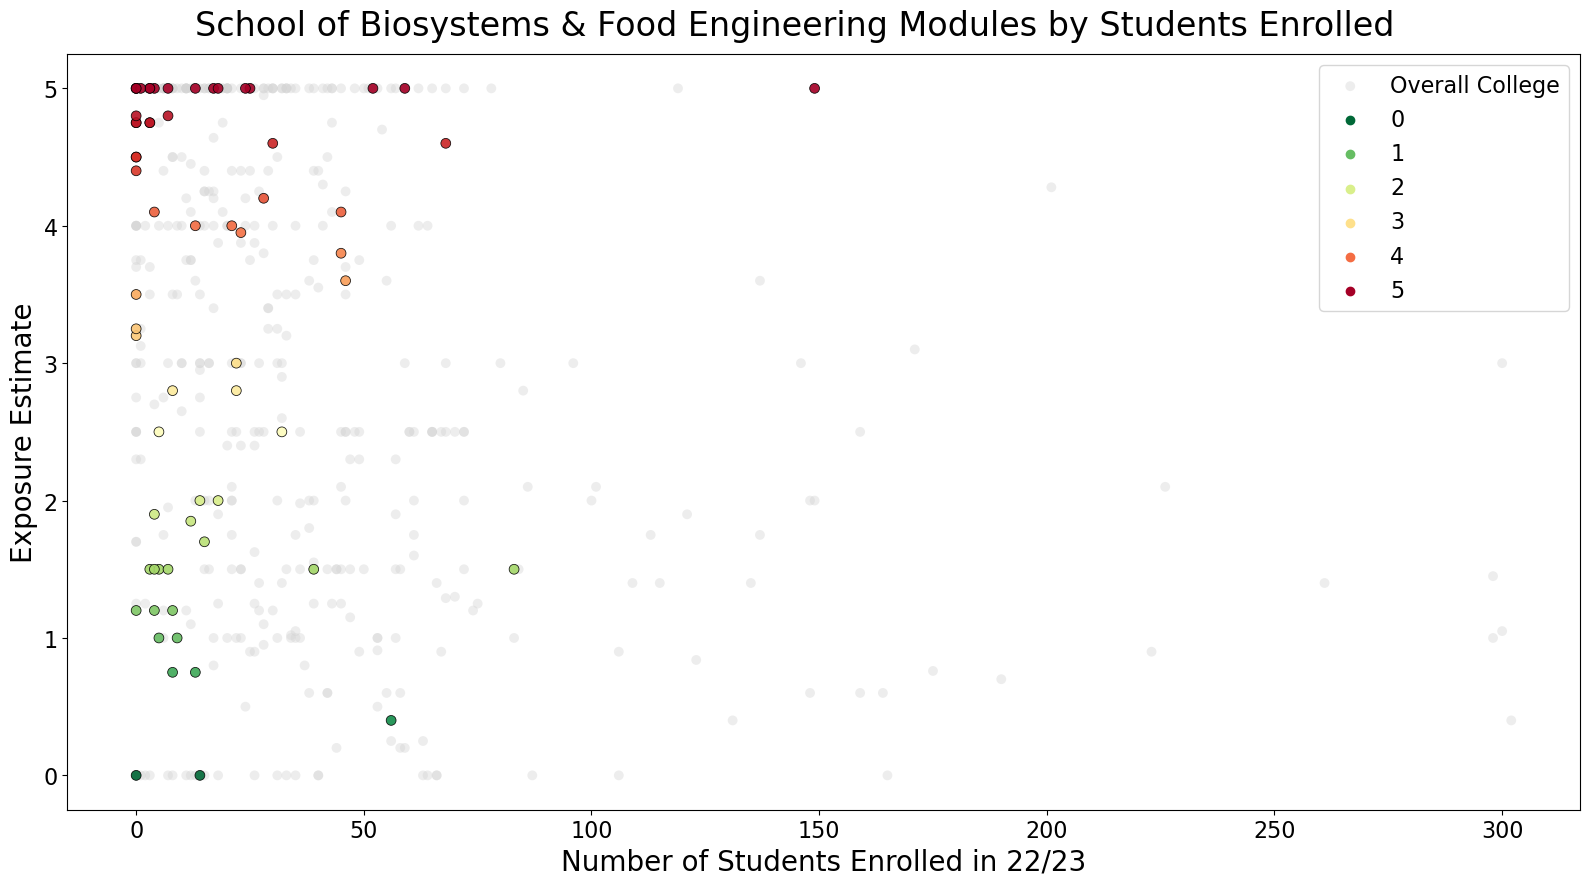

In [17]:
def school_scatter(school):
        #Data Manipulation to get the module details, with one row per module
    module_risk=assessments[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
    module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
    .groupby(by="Module Code").first()

    stored_modules=module_risk.join(module_details)
    
    school_modules=stored_modules[stored_modules["School"]==school]
    #print(stored_modules["School"])

    #Graph for the school versus college distribution
    fig, ax=plt.subplots(figsize=(16, 9))

    sns.scatterplot(data=stored_modules, x="Enrolled Students 22/23", y="Exposure Estimate",\
                    color="lightgrey", s=50, edgecolor="none", alpha=0.4, label="Overall College")
    
    sns.scatterplot(data=school_modules, x="Enrolled Students 22/23", y="Exposure Estimate",\
                hue="Exposure Estimate", palette=plt.cm.RdYlGn_r, s=50, edgecolor="black",\
                    alpha=0.9)
        
    
    
    #Set the title
    fig.suptitle("School of %s Modules by Students Enrolled" %school, fontsize=24)
    ax.legend(fontsize=16)
    #Format the Axes
    ax.set_ylabel("Exposure Estimate", fontsize=20)
    #ax.yticks(fontsize=16)
    ax.set_xlabel("Number of Students Enrolled in 22/23", fontsize=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    #ax.legend("off")
    fig.tight_layout()
    
    #Set the path to save the graphs
    dir_output=Path.Path("Slides")
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment" / ("%s" %school.replace(" ", "-")) 
    dir_output.mkdir(parents=True, exist_ok=True)
    filename= dir_output / ("Scatter.png")
    plt.savefig(filename, dpi=300)
    #print(filename)
    
    
school_scatter("Biosystems & Food Engineering")

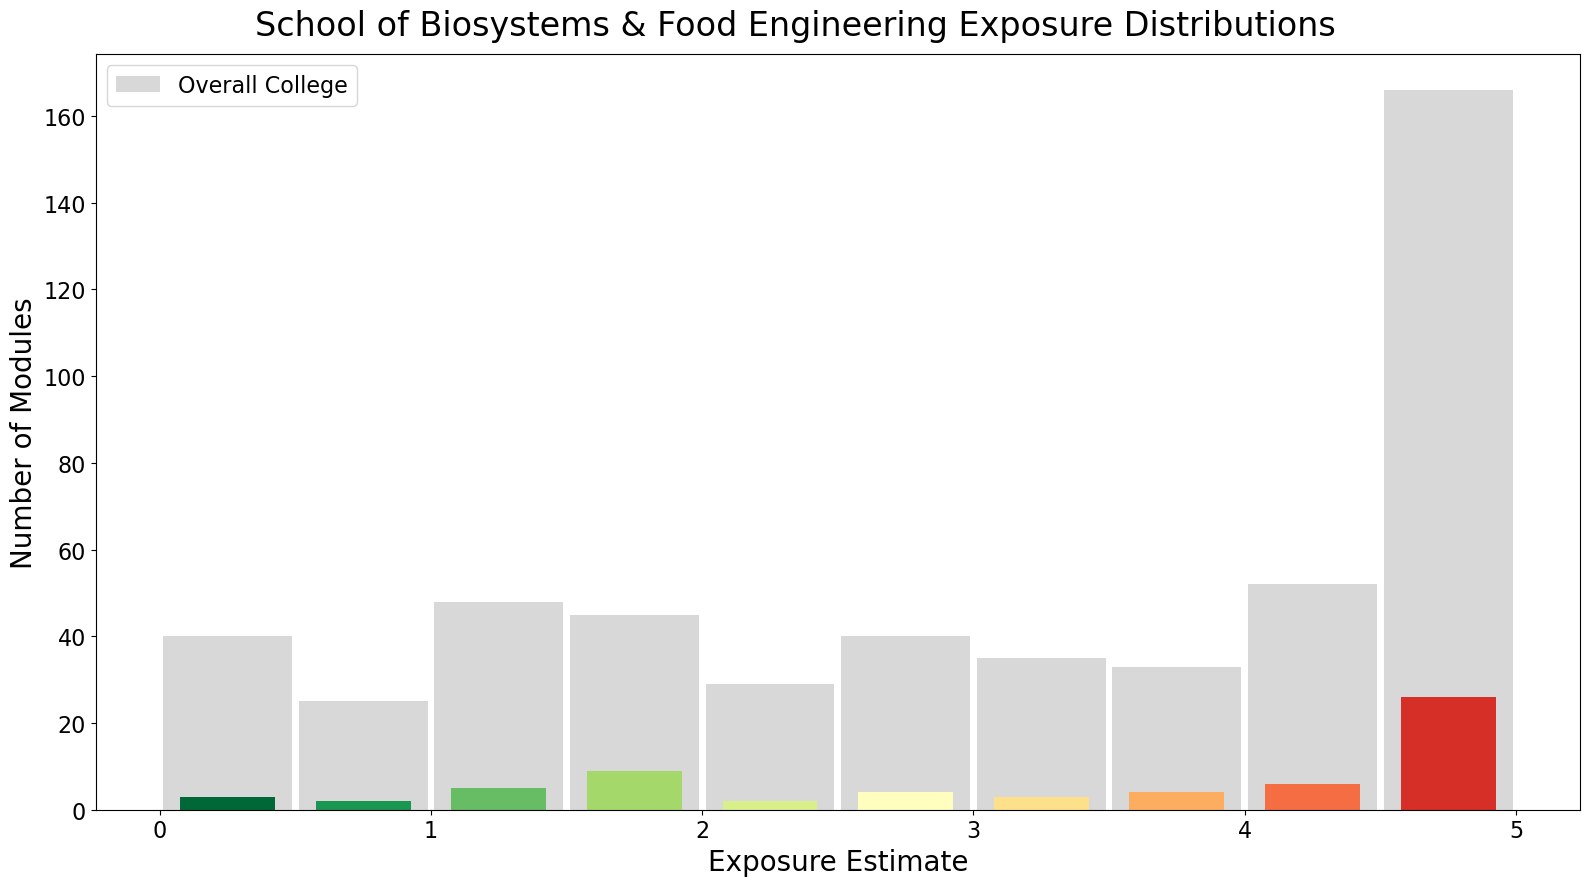

In [18]:
def school_dist(school):
    #Data Manipulation to get the module details, with one row per module
    module_risk=assessments[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
    module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
    .groupby(by="Module Code").first()

    stored_modules=module_risk.join(module_details)
    
    school_modules=stored_modules[stored_modules["School"]==school]

    #Graph for the school versus college distribution
    fig, ax=plt.subplots(figsize=(16, 9))

    
    sns.histplot(data=stored_modules, x="Exposure Estimate", \
             common_bins=True, ax=ax, color="Grey",  bins=10, alpha=0.3, shrink=0.95, edgecolor="none", label="Overall College")
    plot=sns.histplot(data=school_modules, x="Exposure Estimate", \
             common_bins=True, ax=ax,  bins=10, shrink=0.7, edgecolor="none")
    
    for i, bin_ in enumerate(plot.patches):
        if i > 9:
            bin_.set_facecolor(plt.cm.RdYlGn_r(((i-10)/2)/5))
        
    
    
    #Set the title
    fig.suptitle("School of %s Exposure Distributions" %school, fontsize=24)

    #Format the Axes
    ax.set_xlabel("Exposure Estimate", fontsize=20)
    #ax.yticks(fontsize=16)
    ax.set_ylabel("Number of Modules", fontsize=20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    ax.legend(fontsize=16)
    fig.tight_layout()
    
    #Set the path to save the graphs
    dir_output=Path.Path("Slides")
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment" / ("%s" %school.replace(" ", "-")) 
    dir_output.mkdir(parents=True, exist_ok=True)
    filename= dir_output / ("Distribution.png")
    plt.savefig(filename, dpi=300)
    
    
school_dist("Biosystems & Food Engineering")

C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Exposure Estimate Level"]=pd.Categorical(school_modules["Exposure Estimate Level"],\


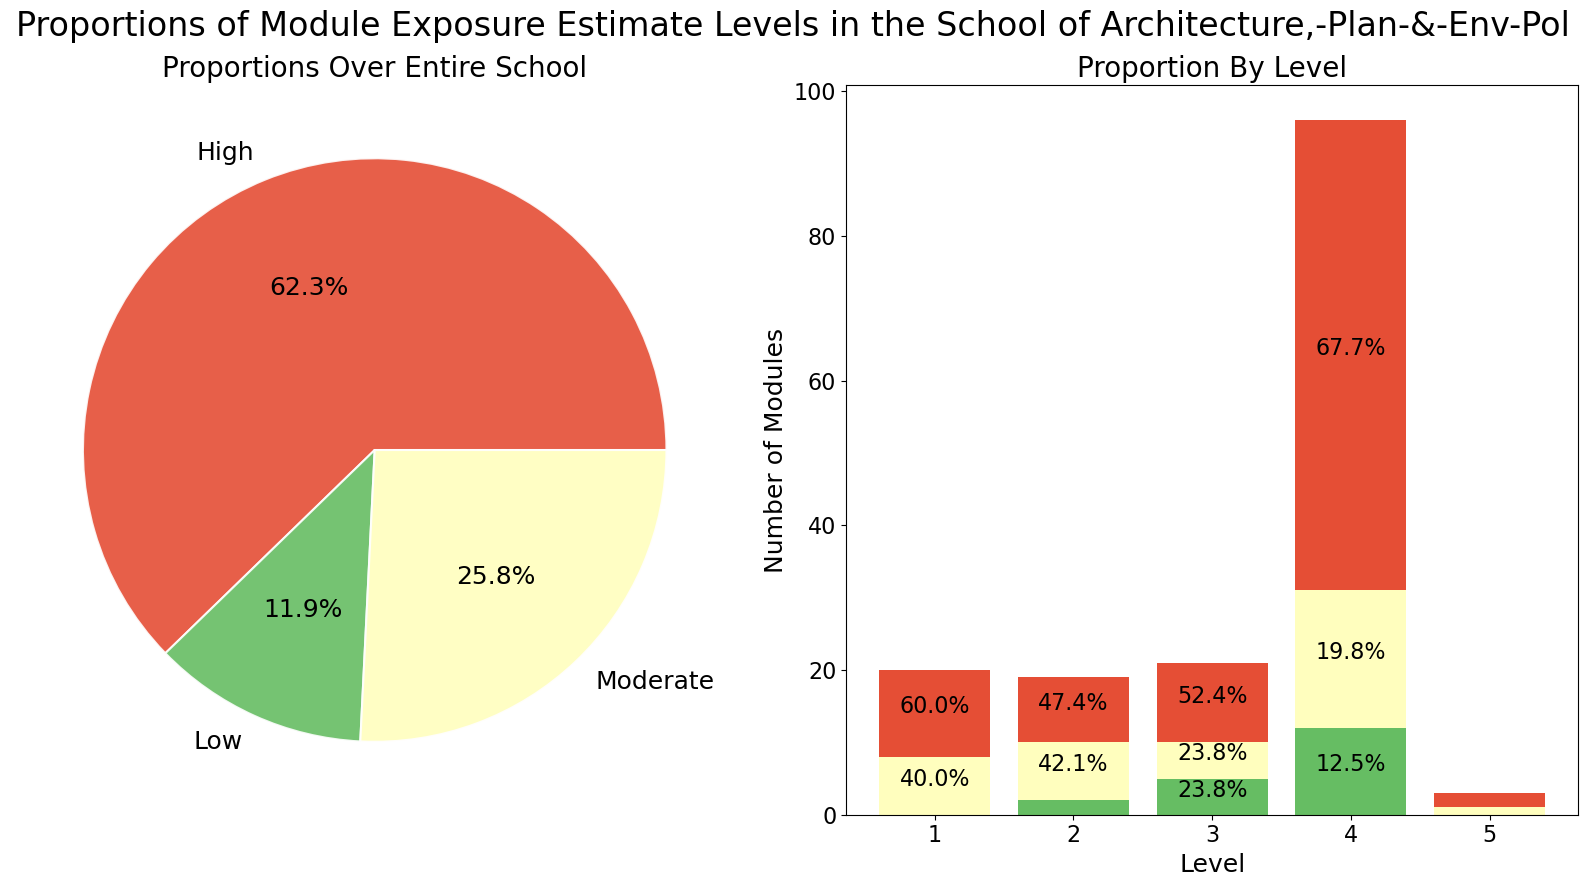

In [19]:
def school_proportions(school):
    #Data Manipulation to get the module details, with one row per module
    module_risk=assessments[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
    module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
    .groupby(by="Module Code").first()

    stored_modules=module_risk.join(module_details)
    
    #Set the dataset to show low, moderate and high risks
    stored_modules["Exposure Estimate Level"]=stored_modules["Exposure Estimate"].apply(lambda x: "Low" if x <1.5 else \
                                                                          "Moderate" if x <3.5 else "High")
    
    school_modules=stored_modules[stored_modules["School"]==school]
    
    school_sorted=school_modules.groupby("Exposure Estimate Level").count()

    #Graph for the school versus college distribution
    fig, (ax,bx) =plt.subplots(ncols=2, figsize=(16, 9))

    
    #These are for selecting colours and hatching for each pie segment
    colour_dict={"Low":plt.cm.RdYlGn_r(1/5), "Moderate": plt.cm.RdYlGn_r(2.5/5), "High": plt.cm.RdYlGn_r(4.25/5)}
    colours=[]
    #Get the colours and hatching for each pie segment
    for segment in school_sorted.index:
        colours.append(colour_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(school_sorted["Module Title"], labels=school_sorted.index, colors = colours,\
           wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9},\
           autopct='%.1f%%', textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    
    ax.set_title("Proportions Over Entire School", fontsize=20)
    #if num_unique!=None:
    #    ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
                                            ordered=True)
    school_modules["Exposure Estimate Level"]=pd.Categorical(school_modules["Exposure Estimate Level"],\
                                                             categories=np.array(school_modules["Exposure Estimate Level"].unique()),\
                                            ordered=True)
    school_levels=school_modules.groupby(["Exposure Estimate Level", "Level"], as_index=False).count()
    
    Stackedlevels={}
    
     #Get the colours for each area segment
    for i, segment in enumerate(school_levels["Exposure Estimate Level"].unique().tolist()):
        Stackedlevels[segment]=school_levels[school_levels["Exposure Estimate Level"]\
                                             == segment]["Module Title"].reset_index(drop=True)
 
        if i ==0:
            Totallevels=Stackedlevels[segment]
        else:
            Totallevels=Totallevels+Stackedlevels[segment]
    
    bx.bar(["{}".format(level) for level in school_levels["Level"].unique().tolist()],\
        (Stackedlevels["Low"].tolist()), color=colour_dict["Low"])
        
    bx.bar(["{}".format(level) for level in  school_levels["Level"].unique().tolist()],\
           (Stackedlevels["Moderate"].tolist()), \
           bottom=(Stackedlevels["Low"].tolist()), color=colour_dict["Moderate"])
    
    bx.bar(["{}".format(level) for level in  school_levels["Level"].unique().tolist()],\
           Stackedlevels["High"].tolist(), \
           bottom=(Stackedlevels["Low"] + Stackedlevels["Moderate"]).tolist(),\
                   color=colour_dict["High"])
    
    # Add percentages as labels to the stacked bars
    for idx in school_levels["Level"].unique().tolist():
        start = 0
        for estimate in ["Low", "Moderate", "High"]:
            y=Stackedlevels[estimate][idx-1]
            value = Stackedlevels[estimate][idx-1]
            total = Totallevels[idx-1]
            if  y/max(Totallevels)> .05 :
                bx.text(
                x=idx-1,
                y=start + y / 2,
                s=f"{round(100 * value / total, 1)}%",
                fontsize=16,
                ha="center"
                )
            start += y
            
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=16)
    
    #ax.legend(fontsize=20)
    bx.set_ylabel("Number of Modules",fontsize=18)
    bx.set_xlabel("Level", fontsize=18)
    bx.set_title("Proportion By Level", fontsize=20)
    fig.suptitle("Proportions of Module Exposure Estimate Levels in the School of %s" %school.replace(" ", "-"), fontsize=24)
    fig.tight_layout()
    
    #Set the path to save the graphs
    dir_output=Path.Path("Slides")
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment" / ("%s" %school.replace(" ", "-")) 
    dir_output.mkdir(parents=True, exist_ok=True)
    filename= dir_output / ("Proportions.png")
    plt.savefig(filename, dpi=300)
    
school_proportions("Architecture, Plan & Env Pol")

ARCT10010
Reading from ModuleInformation\IndividualModules\ARCT10010
Reading from ModuleInformation\IndividualModules\ARCT10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

ARCT10020
Reading from ModuleInformation\IndividualModules\ARCT10020
Reading from ModuleInformation\IndividualModules\ARCT10020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT10030
Reading from ModuleInformation\IndividualModules\ARCT10030
Reading from ModuleInformation\IndividualModules\ARCT10030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT10040
Reading from ModuleInformation\IndividualModules\ARCT10040
Reading from ModuleInformation\IndividualModules\ARCT10040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT10070
Reading from ModuleInformation\IndividualModules\ARCT10070
Reading from ModuleInformation\IndividualModules\ARCT10070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT10090
Reading from ModuleInformation\IndividualModules\ARCT10090
Reading from ModuleInformation\IndividualModules\ARCT10090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT10120
Reading from ModuleInformation\IndividualModules\ARCT10120
Reading from ModuleInformation\IndividualModules\ARCT10120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP10010
Reading from ModuleInformation\IndividualModules\ENVP10010
Reading from ModuleInformation\IndividualModules\ENVP10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP10030
Reading from ModuleInformation\IndividualModules\ENVP10030
Reading from ModuleInformation\IndividualModules\ENVP10030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC10050
Reading from ModuleInformation\IndividualModules\LARC10050
Reading from ModuleInformation\IndividualModules\LARC10050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC10090
Reading from ModuleInformation\IndividualModules\LARC10090
Reading from ModuleInformation\IndividualModules\LARC10090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC10100
Reading from ModuleInformation\IndividualModules\LARC10100
Reading from ModuleInformation\IndividualModules\LARC10100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC10110
Reading from ModuleInformation\IndividualModules\LARC10110
Reading from ModuleInformation\IndividualModules\LARC10110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC10120
Reading from ModuleInformation\IndividualModules\LARC10120
Reading from ModuleInformation\IndividualModules\LARC10120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10010
Reading from ModuleInformation\IndividualModules\PLAN10010
Reading from ModuleInformation\IndividualModules\PLAN10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10020
Reading from ModuleInformation\IndividualModules\PLAN10020
Reading from ModuleInformation\IndividualModules\PLAN10020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10030
Reading from ModuleInformation\IndividualModules\PLAN10030
Reading from ModuleInformation\IndividualModules\PLAN10030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10040
Reading from ModuleInformation\IndividualModules\PLAN10040
Reading from ModuleInformation\IndividualModules\PLAN10040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10080
Reading from ModuleInformation\IndividualModules\PLAN10080
Reading from ModuleInformation\IndividualModules\PLAN10080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN10090
Reading from ModuleInformation\IndividualModules\PLAN10090
Reading from ModuleInformation\IndividualModules\PLAN10090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20010
Reading from ModuleInformation\IndividualModules\ARCT20010
Reading from ModuleInformation\IndividualModules\ARCT20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20020
Reading from ModuleInformation\IndividualModules\ARCT20020
Reading from ModuleInformation\IndividualModules\ARCT20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20040
Reading from ModuleInformation\IndividualModules\ARCT20040
Reading from ModuleInformation\IndividualModules\ARCT20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20050
Reading from ModuleInformation\IndividualModules\ARCT20050
Reading from ModuleInformation\IndividualModules\ARCT20050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20100
Reading from ModuleInformation\IndividualModules\ARCT20100
Reading from ModuleInformation\IndividualModules\ARCT20100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20130
Reading from ModuleInformation\IndividualModules\ARCT20130
Reading from ModuleInformation\IndividualModules\ARCT20130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20170
Reading from ModuleInformation\IndividualModules\ARCT20170
Reading from ModuleInformation\IndividualModules\ARCT20170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT20570
Reading from ModuleInformation\IndividualModules\ARCT20570
Reading from ModuleInformation\IndividualModules\ARCT20570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP20020
Reading from ModuleInformation\IndividualModules\ENVP20020
Reading from ModuleInformation\IndividualModules\ENVP20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC20150
Reading from ModuleInformation\IndividualModules\LARC20150
Reading from ModuleInformation\IndividualModules\LARC20150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC20160
Reading from ModuleInformation\IndividualModules\LARC20160
Reading from ModuleInformation\IndividualModules\LARC20160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC20170
Reading from ModuleInformation\IndividualModules\LARC20170
Reading from ModuleInformation\IndividualModules\LARC20170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20010
Reading from ModuleInformation\IndividualModules\PLAN20010
Reading from ModuleInformation\IndividualModules\PLAN20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20020
Reading from ModuleInformation\IndividualModules\PLAN20020
Reading from ModuleInformation\IndividualModules\PLAN20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20030
Reading from ModuleInformation\IndividualModules\PLAN20030
Reading from ModuleInformation\IndividualModules\PLAN20030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20040
Reading from ModuleInformation\IndividualModules\PLAN20040
Reading from ModuleInformation\IndividualModules\PLAN20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20070
Reading from ModuleInformation\IndividualModules\PLAN20070
Reading from ModuleInformation\IndividualModules\PLAN20070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20080
Reading from ModuleInformation\IndividualModules\PLAN20080
Reading from ModuleInformation\IndividualModules\PLAN20080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN20090
Reading from ModuleInformation\IndividualModules\PLAN20090
Reading from ModuleInformation\IndividualModules\PLAN20090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30010
Reading from ModuleInformation\IndividualModules\ARCT30010
Reading from ModuleInformation\IndividualModules\ARCT30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30030
Reading from ModuleInformation\IndividualModules\ARCT30030
Reading from ModuleInformation\IndividualModules\ARCT30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30040
Reading from ModuleInformation\IndividualModules\ARCT30040
Reading from ModuleInformation\IndividualModules\ARCT30040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30090
Reading from ModuleInformation\IndividualModules\ARCT30090
Reading from ModuleInformation\IndividualModules\ARCT30090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30100
Reading from ModuleInformation\IndividualModules\ARCT30100
Reading from ModuleInformation\IndividualModules\ARCT30100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT30130
Reading from ModuleInformation\IndividualModules\ARCT30130
Reading from ModuleInformation\IndividualModules\ARCT30130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP30010
Reading from ModuleInformation\IndividualModules\ENVP30010
Reading from ModuleInformation\IndividualModules\ENVP30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP30030
Reading from ModuleInformation\IndividualModules\ENVP30030
Reading from ModuleInformation\IndividualModules\ENVP30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30120
Reading from ModuleInformation\IndividualModules\LARC30120
Reading from ModuleInformation\IndividualModules\LARC30120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30140
Reading from ModuleInformation\IndividualModules\LARC30140
Reading from ModuleInformation\IndividualModules\LARC30140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30150
Reading from ModuleInformation\IndividualModules\LARC30150
Reading from ModuleInformation\IndividualModules\LARC30150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30170
Reading from ModuleInformation\IndividualModules\LARC30170
Reading from ModuleInformation\IndividualModules\LARC30170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30220
Reading from ModuleInformation\IndividualModules\LARC30220
Reading from ModuleInformation\IndividualModules\LARC30220


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC30230
Reading from ModuleInformation\IndividualModules\LARC30230
Reading from ModuleInformation\IndividualModules\LARC30230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30010
Reading from ModuleInformation\IndividualModules\PLAN30010
Reading from ModuleInformation\IndividualModules\PLAN30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30020
Reading from ModuleInformation\IndividualModules\PLAN30020
Reading from ModuleInformation\IndividualModules\PLAN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30030
Reading from ModuleInformation\IndividualModules\PLAN30030
Reading from ModuleInformation\IndividualModules\PLAN30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30040
Reading from ModuleInformation\IndividualModules\PLAN30040
Reading from ModuleInformation\IndividualModules\PLAN30040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30060
Reading from ModuleInformation\IndividualModules\PLAN30060
Reading from ModuleInformation\IndividualModules\PLAN30060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30080
Reading from ModuleInformation\IndividualModules\PLAN30080
Reading from ModuleInformation\IndividualModules\PLAN30080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN30150
Reading from ModuleInformation\IndividualModules\PLAN30150
Reading from ModuleInformation\IndividualModules\PLAN30150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40010
Reading from ModuleInformation\IndividualModules\ARCT40010
Reading from ModuleInformation\IndividualModules\ARCT40010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40020
Reading from ModuleInformation\IndividualModules\ARCT40020
Reading from ModuleInformation\IndividualModules\ARCT40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40030
Reading from ModuleInformation\IndividualModules\ARCT40030
Reading from ModuleInformation\IndividualModules\ARCT40030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40050
Reading from ModuleInformation\IndividualModules\ARCT40050
Reading from ModuleInformation\IndividualModules\ARCT40050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40080
Reading from ModuleInformation\IndividualModules\ARCT40080
Reading from ModuleInformation\IndividualModules\ARCT40080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40090
Reading from ModuleInformation\IndividualModules\ARCT40090
Reading from ModuleInformation\IndividualModules\ARCT40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40100
Reading from ModuleInformation\IndividualModules\ARCT40100
Reading from ModuleInformation\IndividualModules\ARCT40100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40110
Reading from ModuleInformation\IndividualModules\ARCT40110
Reading from ModuleInformation\IndividualModules\ARCT40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40130
Reading from ModuleInformation\IndividualModules\ARCT40130
Reading from ModuleInformation\IndividualModules\ARCT40130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40140
Reading from ModuleInformation\IndividualModules\ARCT40140
Reading from ModuleInformation\IndividualModules\ARCT40140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40170
Reading from ModuleInformation\IndividualModules\ARCT40170
Reading from ModuleInformation\IndividualModules\ARCT40170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40180
Reading from ModuleInformation\IndividualModules\ARCT40180
Reading from ModuleInformation\IndividualModules\ARCT40180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40190
Reading from ModuleInformation\IndividualModules\ARCT40190
Reading from ModuleInformation\IndividualModules\ARCT40190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40260
Reading from ModuleInformation\IndividualModules\ARCT40260
Reading from ModuleInformation\IndividualModules\ARCT40260


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40520
Reading from ModuleInformation\IndividualModules\ARCT40520
Reading from ModuleInformation\IndividualModules\ARCT40520


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40610
Reading from ModuleInformation\IndividualModules\ARCT40610
Reading from ModuleInformation\IndividualModules\ARCT40610


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40660
Reading from ModuleInformation\IndividualModules\ARCT40660
Reading from ModuleInformation\IndividualModules\ARCT40660


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40680
Reading from ModuleInformation\IndividualModules\ARCT40680
Reading from ModuleInformation\IndividualModules\ARCT40680


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40690
Reading from ModuleInformation\IndividualModules\ARCT40690
Reading from ModuleInformation\IndividualModules\ARCT40690


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40760
Reading from ModuleInformation\IndividualModules\ARCT40760
Reading from ModuleInformation\IndividualModules\ARCT40760


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40770
Reading from ModuleInformation\IndividualModules\ARCT40770
Reading from ModuleInformation\IndividualModules\ARCT40770


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40780
Reading from ModuleInformation\IndividualModules\ARCT40780
Reading from ModuleInformation\IndividualModules\ARCT40780


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40800
Reading from ModuleInformation\IndividualModules\ARCT40800
Reading from ModuleInformation\IndividualModules\ARCT40800


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40830
Reading from ModuleInformation\IndividualModules\ARCT40830
Reading from ModuleInformation\IndividualModules\ARCT40830


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40840
Reading from ModuleInformation\IndividualModules\ARCT40840
Reading from ModuleInformation\IndividualModules\ARCT40840


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40870
Reading from ModuleInformation\IndividualModules\ARCT40870
Reading from ModuleInformation\IndividualModules\ARCT40870


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40930
Reading from ModuleInformation\IndividualModules\ARCT40930
Reading from ModuleInformation\IndividualModules\ARCT40930


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT40970
Reading from ModuleInformation\IndividualModules\ARCT40970
Reading from ModuleInformation\IndividualModules\ARCT40970


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41010
Reading from ModuleInformation\IndividualModules\ARCT41010
Reading from ModuleInformation\IndividualModules\ARCT41010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41020
Reading from ModuleInformation\IndividualModules\ARCT41020
Reading from ModuleInformation\IndividualModules\ARCT41020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41100
Reading from ModuleInformation\IndividualModules\ARCT41100
Reading from ModuleInformation\IndividualModules\ARCT41100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41120
Reading from ModuleInformation\IndividualModules\ARCT41120
Reading from ModuleInformation\IndividualModules\ARCT41120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41130
Reading from ModuleInformation\IndividualModules\ARCT41130
Reading from ModuleInformation\IndividualModules\ARCT41130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41170
Reading from ModuleInformation\IndividualModules\ARCT41170
Reading from ModuleInformation\IndividualModules\ARCT41170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41180
Reading from ModuleInformation\IndividualModules\ARCT41180
Reading from ModuleInformation\IndividualModules\ARCT41180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41190
Reading from ModuleInformation\IndividualModules\ARCT41190
Reading from ModuleInformation\IndividualModules\ARCT41190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41210
Reading from ModuleInformation\IndividualModules\ARCT41210
Reading from ModuleInformation\IndividualModules\ARCT41210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41230
Reading from ModuleInformation\IndividualModules\ARCT41230
Reading from ModuleInformation\IndividualModules\ARCT41230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41240
Reading from ModuleInformation\IndividualModules\ARCT41240
Reading from ModuleInformation\IndividualModules\ARCT41240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41260
Reading from ModuleInformation\IndividualModules\ARCT41260
Reading from ModuleInformation\IndividualModules\ARCT41260


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41270
Reading from ModuleInformation\IndividualModules\ARCT41270
Reading from ModuleInformation\IndividualModules\ARCT41270


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ARCT41280
Reading from ModuleInformation\IndividualModules\ARCT41280
Reading from ModuleInformation\IndividualModules\ARCT41280


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40020
Reading from ModuleInformation\IndividualModules\ENVP40020
Reading from ModuleInformation\IndividualModules\ENVP40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40030
Reading from ModuleInformation\IndividualModules\ENVP40030
Reading from ModuleInformation\IndividualModules\ENVP40030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40040
Reading from ModuleInformation\IndividualModules\ENVP40040
Reading from ModuleInformation\IndividualModules\ENVP40040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40070
Reading from ModuleInformation\IndividualModules\ENVP40070
Reading from ModuleInformation\IndividualModules\ENVP40070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40100
Reading from ModuleInformation\IndividualModules\ENVP40100
Reading from ModuleInformation\IndividualModules\ENVP40100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40160
Reading from ModuleInformation\IndividualModules\ENVP40160
Reading from ModuleInformation\IndividualModules\ENVP40160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40170
Reading from ModuleInformation\IndividualModules\ENVP40170
Reading from ModuleInformation\IndividualModules\ENVP40170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40180
Reading from ModuleInformation\IndividualModules\ENVP40180
Reading from ModuleInformation\IndividualModules\ENVP40180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40190
Reading from ModuleInformation\IndividualModules\ENVP40190
Reading from ModuleInformation\IndividualModules\ENVP40190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40200
Reading from ModuleInformation\IndividualModules\ENVP40200
Reading from ModuleInformation\IndividualModules\ENVP40200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40230
Reading from ModuleInformation\IndividualModules\ENVP40230
Reading from ModuleInformation\IndividualModules\ENVP40230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP40240
Reading from ModuleInformation\IndividualModules\ENVP40240
Reading from ModuleInformation\IndividualModules\ENVP40240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40360
Reading from ModuleInformation\IndividualModules\LARC40360
Reading from ModuleInformation\IndividualModules\LARC40360


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40370
Reading from ModuleInformation\IndividualModules\LARC40370
Reading from ModuleInformation\IndividualModules\LARC40370


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40390
Reading from ModuleInformation\IndividualModules\LARC40390
Reading from ModuleInformation\IndividualModules\LARC40390


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40420
Reading from ModuleInformation\IndividualModules\LARC40420
Reading from ModuleInformation\IndividualModules\LARC40420


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40430
Reading from ModuleInformation\IndividualModules\LARC40430
Reading from ModuleInformation\IndividualModules\LARC40430


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40450
Reading from ModuleInformation\IndividualModules\LARC40450
Reading from ModuleInformation\IndividualModules\LARC40450


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40510
Reading from ModuleInformation\IndividualModules\LARC40510
Reading from ModuleInformation\IndividualModules\LARC40510


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40520
Reading from ModuleInformation\IndividualModules\LARC40520
Reading from ModuleInformation\IndividualModules\LARC40520


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40540
Reading from ModuleInformation\IndividualModules\LARC40540
Reading from ModuleInformation\IndividualModules\LARC40540


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40550
Reading from ModuleInformation\IndividualModules\LARC40550
Reading from ModuleInformation\IndividualModules\LARC40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40600
Reading from ModuleInformation\IndividualModules\LARC40600
Reading from ModuleInformation\IndividualModules\LARC40600


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40610
Reading from ModuleInformation\IndividualModules\LARC40610
Reading from ModuleInformation\IndividualModules\LARC40610


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


LARC40620
Reading from ModuleInformation\IndividualModules\LARC40620
Reading from ModuleInformation\IndividualModules\LARC40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40010
Reading from ModuleInformation\IndividualModules\PLAN40010
Reading from ModuleInformation\IndividualModules\PLAN40010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40020
Reading from ModuleInformation\IndividualModules\PLAN40020
Reading from ModuleInformation\IndividualModules\PLAN40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40030
Reading from ModuleInformation\IndividualModules\PLAN40030
Reading from ModuleInformation\IndividualModules\PLAN40030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40040
Reading from ModuleInformation\IndividualModules\PLAN40040
Reading from ModuleInformation\IndividualModules\PLAN40040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40050
Reading from ModuleInformation\IndividualModules\PLAN40050
Reading from ModuleInformation\IndividualModules\PLAN40050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40060
Reading from ModuleInformation\IndividualModules\PLAN40060
Reading from ModuleInformation\IndividualModules\PLAN40060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40070
Reading from ModuleInformation\IndividualModules\PLAN40070
Reading from ModuleInformation\IndividualModules\PLAN40070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40080
Reading from ModuleInformation\IndividualModules\PLAN40080
Reading from ModuleInformation\IndividualModules\PLAN40080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40090
Reading from ModuleInformation\IndividualModules\PLAN40090
Reading from ModuleInformation\IndividualModules\PLAN40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40100
Reading from ModuleInformation\IndividualModules\PLAN40100
Reading from ModuleInformation\IndividualModules\PLAN40100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40110
Reading from ModuleInformation\IndividualModules\PLAN40110
Reading from ModuleInformation\IndividualModules\PLAN40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40120
Reading from ModuleInformation\IndividualModules\PLAN40120
Reading from ModuleInformation\IndividualModules\PLAN40120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40140
Reading from ModuleInformation\IndividualModules\PLAN40140
Reading from ModuleInformation\IndividualModules\PLAN40140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40160
Reading from ModuleInformation\IndividualModules\PLAN40160
Reading from ModuleInformation\IndividualModules\PLAN40160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40170
Reading from ModuleInformation\IndividualModules\PLAN40170
Reading from ModuleInformation\IndividualModules\PLAN40170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40200
Reading from ModuleInformation\IndividualModules\PLAN40200
Reading from ModuleInformation\IndividualModules\PLAN40200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40210
Reading from ModuleInformation\IndividualModules\PLAN40210
Reading from ModuleInformation\IndividualModules\PLAN40210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40220
Reading from ModuleInformation\IndividualModules\PLAN40220
Reading from ModuleInformation\IndividualModules\PLAN40220


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40230
Reading from ModuleInformation\IndividualModules\PLAN40230
Reading from ModuleInformation\IndividualModules\PLAN40230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40240
Reading from ModuleInformation\IndividualModules\PLAN40240
Reading from ModuleInformation\IndividualModules\PLAN40240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40280
Reading from ModuleInformation\IndividualModules\PLAN40280
Reading from ModuleInformation\IndividualModules\PLAN40280


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40290
Reading from ModuleInformation\IndividualModules\PLAN40290
Reading from ModuleInformation\IndividualModules\PLAN40290


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40300
Reading from ModuleInformation\IndividualModules\PLAN40300
Reading from ModuleInformation\IndividualModules\PLAN40300


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40330
Reading from ModuleInformation\IndividualModules\PLAN40330
Reading from ModuleInformation\IndividualModules\PLAN40330


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40340
Reading from ModuleInformation\IndividualModules\PLAN40340
Reading from ModuleInformation\IndividualModules\PLAN40340


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40350
Reading from ModuleInformation\IndividualModules\PLAN40350
Reading from ModuleInformation\IndividualModules\PLAN40350


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40390
Reading from ModuleInformation\IndividualModules\PLAN40390
Reading from ModuleInformation\IndividualModules\PLAN40390


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40420
Reading from ModuleInformation\IndividualModules\PLAN40420
Reading from ModuleInformation\IndividualModules\PLAN40420


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


PLAN40430
Reading from ModuleInformation\IndividualModules\PLAN40430
Reading from ModuleInformation\IndividualModules\PLAN40430


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP50010
Reading from ModuleInformation\IndividualModules\ENVP50010
Reading from ModuleInformation\IndividualModules\ENVP50010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP50020
Reading from ModuleInformation\IndividualModules\ENVP50020
Reading from ModuleInformation\IndividualModules\ENVP50020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


ENVP50030
Reading from ModuleInformation\IndividualModules\ENVP50030
Reading from ModuleInformation\IndividualModules\ENVP50030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN10010
Reading from ModuleInformation\IndividualModules\BSEN10010
Reading from ModuleInformation\IndividualModules\BSEN10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

BSEN20010
Reading from ModuleInformation\IndividualModules\BSEN20010
Reading from ModuleInformation\IndividualModules\BSEN20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN20040
Reading from ModuleInformation\IndividualModules\BSEN20040
Reading from ModuleInformation\IndividualModules\BSEN20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN20060
Reading from ModuleInformation\IndividualModules\BSEN20060
Reading from ModuleInformation\IndividualModules\BSEN20060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN20150
Reading from ModuleInformation\IndividualModules\BSEN20150
Reading from ModuleInformation\IndividualModules\BSEN20150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN20170
Reading from ModuleInformation\IndividualModules\BSEN20170
Reading from ModuleInformation\IndividualModules\BSEN20170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30010
Reading from ModuleInformation\IndividualModules\BSEN30010
Reading from ModuleInformation\IndividualModules\BSEN30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30020
Reading from ModuleInformation\IndividualModules\BSEN30020
Reading from ModuleInformation\IndividualModules\BSEN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30030
Reading from ModuleInformation\IndividualModules\BSEN30030
Reading from ModuleInformation\IndividualModules\BSEN30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30060
Reading from ModuleInformation\IndividualModules\BSEN30060
Reading from ModuleInformation\IndividualModules\BSEN30060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30170
Reading from ModuleInformation\IndividualModules\BSEN30170
Reading from ModuleInformation\IndividualModules\BSEN30170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30190
Reading from ModuleInformation\IndividualModules\BSEN30190
Reading from ModuleInformation\IndividualModules\BSEN30190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30210
Reading from ModuleInformation\IndividualModules\BSEN30210
Reading from ModuleInformation\IndividualModules\BSEN30210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30240
Reading from ModuleInformation\IndividualModules\BSEN30240
Reading from ModuleInformation\IndividualModules\BSEN30240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30280
Reading from ModuleInformation\IndividualModules\BSEN30280
Reading from ModuleInformation\IndividualModules\BSEN30280


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30310
Reading from ModuleInformation\IndividualModules\BSEN30310
Reading from ModuleInformation\IndividualModules\BSEN30310


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30320
Reading from ModuleInformation\IndividualModules\BSEN30320
Reading from ModuleInformation\IndividualModules\BSEN30320


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30360
Reading from ModuleInformation\IndividualModules\BSEN30360
Reading from ModuleInformation\IndividualModules\BSEN30360


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30390
Reading from ModuleInformation\IndividualModules\BSEN30390
Reading from ModuleInformation\IndividualModules\BSEN30390


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30400
Reading from ModuleInformation\IndividualModules\BSEN30400
Reading from ModuleInformation\IndividualModules\BSEN30400


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30510
Reading from ModuleInformation\IndividualModules\BSEN30510
Reading from ModuleInformation\IndividualModules\BSEN30510


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30520
Reading from ModuleInformation\IndividualModules\BSEN30520
Reading from ModuleInformation\IndividualModules\BSEN30520


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30530
Reading from ModuleInformation\IndividualModules\BSEN30530
Reading from ModuleInformation\IndividualModules\BSEN30530


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30540
Reading from ModuleInformation\IndividualModules\BSEN30540
Reading from ModuleInformation\IndividualModules\BSEN30540


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN30550
Reading from ModuleInformation\IndividualModules\BSEN30550
Reading from ModuleInformation\IndividualModules\BSEN30550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40020
Reading from ModuleInformation\IndividualModules\BSEN40020
Reading from ModuleInformation\IndividualModules\BSEN40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40090
Reading from ModuleInformation\IndividualModules\BSEN40090
Reading from ModuleInformation\IndividualModules\BSEN40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40110
Reading from ModuleInformation\IndividualModules\BSEN40110
Reading from ModuleInformation\IndividualModules\BSEN40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40210
Reading from ModuleInformation\IndividualModules\BSEN40210
Reading from ModuleInformation\IndividualModules\BSEN40210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40230
Reading from ModuleInformation\IndividualModules\BSEN40230
Reading from ModuleInformation\IndividualModules\BSEN40230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40250
Reading from ModuleInformation\IndividualModules\BSEN40250
Reading from ModuleInformation\IndividualModules\BSEN40250


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40320
Reading from ModuleInformation\IndividualModules\BSEN40320
Reading from ModuleInformation\IndividualModules\BSEN40320


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40350
Reading from ModuleInformation\IndividualModules\BSEN40350
Reading from ModuleInformation\IndividualModules\BSEN40350


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40400
Reading from ModuleInformation\IndividualModules\BSEN40400
Reading from ModuleInformation\IndividualModules\BSEN40400


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40410
Reading from ModuleInformation\IndividualModules\BSEN40410
Reading from ModuleInformation\IndividualModules\BSEN40410


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40420
Reading from ModuleInformation\IndividualModules\BSEN40420
Reading from ModuleInformation\IndividualModules\BSEN40420


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40440
Reading from ModuleInformation\IndividualModules\BSEN40440
Reading from ModuleInformation\IndividualModules\BSEN40440


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40460
Reading from ModuleInformation\IndividualModules\BSEN40460
Reading from ModuleInformation\IndividualModules\BSEN40460


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40470
Reading from ModuleInformation\IndividualModules\BSEN40470
Reading from ModuleInformation\IndividualModules\BSEN40470


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40480
Reading from ModuleInformation\IndividualModules\BSEN40480
Reading from ModuleInformation\IndividualModules\BSEN40480


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40490
Reading from ModuleInformation\IndividualModules\BSEN40490
Reading from ModuleInformation\IndividualModules\BSEN40490


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40500
Reading from ModuleInformation\IndividualModules\BSEN40500
Reading from ModuleInformation\IndividualModules\BSEN40500


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40510
Reading from ModuleInformation\IndividualModules\BSEN40510
Reading from ModuleInformation\IndividualModules\BSEN40510


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40520
Reading from ModuleInformation\IndividualModules\BSEN40520
Reading from ModuleInformation\IndividualModules\BSEN40520


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40550
Reading from ModuleInformation\IndividualModules\BSEN40550
Reading from ModuleInformation\IndividualModules\BSEN40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40560
Reading from ModuleInformation\IndividualModules\BSEN40560
Reading from ModuleInformation\IndividualModules\BSEN40560


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40570
Reading from ModuleInformation\IndividualModules\BSEN40570
Reading from ModuleInformation\IndividualModules\BSEN40570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40580
Reading from ModuleInformation\IndividualModules\BSEN40580
Reading from ModuleInformation\IndividualModules\BSEN40580


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40590
Reading from ModuleInformation\IndividualModules\BSEN40590
Reading from ModuleInformation\IndividualModules\BSEN40590


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40610
Reading from ModuleInformation\IndividualModules\BSEN40610
Reading from ModuleInformation\IndividualModules\BSEN40610


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40620
Reading from ModuleInformation\IndividualModules\BSEN40620
Reading from ModuleInformation\IndividualModules\BSEN40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40640
Reading from ModuleInformation\IndividualModules\BSEN40640
Reading from ModuleInformation\IndividualModules\BSEN40640


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40660
Reading from ModuleInformation\IndividualModules\BSEN40660
Reading from ModuleInformation\IndividualModules\BSEN40660


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40690
Reading from ModuleInformation\IndividualModules\BSEN40690
Reading from ModuleInformation\IndividualModules\BSEN40690


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40700
Reading from ModuleInformation\IndividualModules\BSEN40700
Reading from ModuleInformation\IndividualModules\BSEN40700


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40710
Reading from ModuleInformation\IndividualModules\BSEN40710
Reading from ModuleInformation\IndividualModules\BSEN40710


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40720
Reading from ModuleInformation\IndividualModules\BSEN40720
Reading from ModuleInformation\IndividualModules\BSEN40720


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40730
Reading from ModuleInformation\IndividualModules\BSEN40730
Reading from ModuleInformation\IndividualModules\BSEN40730


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40740
Reading from ModuleInformation\IndividualModules\BSEN40740
Reading from ModuleInformation\IndividualModules\BSEN40740


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40760
Reading from ModuleInformation\IndividualModules\BSEN40760
Reading from ModuleInformation\IndividualModules\BSEN40760


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40780
Reading from ModuleInformation\IndividualModules\BSEN40780
Reading from ModuleInformation\IndividualModules\BSEN40780


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40790
Reading from ModuleInformation\IndividualModules\BSEN40790
Reading from ModuleInformation\IndividualModules\BSEN40790


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40800
Reading from ModuleInformation\IndividualModules\BSEN40800
Reading from ModuleInformation\IndividualModules\BSEN40800


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


BSEN40810
Reading from ModuleInformation\IndividualModules\BSEN40810
Reading from ModuleInformation\IndividualModules\BSEN40810


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN10010
Reading from ModuleInformation\IndividualModules\CHEN10010
Reading from ModuleInformation\IndividualModules\CHEN10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

CHEN10040
Reading from ModuleInformation\IndividualModules\CHEN10040
Reading from ModuleInformation\IndividualModules\CHEN10040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20020
Reading from ModuleInformation\IndividualModules\CHEN20020
Reading from ModuleInformation\IndividualModules\CHEN20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20030
Reading from ModuleInformation\IndividualModules\CHEN20030
Reading from ModuleInformation\IndividualModules\CHEN20030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20050
Reading from ModuleInformation\IndividualModules\CHEN20050
Reading from ModuleInformation\IndividualModules\CHEN20050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20060
Reading from ModuleInformation\IndividualModules\CHEN20060
Reading from ModuleInformation\IndividualModules\CHEN20060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20070
Reading from ModuleInformation\IndividualModules\CHEN20070
Reading from ModuleInformation\IndividualModules\CHEN20070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20080
Reading from ModuleInformation\IndividualModules\CHEN20080
Reading from ModuleInformation\IndividualModules\CHEN20080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN20090
Reading from ModuleInformation\IndividualModules\CHEN20090
Reading from ModuleInformation\IndividualModules\CHEN20090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30010
Reading from ModuleInformation\IndividualModules\CHEN30010
Reading from ModuleInformation\IndividualModules\CHEN30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30020
Reading from ModuleInformation\IndividualModules\CHEN30020
Reading from ModuleInformation\IndividualModules\CHEN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30030
Reading from ModuleInformation\IndividualModules\CHEN30030
Reading from ModuleInformation\IndividualModules\CHEN30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30040
Reading from ModuleInformation\IndividualModules\CHEN30040
Reading from ModuleInformation\IndividualModules\CHEN30040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30130
Reading from ModuleInformation\IndividualModules\CHEN30130
Reading from ModuleInformation\IndividualModules\CHEN30130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30150
Reading from ModuleInformation\IndividualModules\CHEN30150
Reading from ModuleInformation\IndividualModules\CHEN30150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30200
Reading from ModuleInformation\IndividualModules\CHEN30200
Reading from ModuleInformation\IndividualModules\CHEN30200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30210
Reading from ModuleInformation\IndividualModules\CHEN30210
Reading from ModuleInformation\IndividualModules\CHEN30210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30240
Reading from ModuleInformation\IndividualModules\CHEN30240
Reading from ModuleInformation\IndividualModules\CHEN30240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN30250
Reading from ModuleInformation\IndividualModules\CHEN30250
Reading from ModuleInformation\IndividualModules\CHEN30250


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40010
Reading from ModuleInformation\IndividualModules\CHEN40010
Reading from ModuleInformation\IndividualModules\CHEN40010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40020
Reading from ModuleInformation\IndividualModules\CHEN40020
Reading from ModuleInformation\IndividualModules\CHEN40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40040
Reading from ModuleInformation\IndividualModules\CHEN40040
Reading from ModuleInformation\IndividualModules\CHEN40040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40060
Reading from ModuleInformation\IndividualModules\CHEN40060
Reading from ModuleInformation\IndividualModules\CHEN40060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40090
Reading from ModuleInformation\IndividualModules\CHEN40090
Reading from ModuleInformation\IndividualModules\CHEN40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40110
Reading from ModuleInformation\IndividualModules\CHEN40110
Reading from ModuleInformation\IndividualModules\CHEN40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40120
Reading from ModuleInformation\IndividualModules\CHEN40120
Reading from ModuleInformation\IndividualModules\CHEN40120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40130
Reading from ModuleInformation\IndividualModules\CHEN40130
Reading from ModuleInformation\IndividualModules\CHEN40130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40140
Reading from ModuleInformation\IndividualModules\CHEN40140
Reading from ModuleInformation\IndividualModules\CHEN40140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40150
Reading from ModuleInformation\IndividualModules\CHEN40150
Reading from ModuleInformation\IndividualModules\CHEN40150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40160
Reading from ModuleInformation\IndividualModules\CHEN40160
Reading from ModuleInformation\IndividualModules\CHEN40160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40200
Reading from ModuleInformation\IndividualModules\CHEN40200
Reading from ModuleInformation\IndividualModules\CHEN40200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40210
Reading from ModuleInformation\IndividualModules\CHEN40210
Reading from ModuleInformation\IndividualModules\CHEN40210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40440
Reading from ModuleInformation\IndividualModules\CHEN40440
Reading from ModuleInformation\IndividualModules\CHEN40440


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40450
Reading from ModuleInformation\IndividualModules\CHEN40450
Reading from ModuleInformation\IndividualModules\CHEN40450


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40460
Reading from ModuleInformation\IndividualModules\CHEN40460
Reading from ModuleInformation\IndividualModules\CHEN40460


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40470
Reading from ModuleInformation\IndividualModules\CHEN40470
Reading from ModuleInformation\IndividualModules\CHEN40470


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40480
Reading from ModuleInformation\IndividualModules\CHEN40480
Reading from ModuleInformation\IndividualModules\CHEN40480


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40490
Reading from ModuleInformation\IndividualModules\CHEN40490
Reading from ModuleInformation\IndividualModules\CHEN40490


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40510
Reading from ModuleInformation\IndividualModules\CHEN40510
Reading from ModuleInformation\IndividualModules\CHEN40510


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40530
Reading from ModuleInformation\IndividualModules\CHEN40530
Reading from ModuleInformation\IndividualModules\CHEN40530


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40540
Reading from ModuleInformation\IndividualModules\CHEN40540
Reading from ModuleInformation\IndividualModules\CHEN40540


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40550
Reading from ModuleInformation\IndividualModules\CHEN40550
Reading from ModuleInformation\IndividualModules\CHEN40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40560
Reading from ModuleInformation\IndividualModules\CHEN40560
Reading from ModuleInformation\IndividualModules\CHEN40560


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40570
Reading from ModuleInformation\IndividualModules\CHEN40570
Reading from ModuleInformation\IndividualModules\CHEN40570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40580
Reading from ModuleInformation\IndividualModules\CHEN40580
Reading from ModuleInformation\IndividualModules\CHEN40580


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40590
Reading from ModuleInformation\IndividualModules\CHEN40590
Reading from ModuleInformation\IndividualModules\CHEN40590


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40610
Reading from ModuleInformation\IndividualModules\CHEN40610
Reading from ModuleInformation\IndividualModules\CHEN40610


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40620
Reading from ModuleInformation\IndividualModules\CHEN40620
Reading from ModuleInformation\IndividualModules\CHEN40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40630
Reading from ModuleInformation\IndividualModules\CHEN40630
Reading from ModuleInformation\IndividualModules\CHEN40630


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40640
Reading from ModuleInformation\IndividualModules\CHEN40640
Reading from ModuleInformation\IndividualModules\CHEN40640


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40650
Reading from ModuleInformation\IndividualModules\CHEN40650
Reading from ModuleInformation\IndividualModules\CHEN40650


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40660
Reading from ModuleInformation\IndividualModules\CHEN40660
Reading from ModuleInformation\IndividualModules\CHEN40660


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40670
Reading from ModuleInformation\IndividualModules\CHEN40670
Reading from ModuleInformation\IndividualModules\CHEN40670


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40680
Reading from ModuleInformation\IndividualModules\CHEN40680
Reading from ModuleInformation\IndividualModules\CHEN40680


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40690
Reading from ModuleInformation\IndividualModules\CHEN40690
Reading from ModuleInformation\IndividualModules\CHEN40690


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40700
Reading from ModuleInformation\IndividualModules\CHEN40700
Reading from ModuleInformation\IndividualModules\CHEN40700


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40710
Reading from ModuleInformation\IndividualModules\CHEN40710
Reading from ModuleInformation\IndividualModules\CHEN40710


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40720
Reading from ModuleInformation\IndividualModules\CHEN40720
Reading from ModuleInformation\IndividualModules\CHEN40720


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40730
Reading from ModuleInformation\IndividualModules\CHEN40730
Reading from ModuleInformation\IndividualModules\CHEN40730


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40740
Reading from ModuleInformation\IndividualModules\CHEN40740
Reading from ModuleInformation\IndividualModules\CHEN40740


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40750
Reading from ModuleInformation\IndividualModules\CHEN40750
Reading from ModuleInformation\IndividualModules\CHEN40750


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40760
Reading from ModuleInformation\IndividualModules\CHEN40760
Reading from ModuleInformation\IndividualModules\CHEN40760


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40770
Reading from ModuleInformation\IndividualModules\CHEN40770
Reading from ModuleInformation\IndividualModules\CHEN40770


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40790
Reading from ModuleInformation\IndividualModules\CHEN40790
Reading from ModuleInformation\IndividualModules\CHEN40790


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN40810
Reading from ModuleInformation\IndividualModules\CHEN40810
Reading from ModuleInformation\IndividualModules\CHEN40810


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN50050
Reading from ModuleInformation\IndividualModules\CHEN50050
Reading from ModuleInformation\IndividualModules\CHEN50050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CHEN50060
Reading from ModuleInformation\IndividualModules\CHEN50060
Reading from ModuleInformation\IndividualModules\CHEN50060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN10040
Reading from ModuleInformation\IndividualModules\CVEN10040
Reading from ModuleInformation\IndividualModules\CVEN10040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

CVEN10050
Reading from ModuleInformation\IndividualModules\CVEN10050
Reading from ModuleInformation\IndividualModules\CVEN10050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN10060
Reading from ModuleInformation\IndividualModules\CVEN10060
Reading from ModuleInformation\IndividualModules\CVEN10060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20010
Reading from ModuleInformation\IndividualModules\CVEN20010
Reading from ModuleInformation\IndividualModules\CVEN20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20030
Reading from ModuleInformation\IndividualModules\CVEN20030
Reading from ModuleInformation\IndividualModules\CVEN20030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20040
Reading from ModuleInformation\IndividualModules\CVEN20040
Reading from ModuleInformation\IndividualModules\CVEN20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20070
Reading from ModuleInformation\IndividualModules\CVEN20070
Reading from ModuleInformation\IndividualModules\CVEN20070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20080
Reading from ModuleInformation\IndividualModules\CVEN20080
Reading from ModuleInformation\IndividualModules\CVEN20080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20110
Reading from ModuleInformation\IndividualModules\CVEN20110
Reading from ModuleInformation\IndividualModules\CVEN20110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20120
Reading from ModuleInformation\IndividualModules\CVEN20120
Reading from ModuleInformation\IndividualModules\CVEN20120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20130
Reading from ModuleInformation\IndividualModules\CVEN20130
Reading from ModuleInformation\IndividualModules\CVEN20130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN20140
Reading from ModuleInformation\IndividualModules\CVEN20140
Reading from ModuleInformation\IndividualModules\CVEN20140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30010
Reading from ModuleInformation\IndividualModules\CVEN30010
Reading from ModuleInformation\IndividualModules\CVEN30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30020
Reading from ModuleInformation\IndividualModules\CVEN30020
Reading from ModuleInformation\IndividualModules\CVEN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30040
Reading from ModuleInformation\IndividualModules\CVEN30040
Reading from ModuleInformation\IndividualModules\CVEN30040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30060
Reading from ModuleInformation\IndividualModules\CVEN30060
Reading from ModuleInformation\IndividualModules\CVEN30060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30090
Reading from ModuleInformation\IndividualModules\CVEN30090
Reading from ModuleInformation\IndividualModules\CVEN30090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30100
Reading from ModuleInformation\IndividualModules\CVEN30100
Reading from ModuleInformation\IndividualModules\CVEN30100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30110
Reading from ModuleInformation\IndividualModules\CVEN30110
Reading from ModuleInformation\IndividualModules\CVEN30110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30160
Reading from ModuleInformation\IndividualModules\CVEN30160
Reading from ModuleInformation\IndividualModules\CVEN30160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30170
Reading from ModuleInformation\IndividualModules\CVEN30170
Reading from ModuleInformation\IndividualModules\CVEN30170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30380
Reading from ModuleInformation\IndividualModules\CVEN30380
Reading from ModuleInformation\IndividualModules\CVEN30380


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30390
Reading from ModuleInformation\IndividualModules\CVEN30390
Reading from ModuleInformation\IndividualModules\CVEN30390


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN30400
Reading from ModuleInformation\IndividualModules\CVEN30400
Reading from ModuleInformation\IndividualModules\CVEN30400


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40050
Reading from ModuleInformation\IndividualModules\CVEN40050
Reading from ModuleInformation\IndividualModules\CVEN40050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40060
Reading from ModuleInformation\IndividualModules\CVEN40060
Reading from ModuleInformation\IndividualModules\CVEN40060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40070
Reading from ModuleInformation\IndividualModules\CVEN40070
Reading from ModuleInformation\IndividualModules\CVEN40070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40080
Reading from ModuleInformation\IndividualModules\CVEN40080
Reading from ModuleInformation\IndividualModules\CVEN40080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40120
Reading from ModuleInformation\IndividualModules\CVEN40120
Reading from ModuleInformation\IndividualModules\CVEN40120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40130
Reading from ModuleInformation\IndividualModules\CVEN40130
Reading from ModuleInformation\IndividualModules\CVEN40130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40190
Reading from ModuleInformation\IndividualModules\CVEN40190
Reading from ModuleInformation\IndividualModules\CVEN40190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40210
Reading from ModuleInformation\IndividualModules\CVEN40210
Reading from ModuleInformation\IndividualModules\CVEN40210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40220
Reading from ModuleInformation\IndividualModules\CVEN40220
Reading from ModuleInformation\IndividualModules\CVEN40220


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40250
Reading from ModuleInformation\IndividualModules\CVEN40250
Reading from ModuleInformation\IndividualModules\CVEN40250


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40360
Reading from ModuleInformation\IndividualModules\CVEN40360
Reading from ModuleInformation\IndividualModules\CVEN40360


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40380
Reading from ModuleInformation\IndividualModules\CVEN40380
Reading from ModuleInformation\IndividualModules\CVEN40380


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40390
Reading from ModuleInformation\IndividualModules\CVEN40390
Reading from ModuleInformation\IndividualModules\CVEN40390


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40500
Reading from ModuleInformation\IndividualModules\CVEN40500
Reading from ModuleInformation\IndividualModules\CVEN40500


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40550
Reading from ModuleInformation\IndividualModules\CVEN40550
Reading from ModuleInformation\IndividualModules\CVEN40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40570
Reading from ModuleInformation\IndividualModules\CVEN40570
Reading from ModuleInformation\IndividualModules\CVEN40570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40590
Reading from ModuleInformation\IndividualModules\CVEN40590
Reading from ModuleInformation\IndividualModules\CVEN40590


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40600
Reading from ModuleInformation\IndividualModules\CVEN40600
Reading from ModuleInformation\IndividualModules\CVEN40600


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40610
Reading from ModuleInformation\IndividualModules\CVEN40610
Reading from ModuleInformation\IndividualModules\CVEN40610


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40620
Reading from ModuleInformation\IndividualModules\CVEN40620
Reading from ModuleInformation\IndividualModules\CVEN40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40690
Reading from ModuleInformation\IndividualModules\CVEN40690
Reading from ModuleInformation\IndividualModules\CVEN40690


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40710
Reading from ModuleInformation\IndividualModules\CVEN40710
Reading from ModuleInformation\IndividualModules\CVEN40710


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40720
Reading from ModuleInformation\IndividualModules\CVEN40720
Reading from ModuleInformation\IndividualModules\CVEN40720


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40730
Reading from ModuleInformation\IndividualModules\CVEN40730
Reading from ModuleInformation\IndividualModules\CVEN40730


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40750
Reading from ModuleInformation\IndividualModules\CVEN40750
Reading from ModuleInformation\IndividualModules\CVEN40750


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40760
Reading from ModuleInformation\IndividualModules\CVEN40760
Reading from ModuleInformation\IndividualModules\CVEN40760


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40770
Reading from ModuleInformation\IndividualModules\CVEN40770
Reading from ModuleInformation\IndividualModules\CVEN40770


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40780
Reading from ModuleInformation\IndividualModules\CVEN40780
Reading from ModuleInformation\IndividualModules\CVEN40780


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40800
Reading from ModuleInformation\IndividualModules\CVEN40800
Reading from ModuleInformation\IndividualModules\CVEN40800


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40810
Reading from ModuleInformation\IndividualModules\CVEN40810
Reading from ModuleInformation\IndividualModules\CVEN40810


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40820
Reading from ModuleInformation\IndividualModules\CVEN40820
Reading from ModuleInformation\IndividualModules\CVEN40820


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40830
Reading from ModuleInformation\IndividualModules\CVEN40830
Reading from ModuleInformation\IndividualModules\CVEN40830


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


CVEN40840
Reading from ModuleInformation\IndividualModules\CVEN40840
Reading from ModuleInformation\IndividualModules\CVEN40840


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


DSCY10060
Reading from ModuleInformation\IndividualModules\DSCY10060
Reading from ModuleInformation\IndividualModules\DSCY10060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

EEEN10010
Reading from ModuleInformation\IndividualModules\EEEN10010
Reading from ModuleInformation\IndividualModules\EEEN10010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN10020
Reading from ModuleInformation\IndividualModules\EEEN10020
Reading from ModuleInformation\IndividualModules\EEEN10020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20010
Reading from ModuleInformation\IndividualModules\EEEN20010
Reading from ModuleInformation\IndividualModules\EEEN20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20020
Reading from ModuleInformation\IndividualModules\EEEN20020
Reading from ModuleInformation\IndividualModules\EEEN20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20030
Reading from ModuleInformation\IndividualModules\EEEN20030
Reading from ModuleInformation\IndividualModules\EEEN20030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20040
Reading from ModuleInformation\IndividualModules\EEEN20040
Reading from ModuleInformation\IndividualModules\EEEN20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20050
Reading from ModuleInformation\IndividualModules\EEEN20050
Reading from ModuleInformation\IndividualModules\EEEN20050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20060
Reading from ModuleInformation\IndividualModules\EEEN20060
Reading from ModuleInformation\IndividualModules\EEEN20060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20070
Reading from ModuleInformation\IndividualModules\EEEN20070
Reading from ModuleInformation\IndividualModules\EEEN20070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN20090
Reading from ModuleInformation\IndividualModules\EEEN20090
Reading from ModuleInformation\IndividualModules\EEEN20090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30020
Reading from ModuleInformation\IndividualModules\EEEN30020
Reading from ModuleInformation\IndividualModules\EEEN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30030
Reading from ModuleInformation\IndividualModules\EEEN30030
Reading from ModuleInformation\IndividualModules\EEEN30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30050
Reading from ModuleInformation\IndividualModules\EEEN30050
Reading from ModuleInformation\IndividualModules\EEEN30050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30060
Reading from ModuleInformation\IndividualModules\EEEN30060
Reading from ModuleInformation\IndividualModules\EEEN30060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30070
Reading from ModuleInformation\IndividualModules\EEEN30070
Reading from ModuleInformation\IndividualModules\EEEN30070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30090
Reading from ModuleInformation\IndividualModules\EEEN30090
Reading from ModuleInformation\IndividualModules\EEEN30090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30110
Reading from ModuleInformation\IndividualModules\EEEN30110
Reading from ModuleInformation\IndividualModules\EEEN30110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30120
Reading from ModuleInformation\IndividualModules\EEEN30120
Reading from ModuleInformation\IndividualModules\EEEN30120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30150
Reading from ModuleInformation\IndividualModules\EEEN30150
Reading from ModuleInformation\IndividualModules\EEEN30150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30160
Reading from ModuleInformation\IndividualModules\EEEN30160
Reading from ModuleInformation\IndividualModules\EEEN30160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30180
Reading from ModuleInformation\IndividualModules\EEEN30180
Reading from ModuleInformation\IndividualModules\EEEN30180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30190
Reading from ModuleInformation\IndividualModules\EEEN30190
Reading from ModuleInformation\IndividualModules\EEEN30190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30220
Reading from ModuleInformation\IndividualModules\EEEN30220
Reading from ModuleInformation\IndividualModules\EEEN30220


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30230
Reading from ModuleInformation\IndividualModules\EEEN30230
Reading from ModuleInformation\IndividualModules\EEEN30230


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN30240
Reading from ModuleInformation\IndividualModules\EEEN30240
Reading from ModuleInformation\IndividualModules\EEEN30240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40010
Reading from ModuleInformation\IndividualModules\EEEN40010
Reading from ModuleInformation\IndividualModules\EEEN40010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40050
Reading from ModuleInformation\IndividualModules\EEEN40050
Reading from ModuleInformation\IndividualModules\EEEN40050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40060
Reading from ModuleInformation\IndividualModules\EEEN40060
Reading from ModuleInformation\IndividualModules\EEEN40060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40070
Reading from ModuleInformation\IndividualModules\EEEN40070
Reading from ModuleInformation\IndividualModules\EEEN40070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40080
Reading from ModuleInformation\IndividualModules\EEEN40080
Reading from ModuleInformation\IndividualModules\EEEN40080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40090
Reading from ModuleInformation\IndividualModules\EEEN40090
Reading from ModuleInformation\IndividualModules\EEEN40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40100
Reading from ModuleInformation\IndividualModules\EEEN40100
Reading from ModuleInformation\IndividualModules\EEEN40100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40110
Reading from ModuleInformation\IndividualModules\EEEN40110
Reading from ModuleInformation\IndividualModules\EEEN40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40120
Reading from ModuleInformation\IndividualModules\EEEN40120
Reading from ModuleInformation\IndividualModules\EEEN40120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40130
Reading from ModuleInformation\IndividualModules\EEEN40130
Reading from ModuleInformation\IndividualModules\EEEN40130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40150
Reading from ModuleInformation\IndividualModules\EEEN40150
Reading from ModuleInformation\IndividualModules\EEEN40150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40160
Reading from ModuleInformation\IndividualModules\EEEN40160
Reading from ModuleInformation\IndividualModules\EEEN40160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40170
Reading from ModuleInformation\IndividualModules\EEEN40170
Reading from ModuleInformation\IndividualModules\EEEN40170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40180
Reading from ModuleInformation\IndividualModules\EEEN40180
Reading from ModuleInformation\IndividualModules\EEEN40180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40190
Reading from ModuleInformation\IndividualModules\EEEN40190
Reading from ModuleInformation\IndividualModules\EEEN40190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40200
Reading from ModuleInformation\IndividualModules\EEEN40200
Reading from ModuleInformation\IndividualModules\EEEN40200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40210
Reading from ModuleInformation\IndividualModules\EEEN40210
Reading from ModuleInformation\IndividualModules\EEEN40210


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40220
Reading from ModuleInformation\IndividualModules\EEEN40220
Reading from ModuleInformation\IndividualModules\EEEN40220


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40240
Reading from ModuleInformation\IndividualModules\EEEN40240
Reading from ModuleInformation\IndividualModules\EEEN40240


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40260
Reading from ModuleInformation\IndividualModules\EEEN40260
Reading from ModuleInformation\IndividualModules\EEEN40260


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40280
Reading from ModuleInformation\IndividualModules\EEEN40280
Reading from ModuleInformation\IndividualModules\EEEN40280


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40290
Reading from ModuleInformation\IndividualModules\EEEN40290
Reading from ModuleInformation\IndividualModules\EEEN40290


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40300
Reading from ModuleInformation\IndividualModules\EEEN40300
Reading from ModuleInformation\IndividualModules\EEEN40300


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40310
Reading from ModuleInformation\IndividualModules\EEEN40310
Reading from ModuleInformation\IndividualModules\EEEN40310


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40350
Reading from ModuleInformation\IndividualModules\EEEN40350
Reading from ModuleInformation\IndividualModules\EEEN40350


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40360
Reading from ModuleInformation\IndividualModules\EEEN40360
Reading from ModuleInformation\IndividualModules\EEEN40360


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40550
Reading from ModuleInformation\IndividualModules\EEEN40550
Reading from ModuleInformation\IndividualModules\EEEN40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40570
Reading from ModuleInformation\IndividualModules\EEEN40570
Reading from ModuleInformation\IndividualModules\EEEN40570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40580
Reading from ModuleInformation\IndividualModules\EEEN40580
Reading from ModuleInformation\IndividualModules\EEEN40580


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40600
Reading from ModuleInformation\IndividualModules\EEEN40600
Reading from ModuleInformation\IndividualModules\EEEN40600


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40620
Reading from ModuleInformation\IndividualModules\EEEN40620
Reading from ModuleInformation\IndividualModules\EEEN40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40630
Reading from ModuleInformation\IndividualModules\EEEN40630
Reading from ModuleInformation\IndividualModules\EEEN40630


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40650
Reading from ModuleInformation\IndividualModules\EEEN40650
Reading from ModuleInformation\IndividualModules\EEEN40650


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40660
Reading from ModuleInformation\IndividualModules\EEEN40660
Reading from ModuleInformation\IndividualModules\EEEN40660


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40670
Reading from ModuleInformation\IndividualModules\EEEN40670
Reading from ModuleInformation\IndividualModules\EEEN40670


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40680
Reading from ModuleInformation\IndividualModules\EEEN40680
Reading from ModuleInformation\IndividualModules\EEEN40680


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40700
Reading from ModuleInformation\IndividualModules\EEEN40700
Reading from ModuleInformation\IndividualModules\EEEN40700


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN40710
Reading from ModuleInformation\IndividualModules\EEEN40710
Reading from ModuleInformation\IndividualModules\EEEN40710


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN50070
Reading from ModuleInformation\IndividualModules\EEEN50070
Reading from ModuleInformation\IndividualModules\EEEN50070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


EEEN50080
Reading from ModuleInformation\IndividualModules\EEEN50080
Reading from ModuleInformation\IndividualModules\EEEN50080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


DSCY10070
Reading from ModuleInformation\IndividualModules\DSCY10070
Reading from ModuleInformation\IndividualModules\DSCY10070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_modules["Level"]=pd.Categorical(school_modules["Level"], categories=np.array(school_modules["Level"].unique()),\
C:\Users\catha\AppData\Local\Temp\ipykernel_18012\697424483.py:41: SettingWithCopyWarning: 
A va

MEEN10030
Reading from ModuleInformation\IndividualModules\MEEN10030
Reading from ModuleInformation\IndividualModules\MEEN10030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN10050
Reading from ModuleInformation\IndividualModules\MEEN10050
Reading from ModuleInformation\IndividualModules\MEEN10050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20010
Reading from ModuleInformation\IndividualModules\MEEN20010
Reading from ModuleInformation\IndividualModules\MEEN20010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20020
Reading from ModuleInformation\IndividualModules\MEEN20020
Reading from ModuleInformation\IndividualModules\MEEN20020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20030
Reading from ModuleInformation\IndividualModules\MEEN20030
Reading from ModuleInformation\IndividualModules\MEEN20030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20040
Reading from ModuleInformation\IndividualModules\MEEN20040
Reading from ModuleInformation\IndividualModules\MEEN20040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20050
Reading from ModuleInformation\IndividualModules\MEEN20050
Reading from ModuleInformation\IndividualModules\MEEN20050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20060
Reading from ModuleInformation\IndividualModules\MEEN20060
Reading from ModuleInformation\IndividualModules\MEEN20060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN20070
Reading from ModuleInformation\IndividualModules\MEEN20070
Reading from ModuleInformation\IndividualModules\MEEN20070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30010
Reading from ModuleInformation\IndividualModules\MEEN30010
Reading from ModuleInformation\IndividualModules\MEEN30010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30020
Reading from ModuleInformation\IndividualModules\MEEN30020
Reading from ModuleInformation\IndividualModules\MEEN30020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30030
Reading from ModuleInformation\IndividualModules\MEEN30030
Reading from ModuleInformation\IndividualModules\MEEN30030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30040
Reading from ModuleInformation\IndividualModules\MEEN30040
Reading from ModuleInformation\IndividualModules\MEEN30040


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30090
Reading from ModuleInformation\IndividualModules\MEEN30090
Reading from ModuleInformation\IndividualModules\MEEN30090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30100
Reading from ModuleInformation\IndividualModules\MEEN30100
Reading from ModuleInformation\IndividualModules\MEEN30100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30130
Reading from ModuleInformation\IndividualModules\MEEN30130
Reading from ModuleInformation\IndividualModules\MEEN30130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30140
Reading from ModuleInformation\IndividualModules\MEEN30140
Reading from ModuleInformation\IndividualModules\MEEN30140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30160
Reading from ModuleInformation\IndividualModules\MEEN30160
Reading from ModuleInformation\IndividualModules\MEEN30160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30170
Reading from ModuleInformation\IndividualModules\MEEN30170
Reading from ModuleInformation\IndividualModules\MEEN30170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN30180
Reading from ModuleInformation\IndividualModules\MEEN30180
Reading from ModuleInformation\IndividualModules\MEEN30180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40010
Reading from ModuleInformation\IndividualModules\MEEN40010
Reading from ModuleInformation\IndividualModules\MEEN40010


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40020
Reading from ModuleInformation\IndividualModules\MEEN40020
Reading from ModuleInformation\IndividualModules\MEEN40020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40030
Reading from ModuleInformation\IndividualModules\MEEN40030
Reading from ModuleInformation\IndividualModules\MEEN40030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40050
Reading from ModuleInformation\IndividualModules\MEEN40050
Reading from ModuleInformation\IndividualModules\MEEN40050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40060
Reading from ModuleInformation\IndividualModules\MEEN40060
Reading from ModuleInformation\IndividualModules\MEEN40060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40080
Reading from ModuleInformation\IndividualModules\MEEN40080
Reading from ModuleInformation\IndividualModules\MEEN40080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40090
Reading from ModuleInformation\IndividualModules\MEEN40090
Reading from ModuleInformation\IndividualModules\MEEN40090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40110
Reading from ModuleInformation\IndividualModules\MEEN40110
Reading from ModuleInformation\IndividualModules\MEEN40110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40140
Reading from ModuleInformation\IndividualModules\MEEN40140
Reading from ModuleInformation\IndividualModules\MEEN40140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40150
Reading from ModuleInformation\IndividualModules\MEEN40150
Reading from ModuleInformation\IndividualModules\MEEN40150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40160
Reading from ModuleInformation\IndividualModules\MEEN40160
Reading from ModuleInformation\IndividualModules\MEEN40160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40170
Reading from ModuleInformation\IndividualModules\MEEN40170
Reading from ModuleInformation\IndividualModules\MEEN40170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40190
Reading from ModuleInformation\IndividualModules\MEEN40190
Reading from ModuleInformation\IndividualModules\MEEN40190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40200
Reading from ModuleInformation\IndividualModules\MEEN40200
Reading from ModuleInformation\IndividualModules\MEEN40200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40250
Reading from ModuleInformation\IndividualModules\MEEN40250
Reading from ModuleInformation\IndividualModules\MEEN40250


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40260
Reading from ModuleInformation\IndividualModules\MEEN40260
Reading from ModuleInformation\IndividualModules\MEEN40260


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40270
Reading from ModuleInformation\IndividualModules\MEEN40270
Reading from ModuleInformation\IndividualModules\MEEN40270


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40280
Reading from ModuleInformation\IndividualModules\MEEN40280
Reading from ModuleInformation\IndividualModules\MEEN40280


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40300
Reading from ModuleInformation\IndividualModules\MEEN40300
Reading from ModuleInformation\IndividualModules\MEEN40300


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40310
Reading from ModuleInformation\IndividualModules\MEEN40310
Reading from ModuleInformation\IndividualModules\MEEN40310


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40330
Reading from ModuleInformation\IndividualModules\MEEN40330
Reading from ModuleInformation\IndividualModules\MEEN40330


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40360
Reading from ModuleInformation\IndividualModules\MEEN40360
Reading from ModuleInformation\IndividualModules\MEEN40360


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40430
Reading from ModuleInformation\IndividualModules\MEEN40430
Reading from ModuleInformation\IndividualModules\MEEN40430


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40530
Reading from ModuleInformation\IndividualModules\MEEN40530
Reading from ModuleInformation\IndividualModules\MEEN40530


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40540
Reading from ModuleInformation\IndividualModules\MEEN40540
Reading from ModuleInformation\IndividualModules\MEEN40540


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40550
Reading from ModuleInformation\IndividualModules\MEEN40550
Reading from ModuleInformation\IndividualModules\MEEN40550


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40560
Reading from ModuleInformation\IndividualModules\MEEN40560
Reading from ModuleInformation\IndividualModules\MEEN40560


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40570
Reading from ModuleInformation\IndividualModules\MEEN40570
Reading from ModuleInformation\IndividualModules\MEEN40570


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40600
Reading from ModuleInformation\IndividualModules\MEEN40600
Reading from ModuleInformation\IndividualModules\MEEN40600


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40620
Reading from ModuleInformation\IndividualModules\MEEN40620
Reading from ModuleInformation\IndividualModules\MEEN40620


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40630
Reading from ModuleInformation\IndividualModules\MEEN40630
Reading from ModuleInformation\IndividualModules\MEEN40630


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40670
Reading from ModuleInformation\IndividualModules\MEEN40670
Reading from ModuleInformation\IndividualModules\MEEN40670


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40700
Reading from ModuleInformation\IndividualModules\MEEN40700
Reading from ModuleInformation\IndividualModules\MEEN40700


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40710
Reading from ModuleInformation\IndividualModules\MEEN40710
Reading from ModuleInformation\IndividualModules\MEEN40710


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40720
Reading from ModuleInformation\IndividualModules\MEEN40720
Reading from ModuleInformation\IndividualModules\MEEN40720


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40730
Reading from ModuleInformation\IndividualModules\MEEN40730
Reading from ModuleInformation\IndividualModules\MEEN40730


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40740
Reading from ModuleInformation\IndividualModules\MEEN40740
Reading from ModuleInformation\IndividualModules\MEEN40740


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40750
Reading from ModuleInformation\IndividualModules\MEEN40750
Reading from ModuleInformation\IndividualModules\MEEN40750


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40760
Reading from ModuleInformation\IndividualModules\MEEN40760
Reading from ModuleInformation\IndividualModules\MEEN40760


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40780
Reading from ModuleInformation\IndividualModules\MEEN40780
Reading from ModuleInformation\IndividualModules\MEEN40780


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40790
Reading from ModuleInformation\IndividualModules\MEEN40790
Reading from ModuleInformation\IndividualModules\MEEN40790


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40800
Reading from ModuleInformation\IndividualModules\MEEN40800
Reading from ModuleInformation\IndividualModules\MEEN40800


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40810
Reading from ModuleInformation\IndividualModules\MEEN40810
Reading from ModuleInformation\IndividualModules\MEEN40810


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40820
Reading from ModuleInformation\IndividualModules\MEEN40820
Reading from ModuleInformation\IndividualModules\MEEN40820


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40830
Reading from ModuleInformation\IndividualModules\MEEN40830
Reading from ModuleInformation\IndividualModules\MEEN40830


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40840
Reading from ModuleInformation\IndividualModules\MEEN40840
Reading from ModuleInformation\IndividualModules\MEEN40840


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40850
Reading from ModuleInformation\IndividualModules\MEEN40850
Reading from ModuleInformation\IndividualModules\MEEN40850


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40880
Reading from ModuleInformation\IndividualModules\MEEN40880
Reading from ModuleInformation\IndividualModules\MEEN40880


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40890
Reading from ModuleInformation\IndividualModules\MEEN40890
Reading from ModuleInformation\IndividualModules\MEEN40890


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40900
Reading from ModuleInformation\IndividualModules\MEEN40900
Reading from ModuleInformation\IndividualModules\MEEN40900


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40910
Reading from ModuleInformation\IndividualModules\MEEN40910
Reading from ModuleInformation\IndividualModules\MEEN40910


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40930
Reading from ModuleInformation\IndividualModules\MEEN40930
Reading from ModuleInformation\IndividualModules\MEEN40930


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40940
Reading from ModuleInformation\IndividualModules\MEEN40940
Reading from ModuleInformation\IndividualModules\MEEN40940


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40950
Reading from ModuleInformation\IndividualModules\MEEN40950
Reading from ModuleInformation\IndividualModules\MEEN40950


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN40980
Reading from ModuleInformation\IndividualModules\MEEN40980
Reading from ModuleInformation\IndividualModules\MEEN40980


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41020
Reading from ModuleInformation\IndividualModules\MEEN41020
Reading from ModuleInformation\IndividualModules\MEEN41020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41030
Reading from ModuleInformation\IndividualModules\MEEN41030
Reading from ModuleInformation\IndividualModules\MEEN41030


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41050
Reading from ModuleInformation\IndividualModules\MEEN41050
Reading from ModuleInformation\IndividualModules\MEEN41050


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41060
Reading from ModuleInformation\IndividualModules\MEEN41060
Reading from ModuleInformation\IndividualModules\MEEN41060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41070
Reading from ModuleInformation\IndividualModules\MEEN41070
Reading from ModuleInformation\IndividualModules\MEEN41070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41080
Reading from ModuleInformation\IndividualModules\MEEN41080
Reading from ModuleInformation\IndividualModules\MEEN41080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41090
Reading from ModuleInformation\IndividualModules\MEEN41090
Reading from ModuleInformation\IndividualModules\MEEN41090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41100
Reading from ModuleInformation\IndividualModules\MEEN41100
Reading from ModuleInformation\IndividualModules\MEEN41100


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41110
Reading from ModuleInformation\IndividualModules\MEEN41110
Reading from ModuleInformation\IndividualModules\MEEN41110


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41120
Reading from ModuleInformation\IndividualModules\MEEN41120
Reading from ModuleInformation\IndividualModules\MEEN41120


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41130
Reading from ModuleInformation\IndividualModules\MEEN41130
Reading from ModuleInformation\IndividualModules\MEEN41130


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41140
Reading from ModuleInformation\IndividualModules\MEEN41140
Reading from ModuleInformation\IndividualModules\MEEN41140


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41150
Reading from ModuleInformation\IndividualModules\MEEN41150
Reading from ModuleInformation\IndividualModules\MEEN41150


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41160
Reading from ModuleInformation\IndividualModules\MEEN41160
Reading from ModuleInformation\IndividualModules\MEEN41160


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41170
Reading from ModuleInformation\IndividualModules\MEEN41170
Reading from ModuleInformation\IndividualModules\MEEN41170


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41180
Reading from ModuleInformation\IndividualModules\MEEN41180
Reading from ModuleInformation\IndividualModules\MEEN41180


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41190
Reading from ModuleInformation\IndividualModules\MEEN41190
Reading from ModuleInformation\IndividualModules\MEEN41190


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41200
Reading from ModuleInformation\IndividualModules\MEEN41200
Reading from ModuleInformation\IndividualModules\MEEN41200


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN41310
Reading from ModuleInformation\IndividualModules\MEEN41310
Reading from ModuleInformation\IndividualModules\MEEN41310


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN50020
Reading from ModuleInformation\IndividualModules\MEEN50020
Reading from ModuleInformation\IndividualModules\MEEN50020


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN50060
Reading from ModuleInformation\IndividualModules\MEEN50060
Reading from ModuleInformation\IndividualModules\MEEN50060


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN50070
Reading from ModuleInformation\IndividualModules\MEEN50070
Reading from ModuleInformation\IndividualModules\MEEN50070


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN50080
Reading from ModuleInformation\IndividualModules\MEEN50080
Reading from ModuleInformation\IndividualModules\MEEN50080


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


MEEN50090
Reading from ModuleInformation\IndividualModules\MEEN50090
Reading from ModuleInformation\IndividualModules\MEEN50090


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3074658465.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)


''

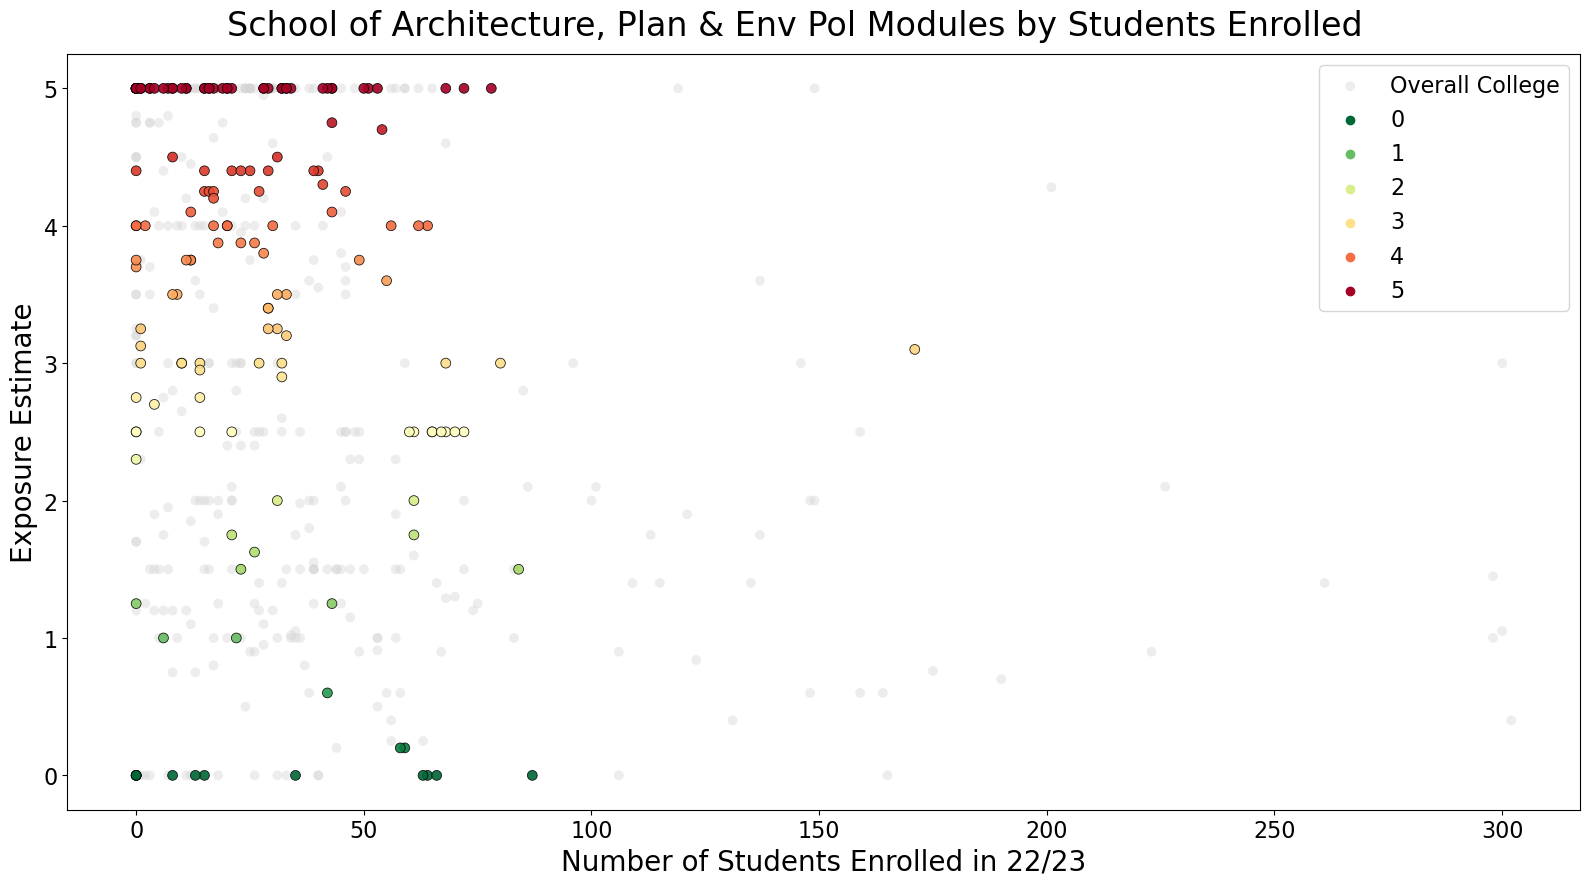

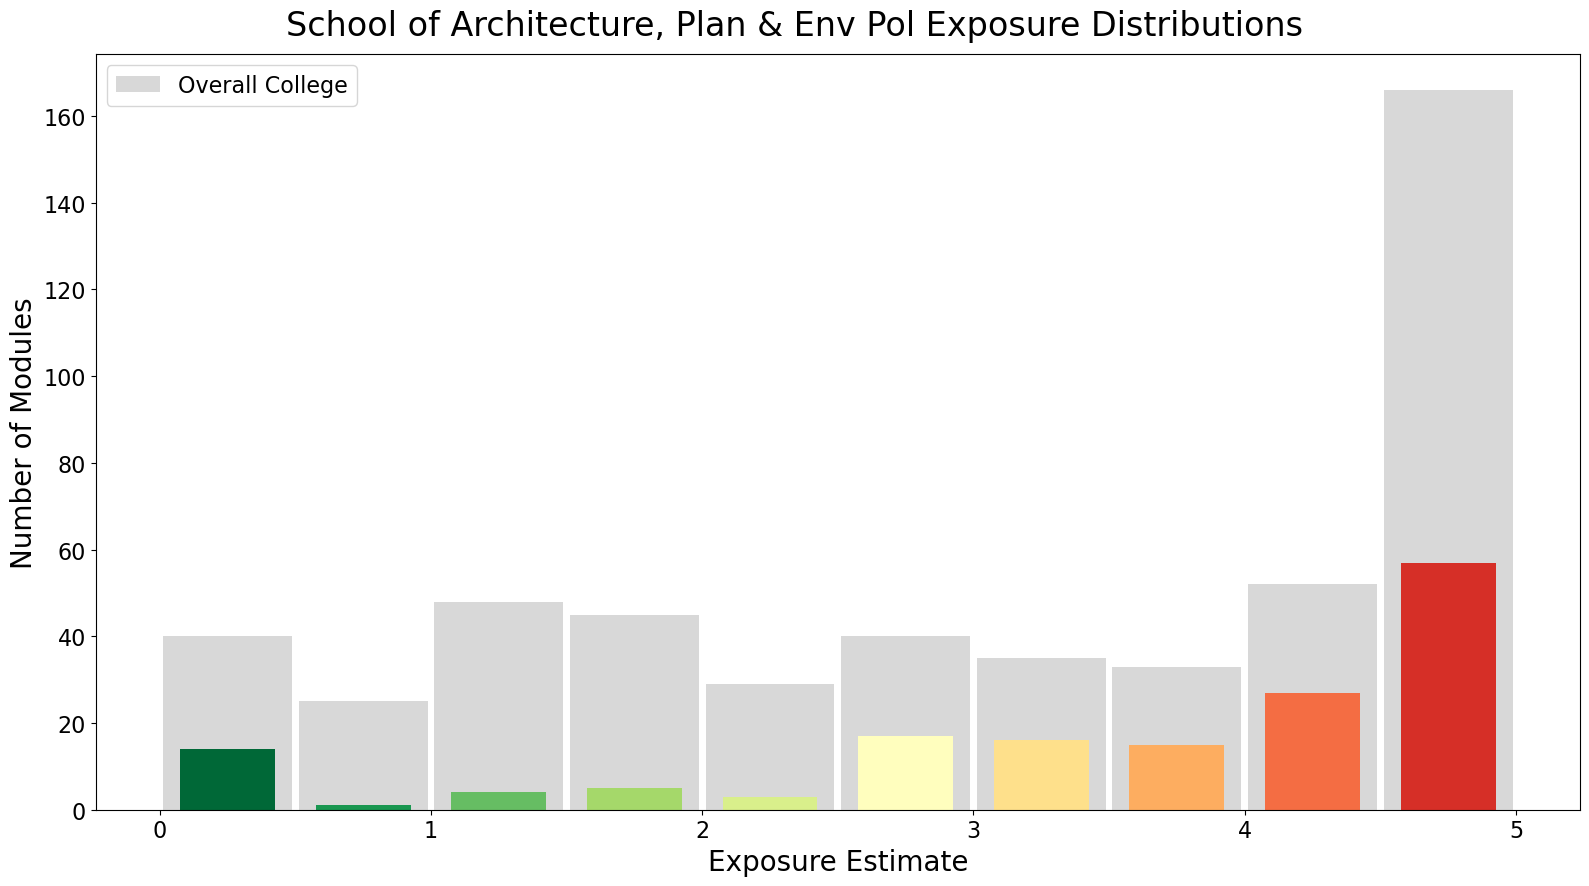

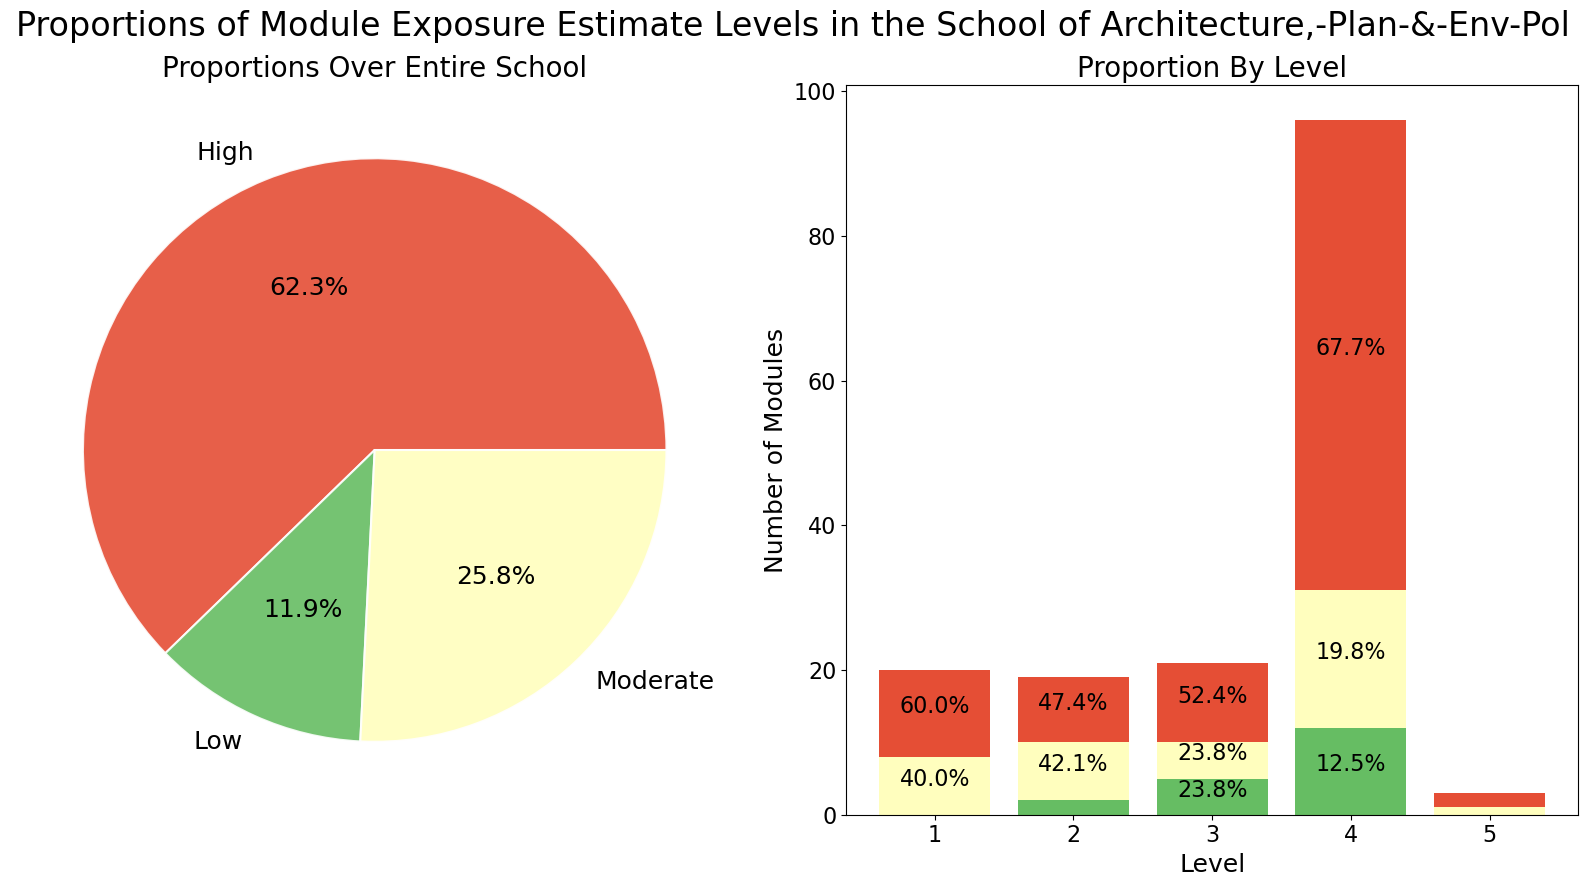

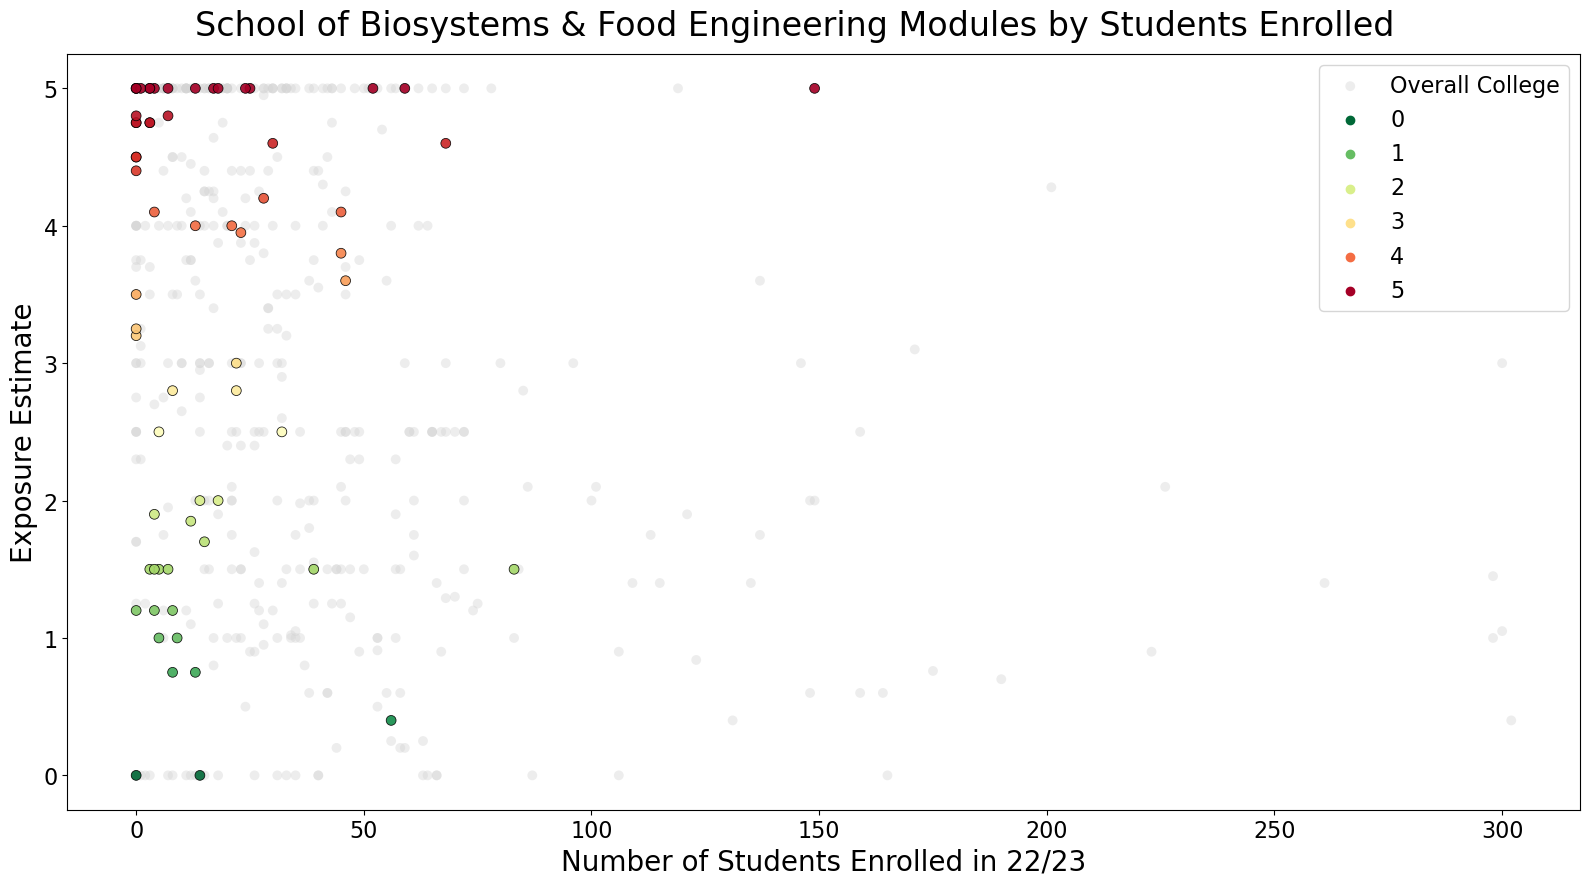

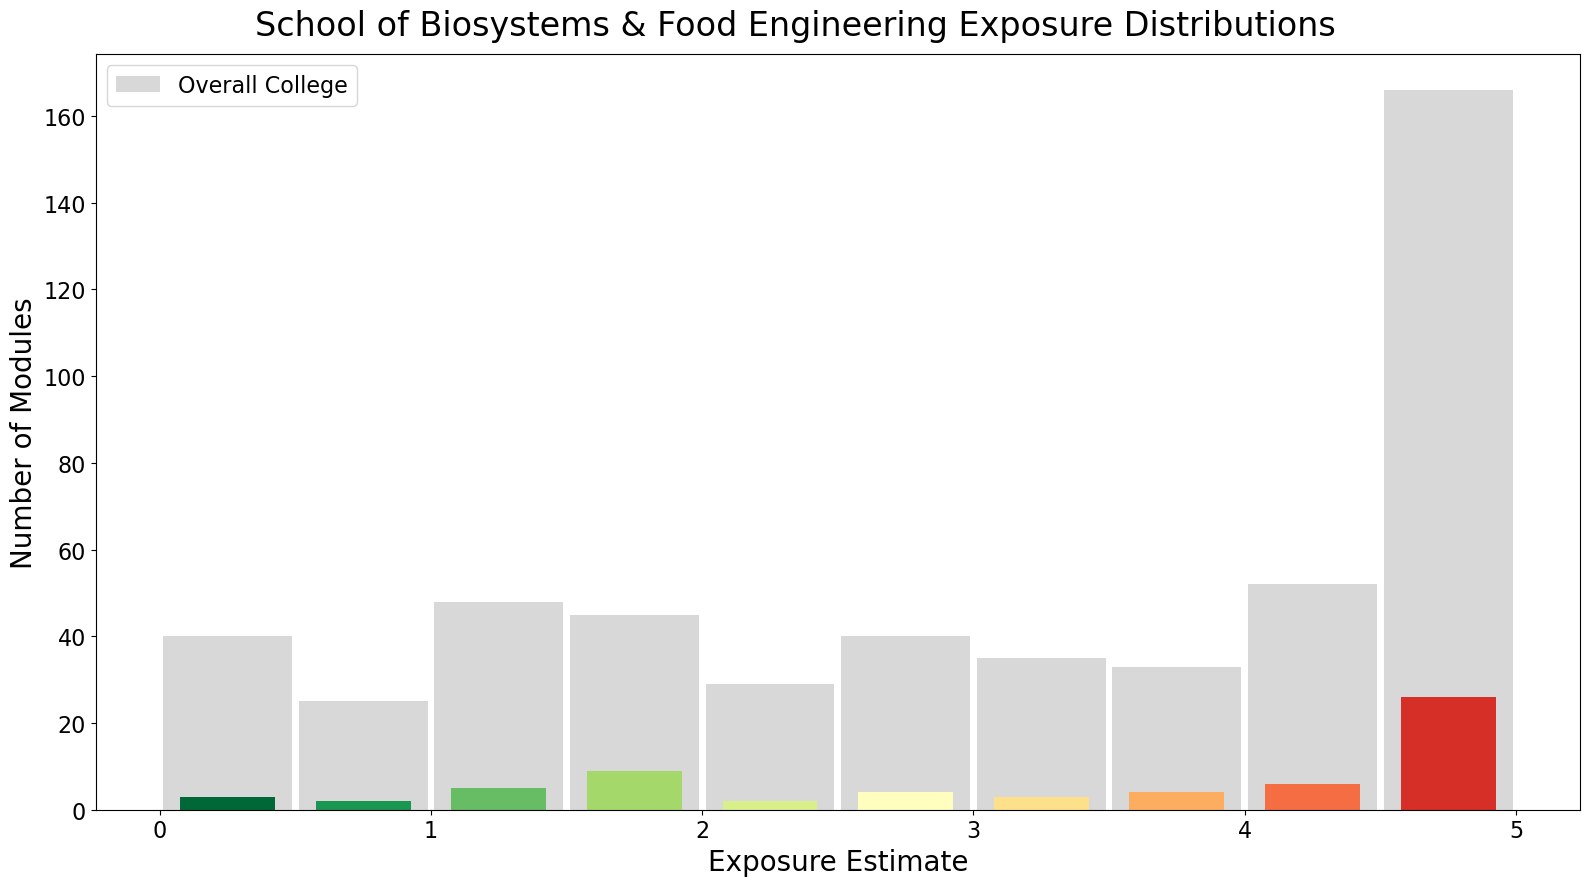

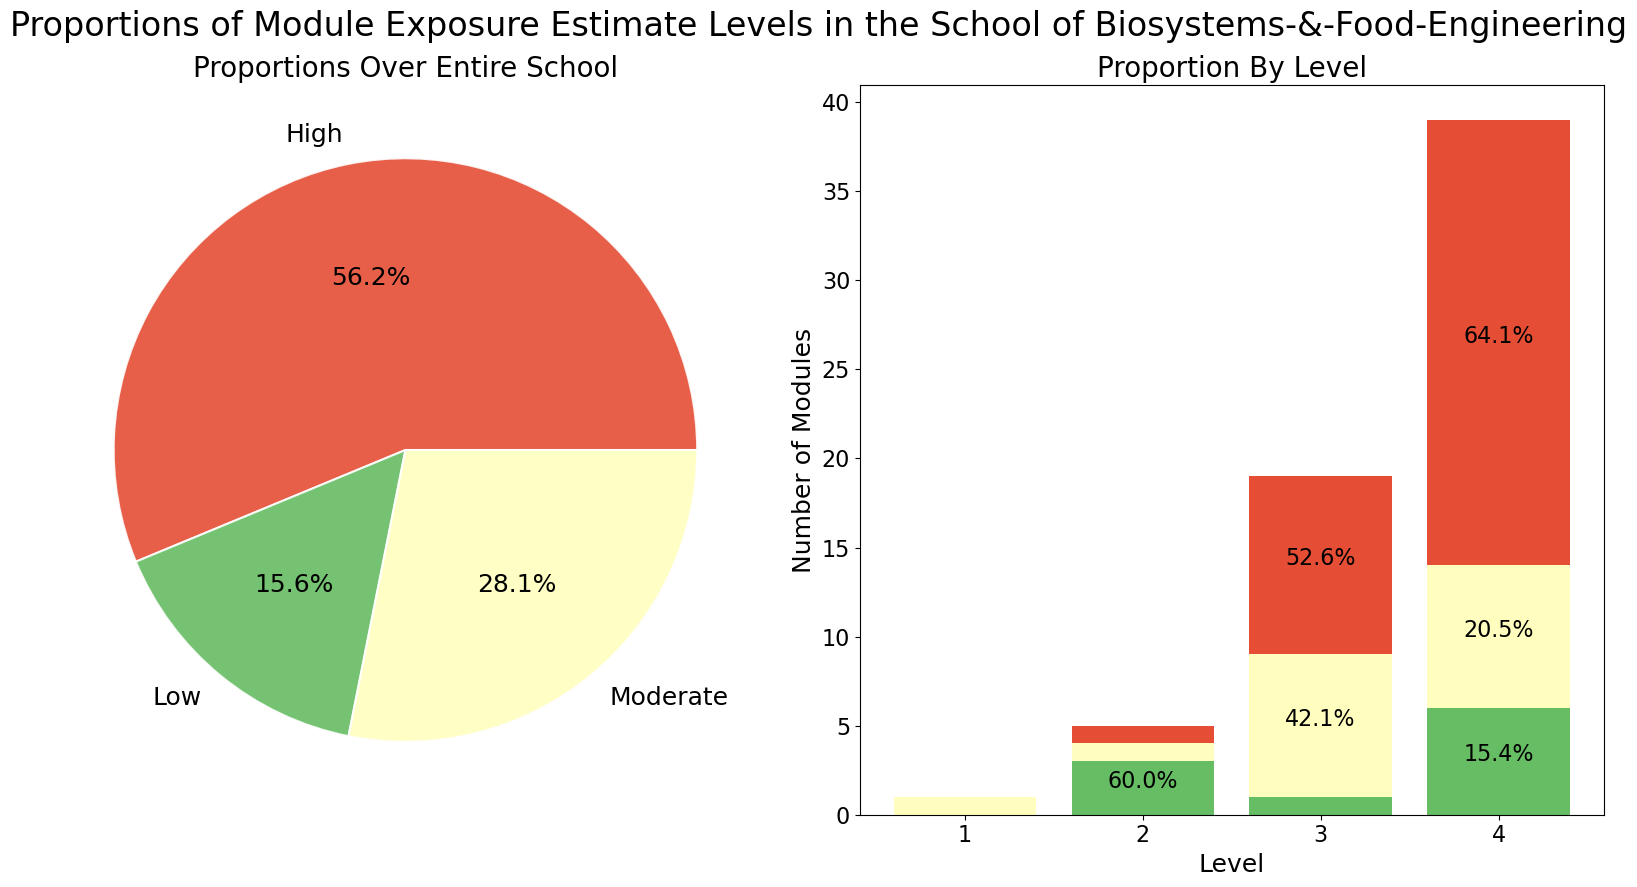

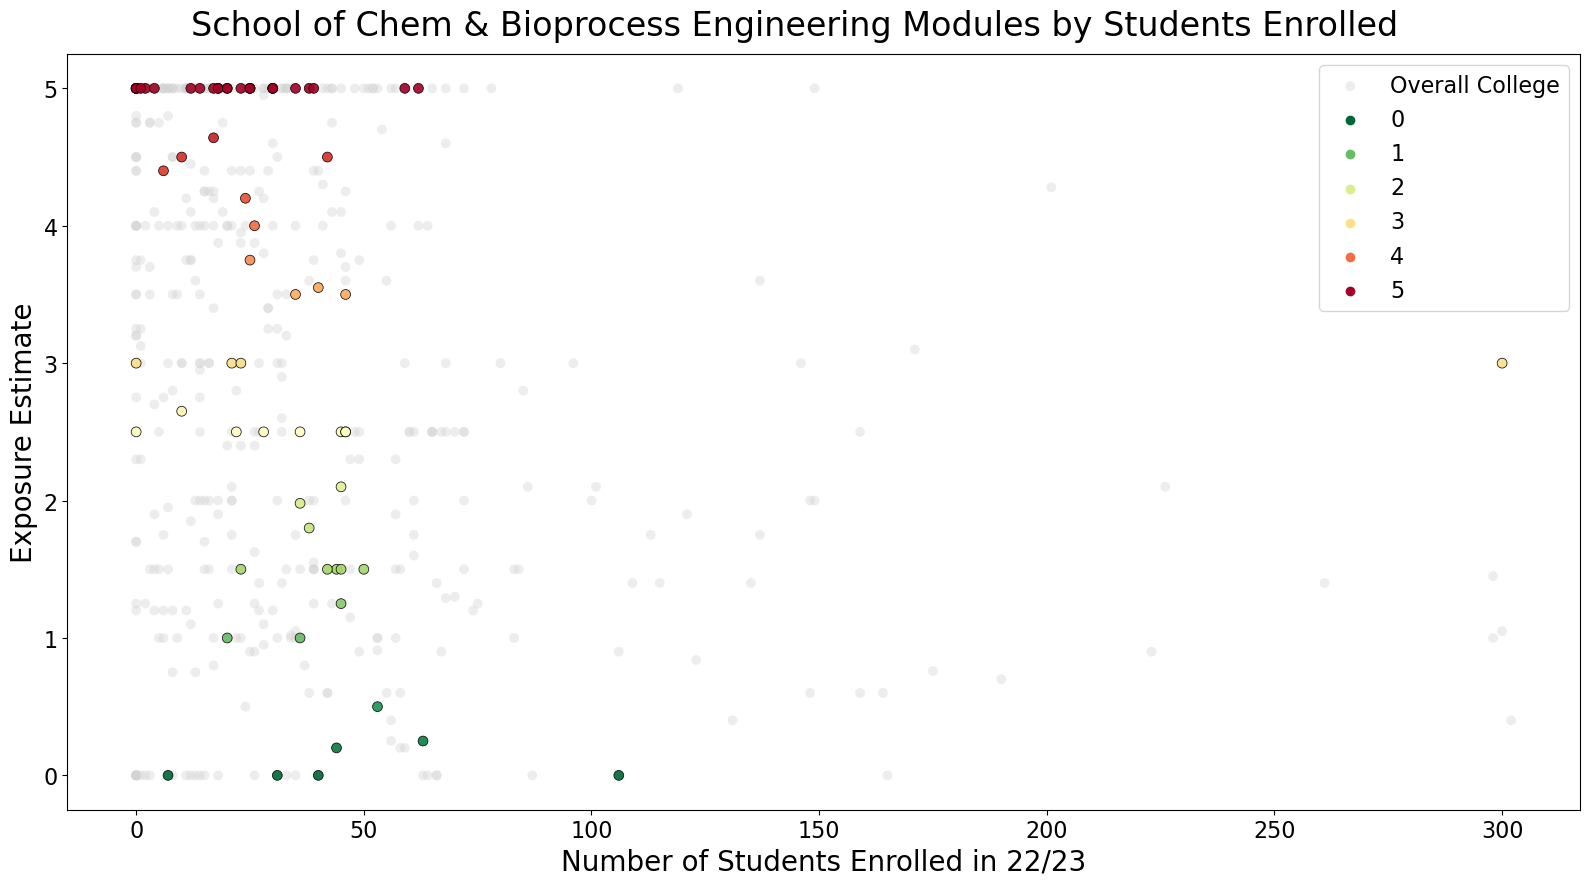

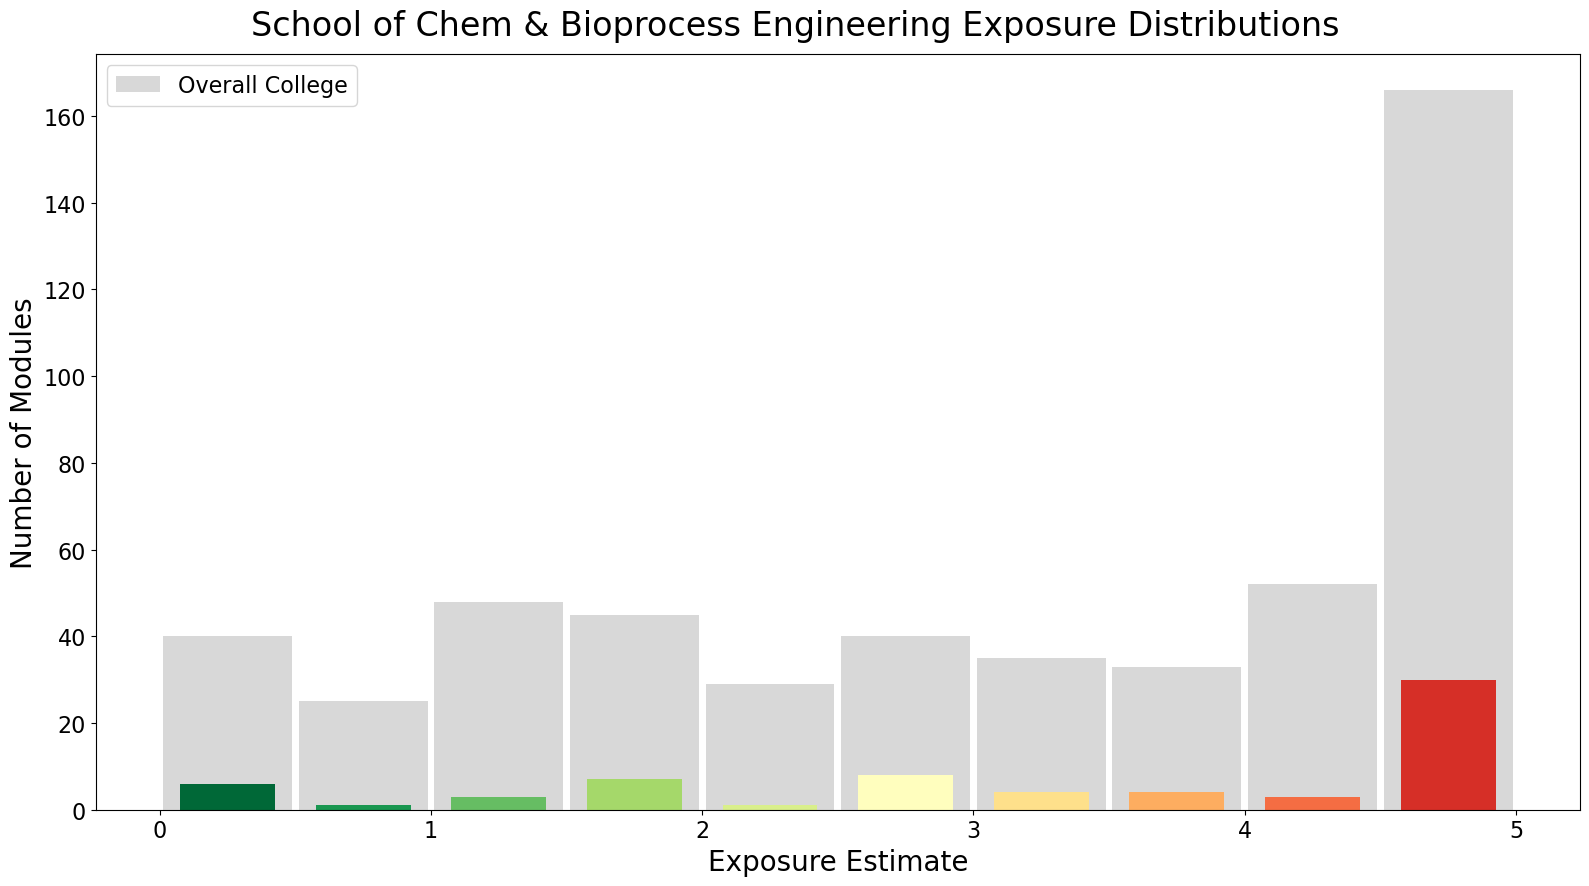

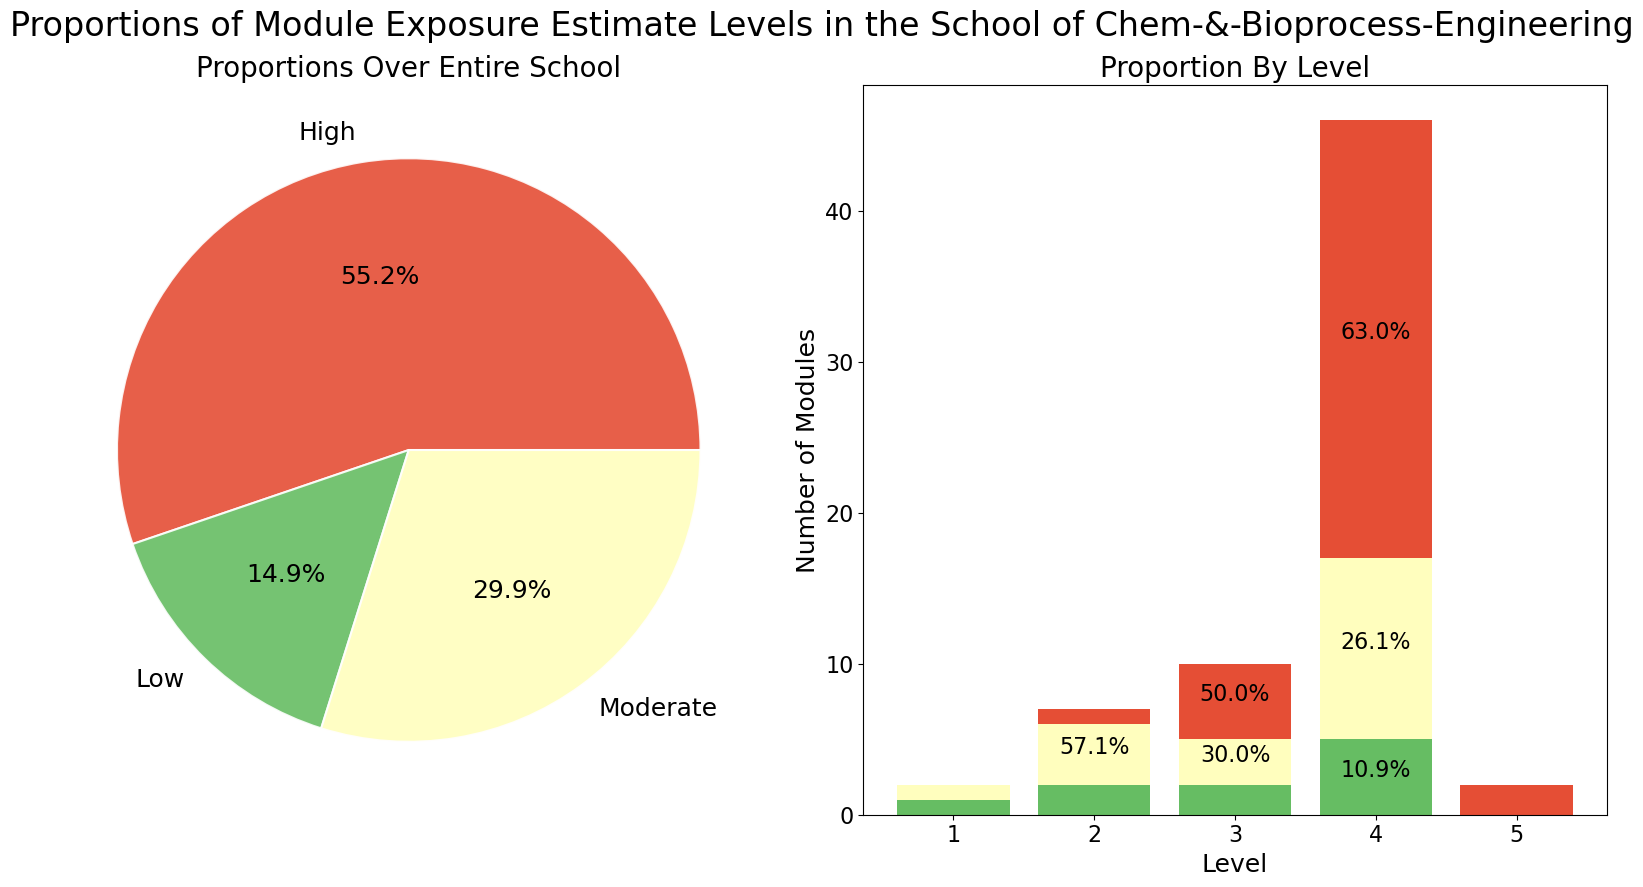

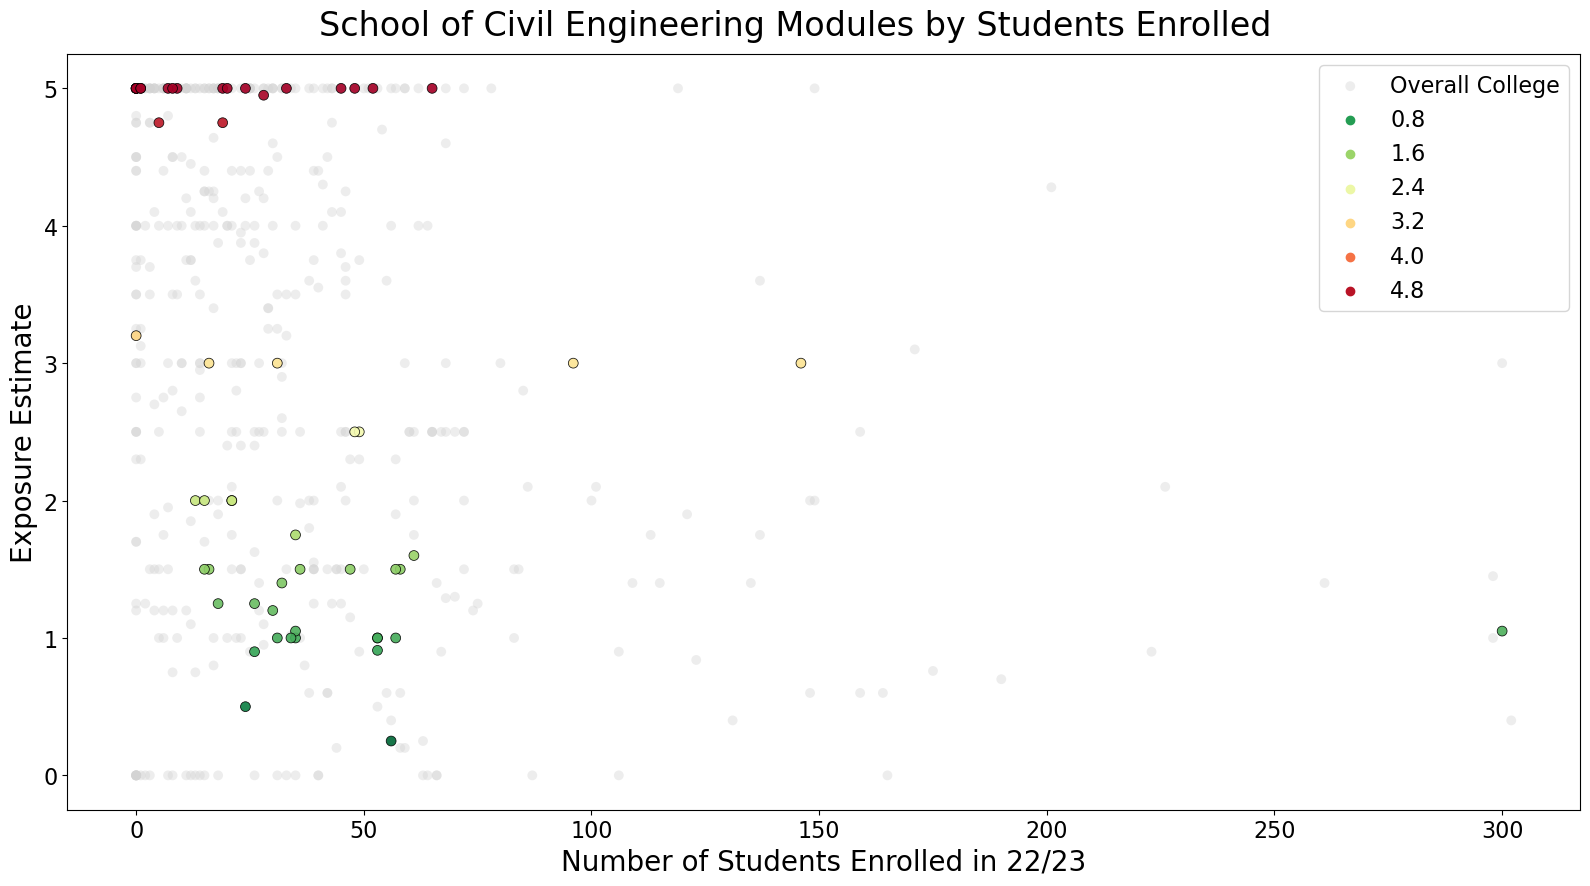

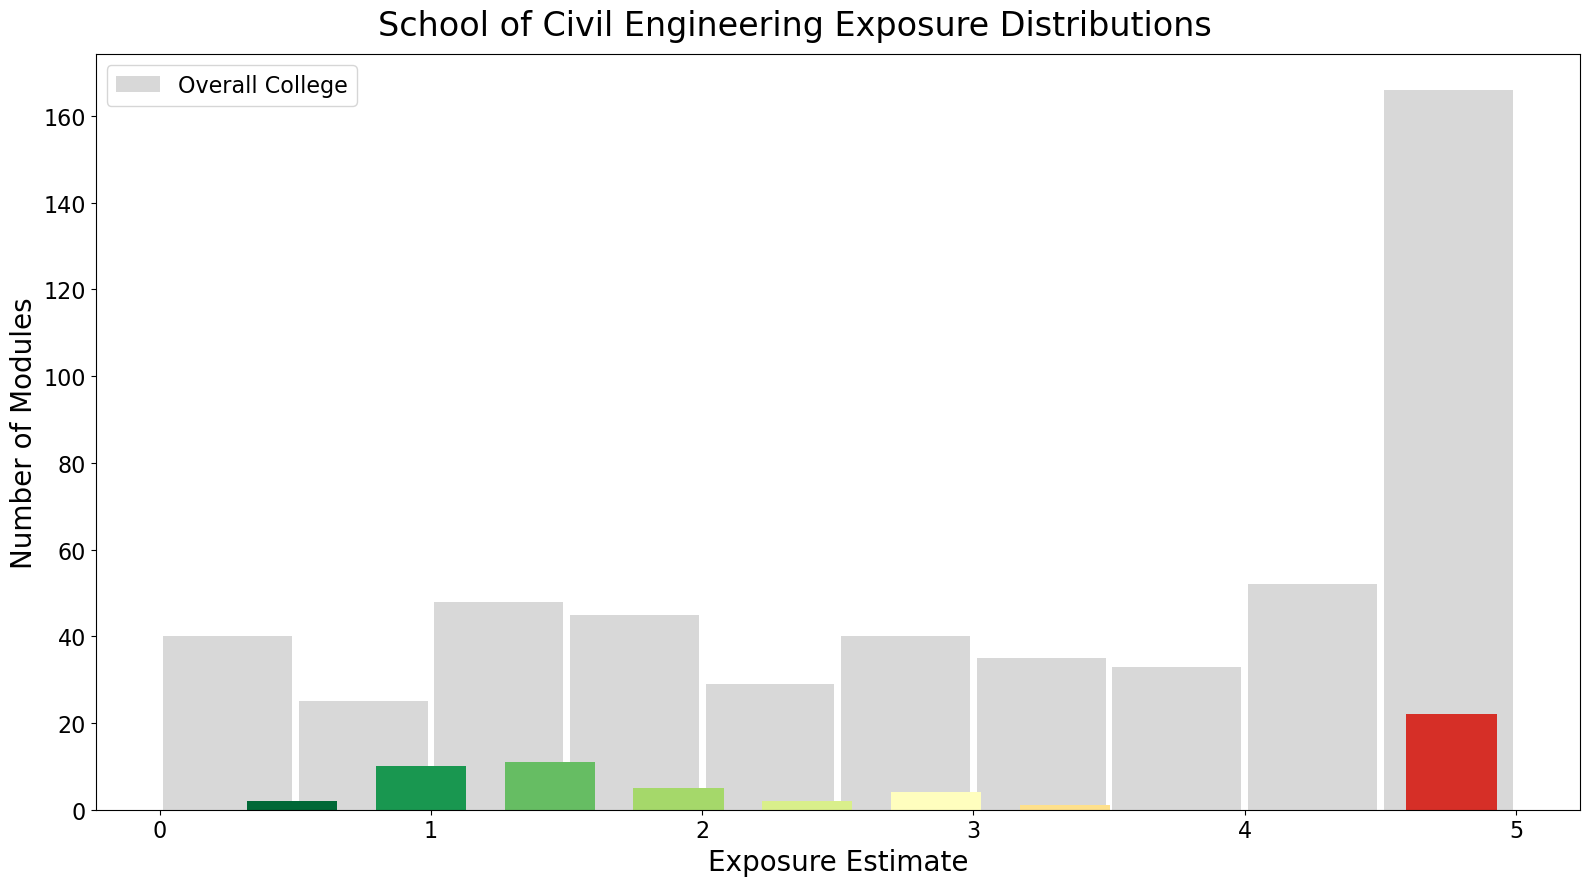

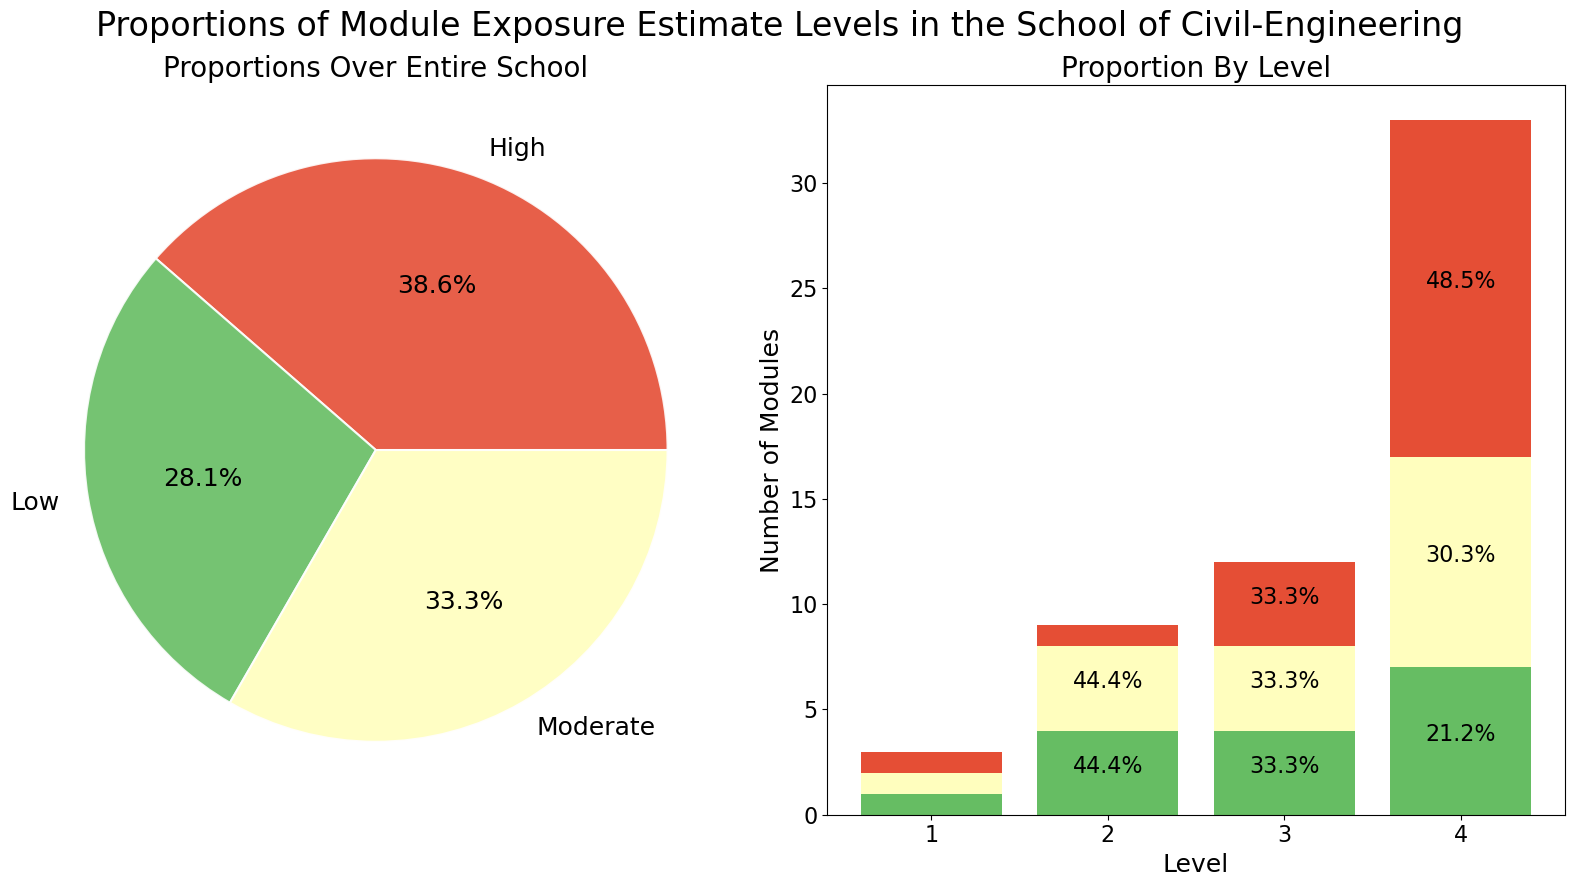

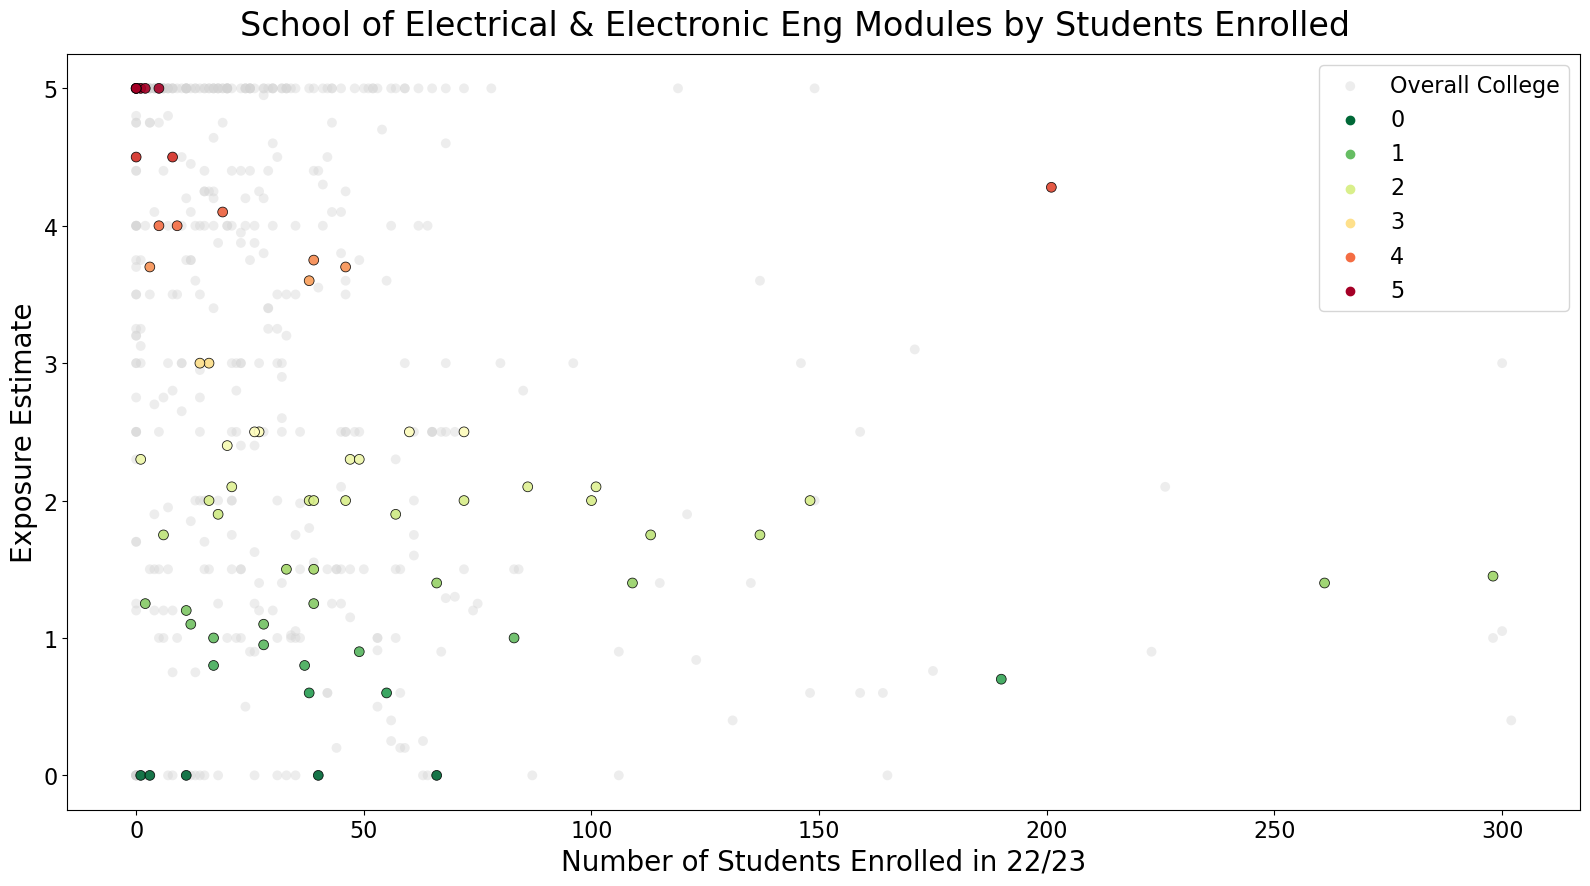

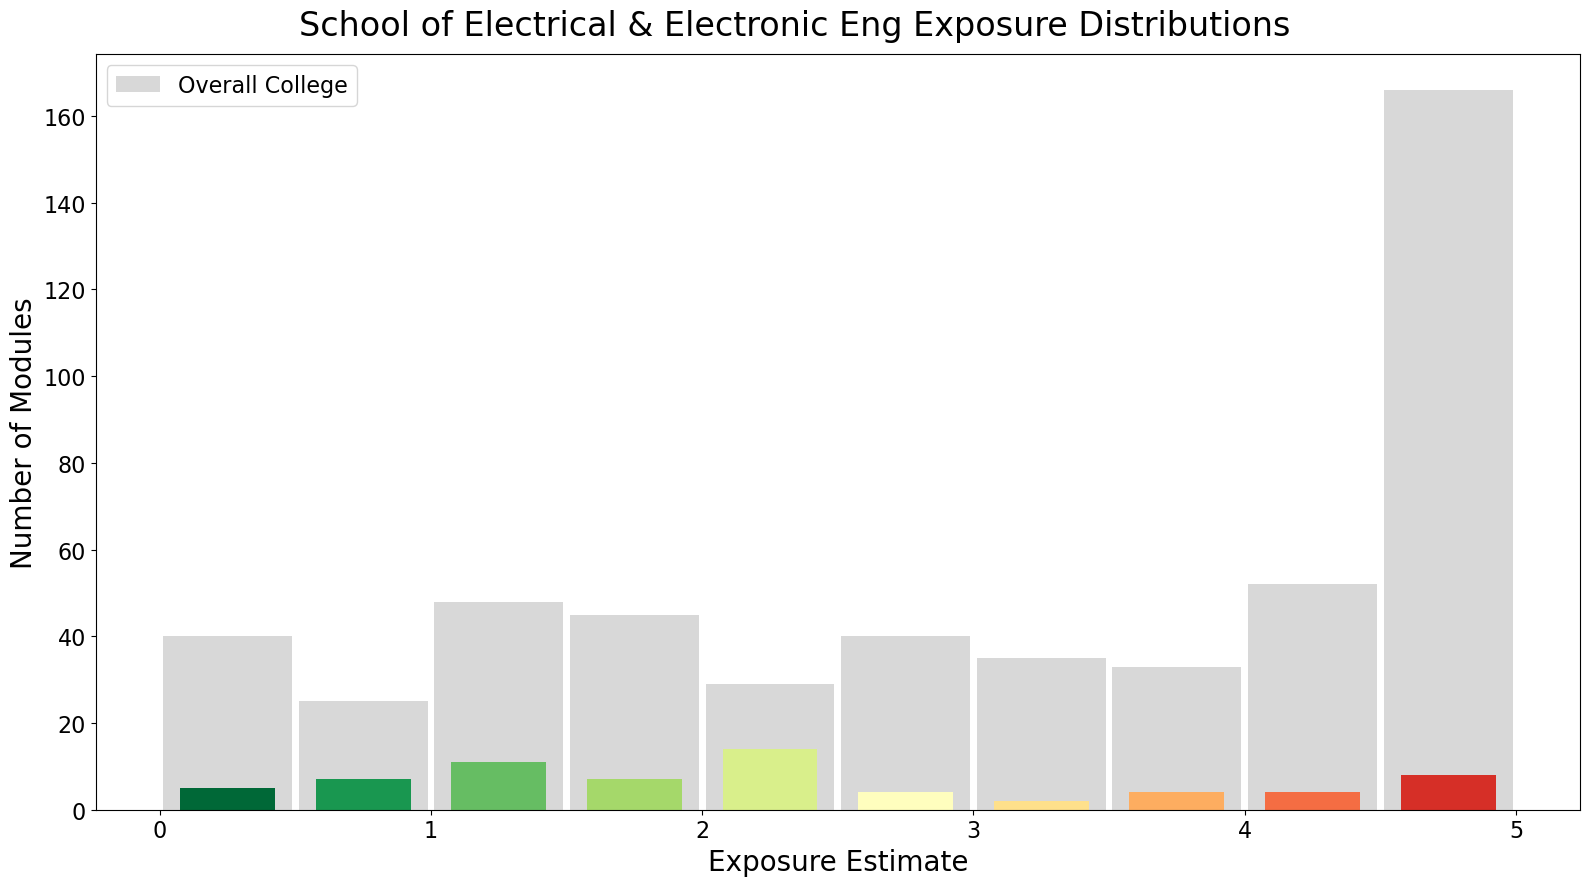

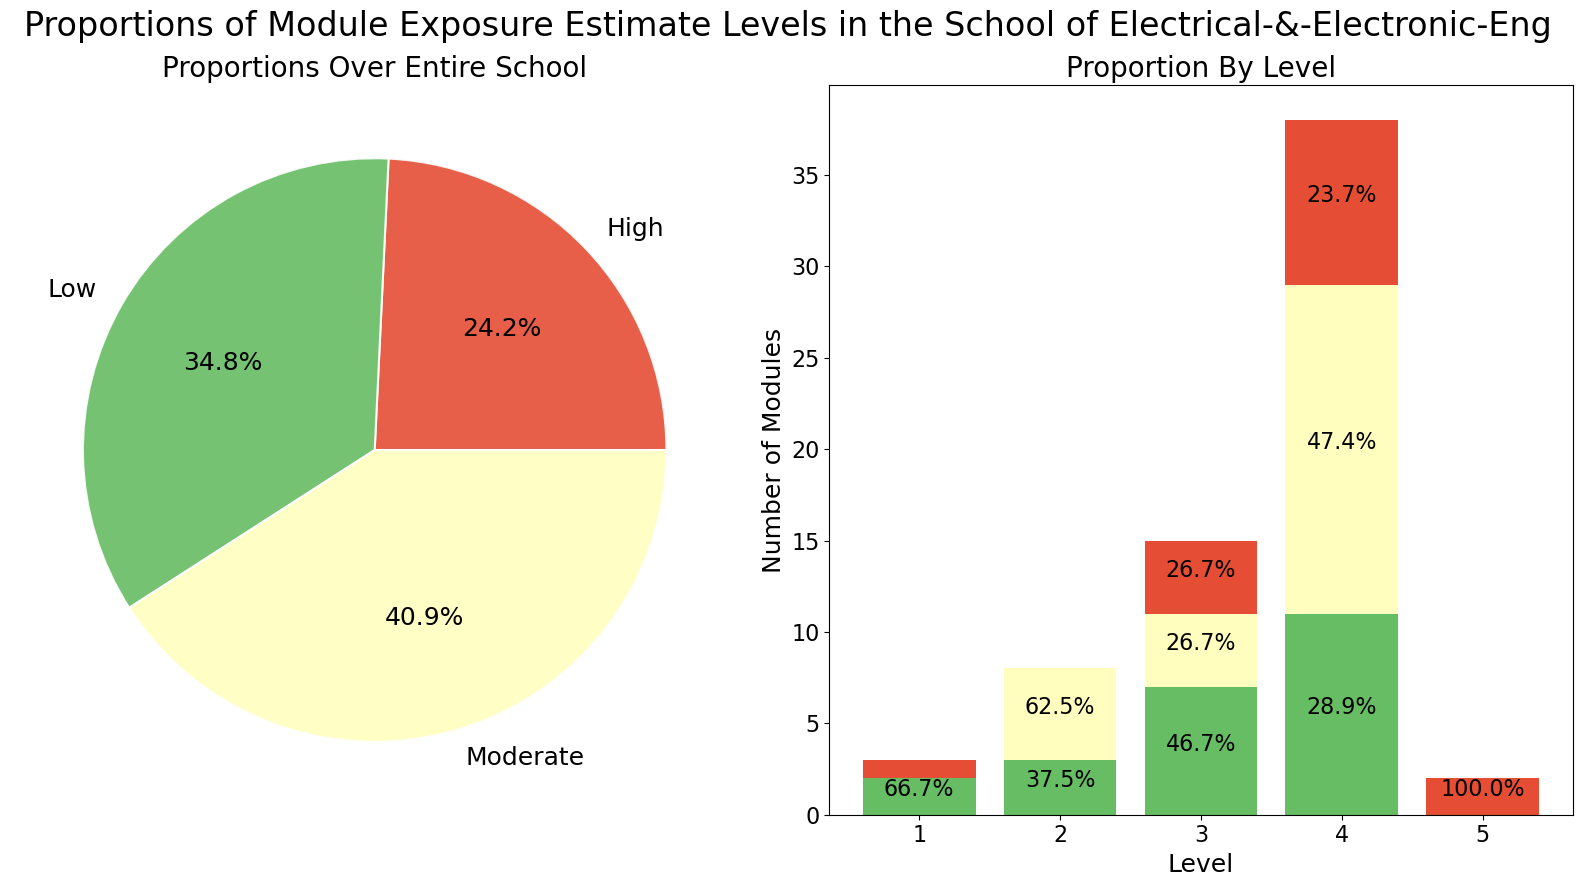

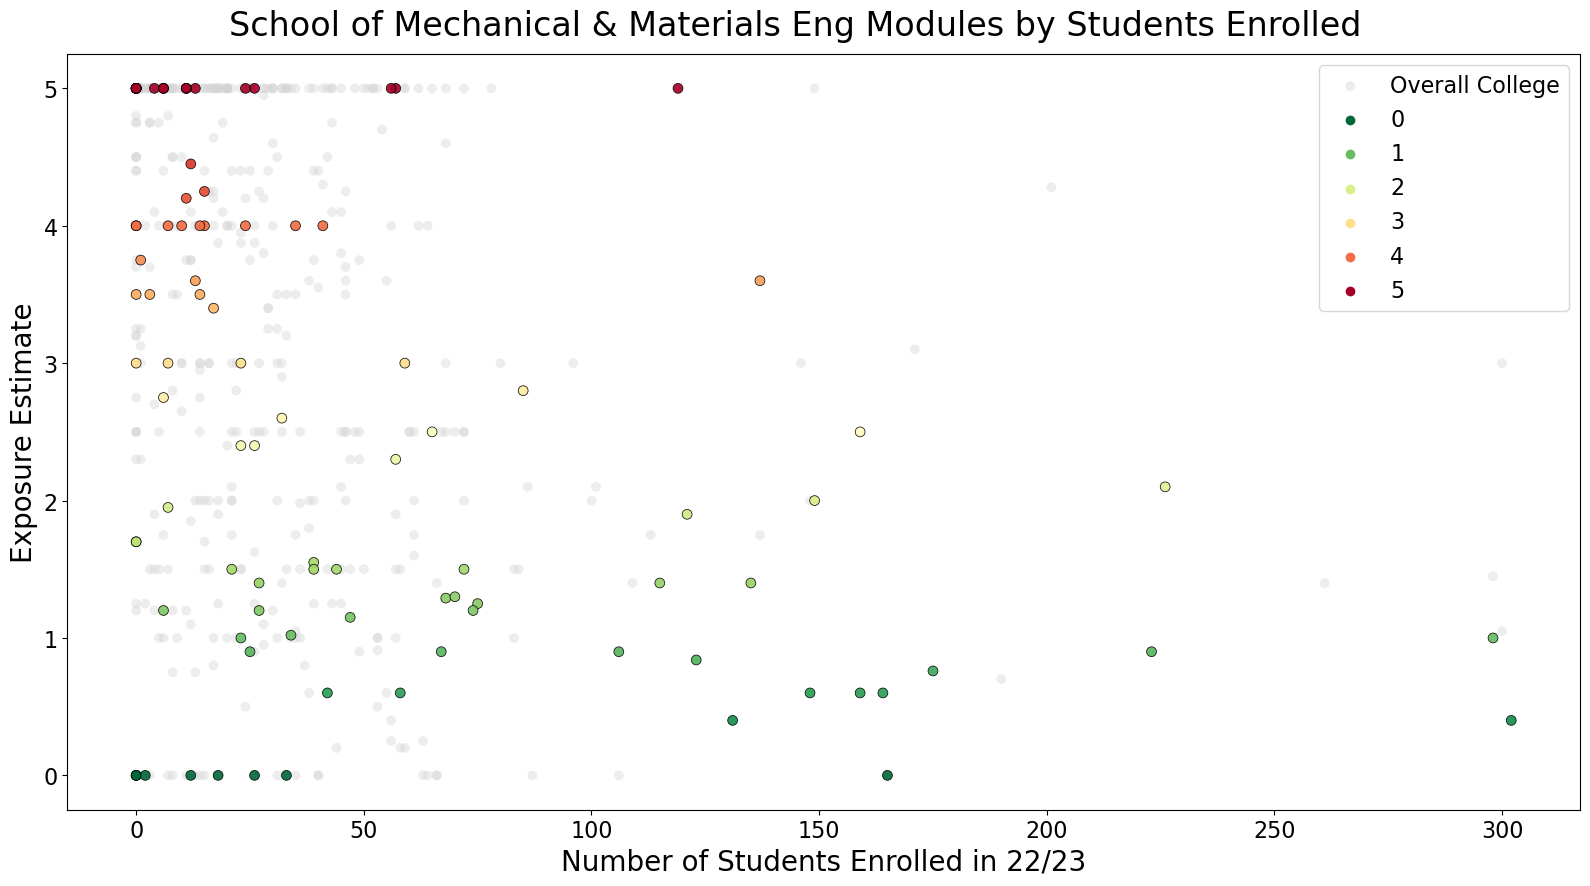

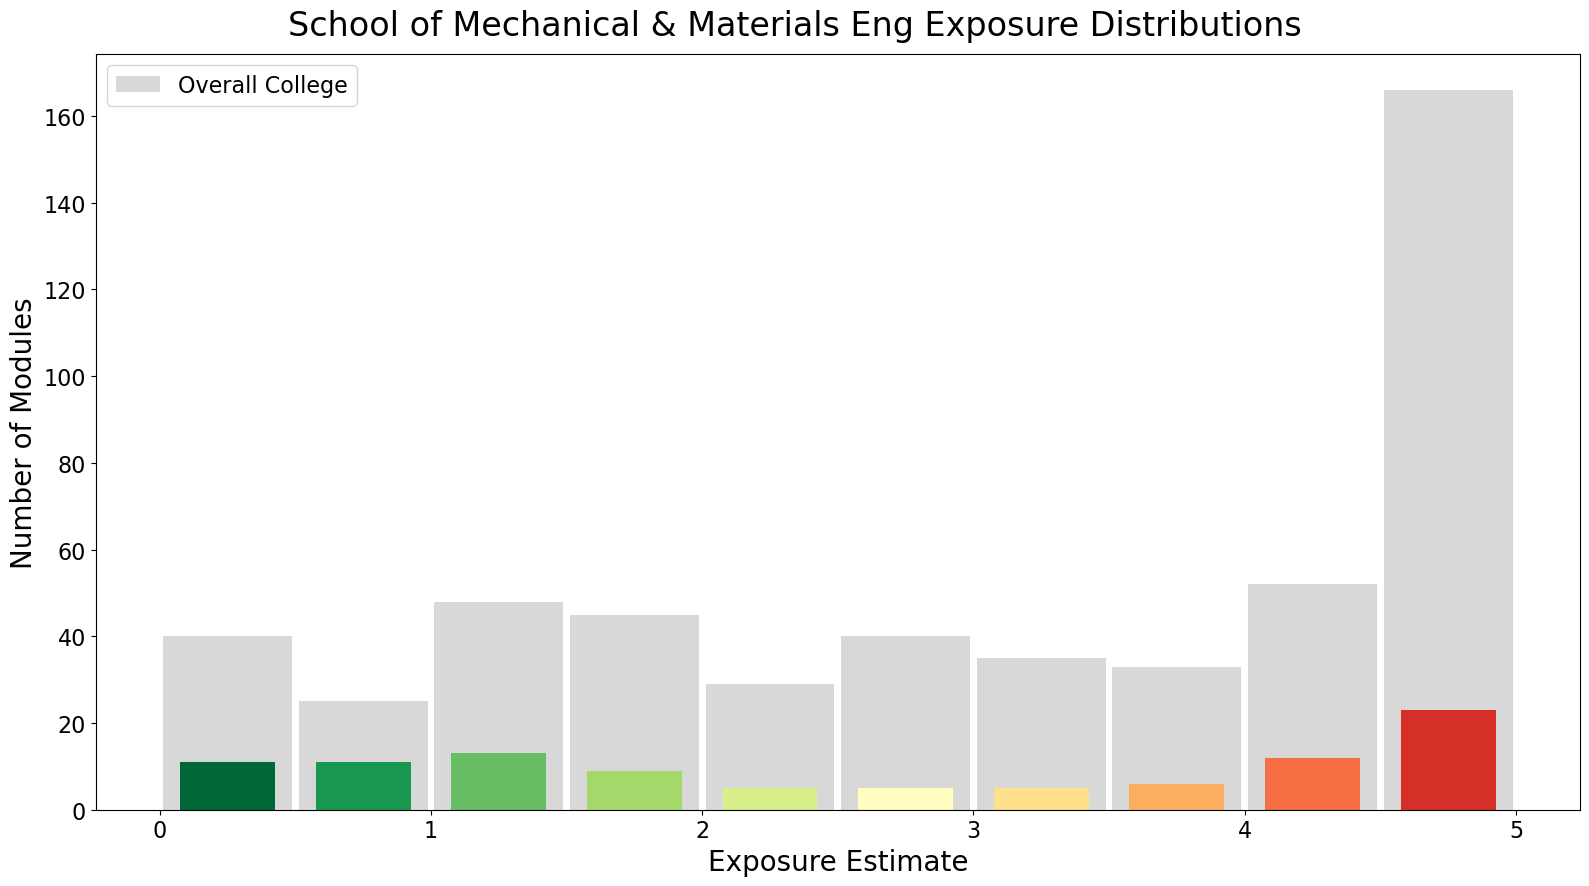

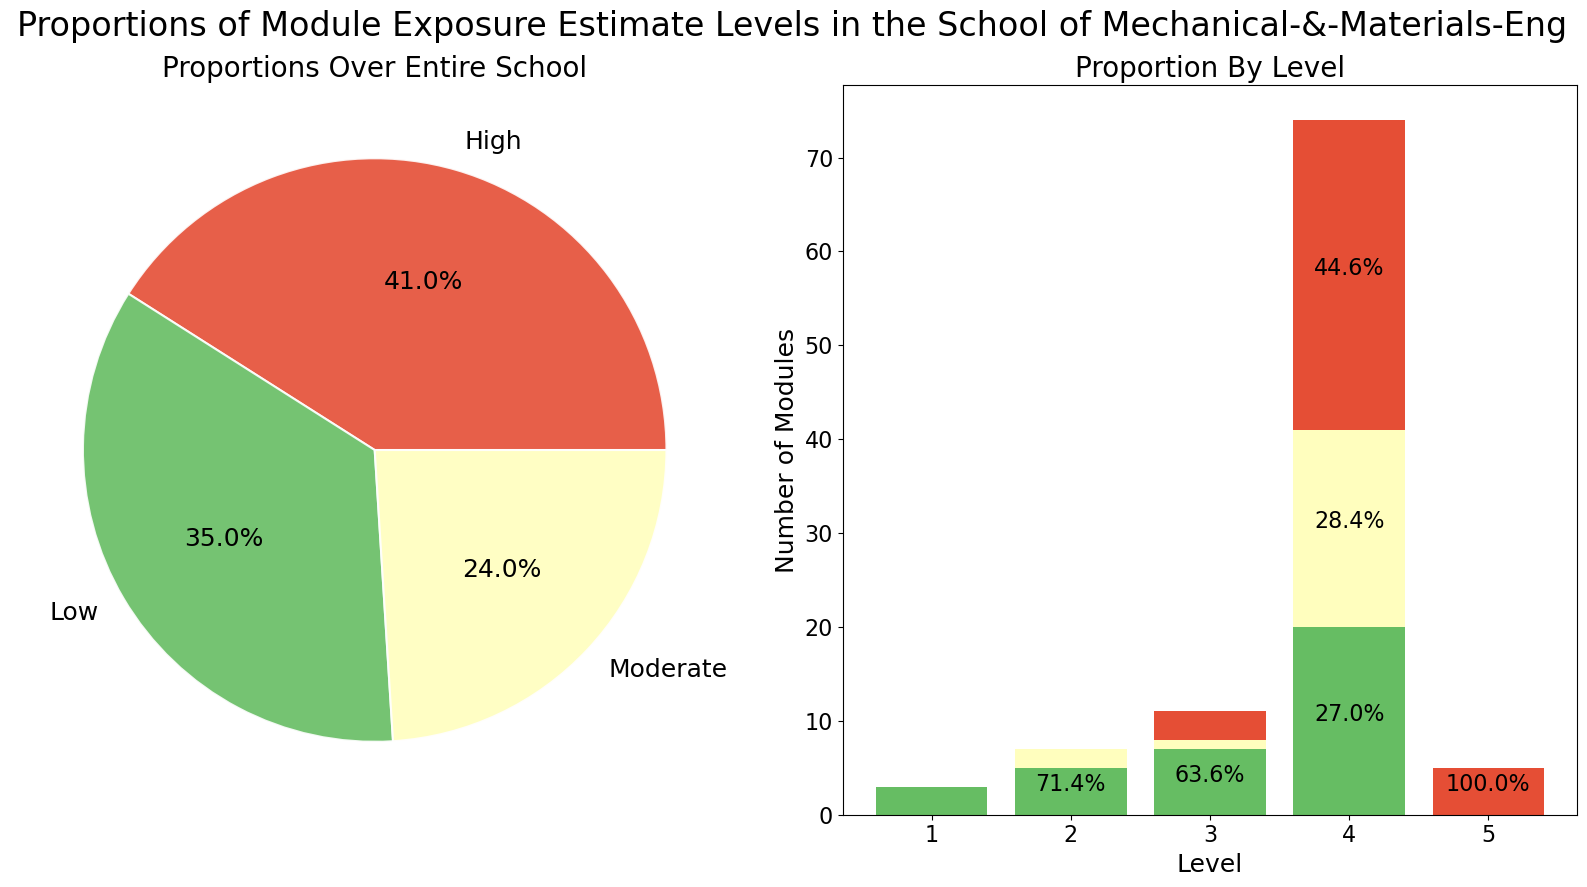

In [21]:
#Create a class for header and footers
class PDF(FPDF):
#Define a nice header for the module
    def header(self):
        #Set the logo
        self.image("UCDLogo.png", 10, 8, 20)
        #Set the font
        self.set_font('helvetica', 'B', 32)
        if school_page == True:
            #A bit of padding
            title_w=self.get_string_width(school ) + 6
            doc_w=self.w
            self.set_x((doc_w -title_w)/2)
            #Set the module code
            self.cell(title_w, 10, "%s" %school, ln=True, align='C')
            self.ln(5)
            
            self.set_font('helvetica', 'B', 24)
        
            #Add the module title
            title_w=self.get_string_width("School Overview Graphics") + 6
            doc_w=self.w
            self.set_x((doc_w -title_w)/2)
    
            self.cell(title_w, 10,"School Overview Graphics" ,0,1, align='C')
            self.ln(10)
        else:
            #A bit of padding
            title_w=self.get_string_width(m) + 6
            doc_w=self.w
            self.set_x((doc_w -title_w)/2)
            #Set the module code
            self.cell(title_w, 10, "%s" %m, ln=True, align='C')
            self.ln(5)
        
            self.set_font('helvetica', 'B', 24)
        
            #Add the module title
            title_w=self.get_string_width(title) + 6
            doc_w=self.w
            self.set_x((doc_w -title_w)/2)
    
            self.cell(title_w, 10,"%s" %(title),0,1, align='C')
            self.ln(10)
        
    #def details(self, details):
    def school_summaries(self, school):
        self.set_y(-180)
        school_scatter(school)
        self.image("Slides\RiskAssessment\%s\Scatter.png" %school.replace(" ", "-"), 37, 40, 130)
        school_dist(school)
        self.image("Slides\RiskAssessment\%s\Distribution.png" %school.replace(" ", "-"), 37, 115, 130 )
        school_proportions(school)
        self.image("Slides\RiskAssessment\%s\Proportions.png" %school.replace(" ", "-"), 27, 200, 150)
        
    def breakdown(self, df):
        self.set_y(-180)
        self.image("Graphs\RiskAssessment\Modules\%s.png" %m, 5, 77, 200)
        if len(df) < 5 :
            self.image("Graphs\WorkType\Modules\%s.png" %m, 33, 195, 150)
        else:
            self.image("Graphs\WorkType\Modules\%s.png" %m, 33, 210, 140)
        self.image("Graphs\RiskAssessment\Tables\%s.png" %m, 1, 157, 200)
        
    #Define a footer for the page number we are on
    def footer(self):
        #self.set_y(-50)
        #Set the path to save the graphs
        #module_breakdown= dir_output / "WorkType" / "Modules" / ("%s.png" % m)
        
        #Set the position of the footer
        self.set_y(-15)
        #Set the font 
        self.set_font('helvetica', 'I', 8)
        #Set the colour to be grey
        self.set_text_color(169, 169, 169)
        #Do the cell with the page number
        self.cell(0, 10, "Page  %s" %self.page_no(), align='C')
        
import qrcode

    
def draw_as_table(df, module):
    height=1 +(len(df)/2)
    if height > 4:
        height=4
   # plt.rcParams["figure.autolayout"] = True
    fig, (ax, bx)= plt.subplots(ncols=2, figsize=(12, height), gridspec_kw={"width_ratios":[4, 1]})
    plt.rcParams["font.family"] = "sans"
    
    #We will set the colourmap we will use for the ratings
    cmaps = plt.cm.RdYlGn_r
    colours=[]
    #ratings=df["Exposure Estimate"].apply(lambda rating: cmaps(rating/5))
    df["Maximum Exposure"]=df["% of Final Grade"].apply(lambda x: x*.05)
    ratings=cmaps(df["Exposure Estimate"]/df["Maximum Exposure"]).tolist()
    #print(ratings)
    #ratings=ratings - df["Maximum Exposure"]
    
    #Go through the rows 
    for cell in range(len(df)):
        #Set the colours of the columns
        cell_colours=["white", "white", ratings[cell], "white"]
        #Append the row to the colours list
        colours.append(cell_colours)
        
    fig.patch.set_visible(False)
    table=ax.table(cellText=df.values,
                        colLabels=df.columns,
                        colColours=['lightblue']*len(df.columns),
                        colWidths=[0.4, 0.2, 0.2, 0.2],
                        cellColours=colours,
                        loc='upper left')
    table.auto_set_font_size(False)
    table.scale(1, 2)
    table.set_fontsize(12)
    ax.axis('tight')
    ax.axis('off')
    #ax.box(on=None)
    #fig.tight_layout()
    
    
    ############################################
    img = qrcode.make('https://hub.ucd.ie/usis/!W_HU_MENU.P_PUBLISH?p_tag=MODULE&MODULE=%s' %(module))
    #image=plt.imread('qr.svg')
    bx.imshow(img, origin='upper')
    #bx.axis("tight")
    bx.axis('off')
    
    fig.tight_layout()
    #The functionality to save the risk assessment graphics
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment"
    if module != None:
        dir_output=dir_output / "Tables"
        #what=module
        
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.png" %module)
    plt.savefig(filename, dpi=200)
    plt.close()

modules=assessments.sort_values(["School", "Level"])["Module Code"].unique()


i=0

prev_school="None"
school_page=True

for m in modules:
    ###########################################
    #Make the graphics that we will add into the pdf for the module
    #Make the work_type graphs
    print(m)
    workType_graphs(module=m)
    ############################################
    #Get the module details
    details=assessments[assessments["Module Code"]==m]
    
    #Calculate the rating 
    rating=details["Exposure Estimate"].sum()
    #print(details)
    #Make the risk colour and add it to the pdf
    risk_colour(m, rating)
    
    title=details["Module Title"].iloc[0]
    school=details["School"].iloc[0]
    credits=details["Credits"].iloc[0]
    level=details["Level"].iloc[0]
    students=details["Enrolled Students 22/23"].iloc[0]
    
    df=details[["Assessment Type", "% of Final Grade","Exposure Estimate"]]
    #df=df.rename({"% of Final Grade" : "% of Grade"})
    
    draw_as_table(df, m)
    
    ############################################
    if i==0:
        #Make the pdf report for the module
        pdf = PDF()
        #Make sure it doesn't repeat
        i=1
    
    if prev_school !=school:
        school_page=True
        pdf.add_page()
        pdf.school_summaries(school)
        prev_school=school
        school_page=False
        
    #Set the title to the Module Code
    pdf.add_page()
 
    pdf.set_font('helvetica', 'B', 24)
    
    #The first line of details
    pdf.set_font('helvetica', '', 11)
    
    pdf.cell(40,10, "SCHOOL: %s" %school)
    
    pdf.cell(80)
    pdf.cell(40, 10, "LEVEL: %s" %level, 0, 1)
    
    #The second line of details
    pdf.cell(40, 10, "CREDITS: %s" %credits)
    
    pdf.cell(80)
    pdf.cell(40, 10, "ENROLLED STUDENTS 22/23: %s" %students, 0, 1)
    pdf.ln(2)
    
    pdf.set_font('helvetica', 'UBI', 16)
    pdf.cell(30, 10, "RISK EXPOSURE TO LARGE LANGUAGE MODELS ESTIMATE:", 0, 1)
    
    pdf.set_font('helvetica', 'B', 12)
    pdf.ln(62)
    #pdf.cell(30, 10, "THIS IS A PLACEHOLDER")
    
    ################################################
    #Assessments Table
    pdf.set_font("helvetica", size=11)
    pdf.multi_cell(0, 5, "The Exposure Estimate was calculated by taking the assessments as listed on the UCD module page"+\
    " (Scan QR Code to see). Individual assessments exposure ratings were calculated based on " +\
                   "their percentage of the final grade and summed to get the overall module rating.")
    pdf.set_font("helvetica", 'BI', size=11)
    pdf.cell(0, 5, "\n***This is just an estimation of exposure, and may not be accurate. Discretion is advised***")

    pdf.breakdown(df)
    #####################################################
    
#Set the path to save the report
dir_output=Path.Path("Report")
#Set the filename for th figure
dir_output=dir_output / "AllModules"
dir_output.mkdir(parents=True, exist_ok=True)
filename= dir_output / "ModuleReport.pdf" 
    
pdf.output(filename)

## Risk Summary Graphs

In [22]:
module_risk=assessments[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
.groupby(by="Module Code").first()

modules=module_risk.join(module_details)

modules

,Exposure Estimate,% of Final Grade,Enrolled Students 22/23,School,Student Credits,Credits,Level,Module Title
Module Code,,,,,,,,
ARCT10010,2.50,100,72,"Architecture, Plan & Env Pol",1080.0,15.0,1,Architectural Design I
ARCT10020,2.50,100,61,"Architecture, Plan & Env Pol",915.0,15.0,1,Architectural Design II
ARCT10030,5.00,100,78,"Architecture, Plan & Env Pol",195.0,5.0,1,Architecture & its Environment
ARCT10040,1.75,100,61,"Architecture, Plan & Env Pol",122.0,5.0,1,Intro. to Building Envelope
ARCT10070,3.00,100,80,"Architecture, Plan & Env Pol",40.0,5.0,1,Survey Course 1
...,...,...,...,...,...,...,...,...
PLAN40340,5.00,100,10,"Architecture, Plan & Env Pol",50.0,5.0,4,Planning Environ & Public Pol
PLAN40350,5.00,100,8,"Architecture, Plan & Env Pol",48.0,10.0,4,Advanced GIS
PLAN40390,3.60,100,55,"Architecture, Plan & Env Pol",385.0,10.0,4,Sustainable Cities


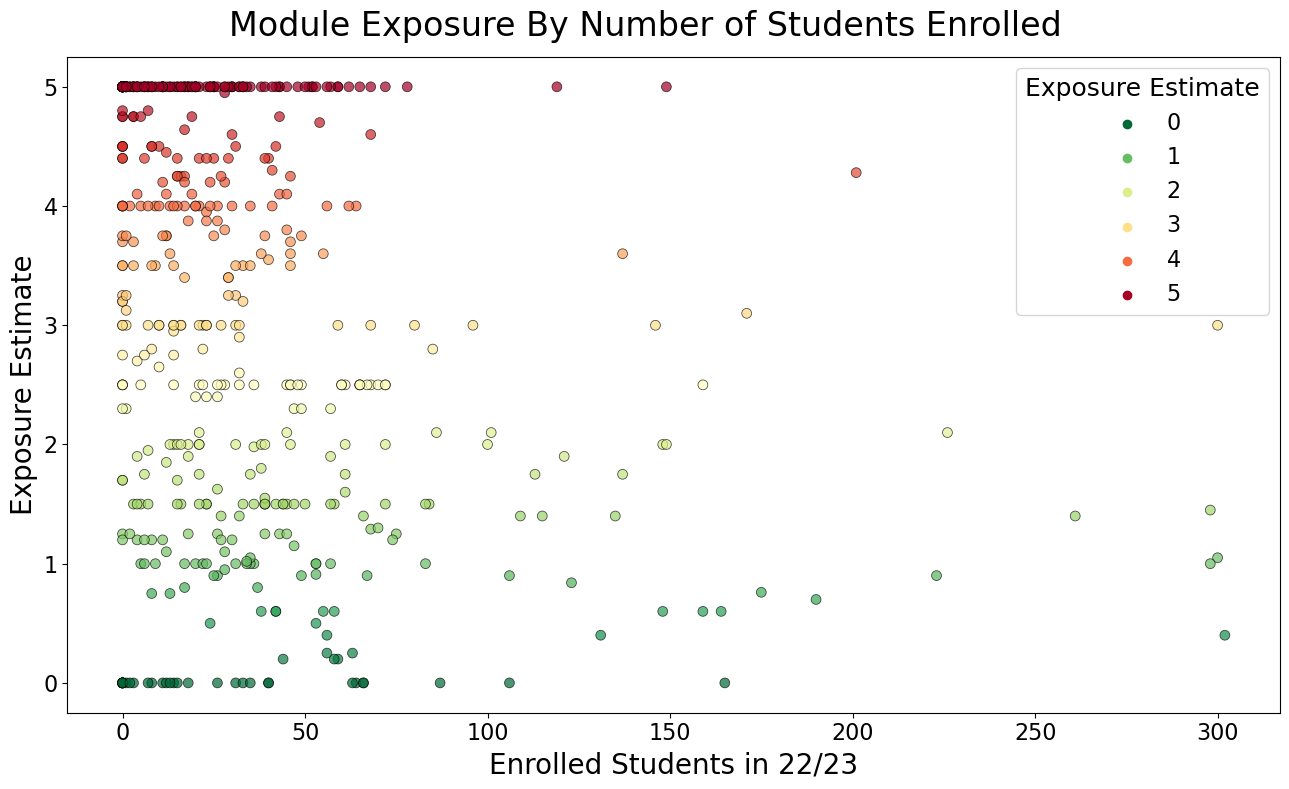

In [23]:
import seaborn as sns

fig=plt.figure(figsize=(13, 8))

sns.scatterplot(data=modules, x="Enrolled Students 22/23", y="Exposure Estimate",\
                hue="Exposure Estimate", palette=plt.cm.RdYlGn_r, s=50, edgecolor="black", alpha=0.7)

#Set the title
fig.suptitle("Module Exposure By Number of Students Enrolled", fontsize=24)

#Format the Axes
plt.ylabel("Exposure Estimate", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Enrolled Students in 22/23", fontsize=20)
plt.legend(title="Exposure Estimate", title_fontsize=18, fontsize=16)
fig.tight_layout()


#Set the path to save the graphs
dir_output=Path.Path("Graphs")
#Set the filename for th figure
dir_output=dir_output / "RiskAssessment" / "Summary"
dir_output.mkdir(parents=True, exist_ok=True)
filename= dir_output / ("ModulesScatter.png")
plt.savefig(filename, dpi=1200)

In [24]:
#These are the paths that exist in the College of Engineering and Architecture
paths=["CivilMastersPath", "MechanicalMastersPath", "BiomedMechanicalMastersPath", \
       "ChemicalEngineeringMastersPath", "ArchitecturePath", "ElectronicMastersPath",\
       "ElectricalMastersPath", "BiomedElectronicMastersPath", "BiomedMechanicalMastersPath",\
       "StructuralEngineerWithArchitectureMastersPath"]

paths_string={"CivilMastersPath": "Civil Masters", \
              "MechanicalMastersPath": "Mechanical Masters", \
              "BiomedMechanicalMastersPath": "Biomed Mechanical Masters", \
       "ChemicalEngineeringMastersPath" : "Chemical Masters", \
              "ArchitecturePath": "Architecture Path", \
              "ElectronicMastersPath": "Electronic Masters",\
       "ElectricalMastersPath": "Electrical Masters",\
              "BiomedElectronicMastersPath" : "Biomed Electronic Masters",\
             "StructuralEngineerWithArchitectureMastersPath": "Structural Engineer with Architecture Masters"}
lowest=10
highest=-5
path_total=0
path_count=0

all_paths=[]

path_high=None
path_low=None
path_rating={}

#Go through all the paths
for path in paths:
    #Get their module assessments
    assessment_info, descriptors=file_finder(filename=path)
    
    #Add in the risk rating
    assessment_info["Exposure Estimate"]=assessment_info["Assessment Type"].apply(lambda x: susceptibility[x])\
    *(assessment_info["% of Final Grade"]/100)
    
    #Manipulate the dataframe to get module risk ratings
    module_risk=assessment_info[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
    module_details=assessment_info[["Module Code", "Enrolled Students 22/23", "School", "Student Credits", "Credits"]]\
    .groupby(by="Module Code").first()

    #Join the two module information types, the numerical and the categorical
    path_ms=module_risk.join(module_details)
    
    #print(path_ms)
    
    #Get the path average
    path_avg=path_ms["Exposure Estimate"].mean()
    #Get the paths count and total
    path_total+=path_ms["Exposure Estimate"].sum()
    path_count+=len(path_ms)
    #Get a module holder by path
    path_ms["Path"]=paths_string[path]
    path_rating[path]=path_avg
    all_paths.append(path_ms)
    
    #Update if the path average is higher than the current highest
    if path_avg > highest:
        #Update the highest and save the school 
        highest=path_avg
        path_high=path
        
    #Repeat above but for the lowest
    if path_avg < lowest:
        lowest=path_avg
        path_low=path
        
print("The path with the lowest mean is %s with a mean of %0.2f" %(path_low, lowest))
print("The path with the highest mean is %s with a mean of %0.2f" %(path_high, highest))
print("The average rating across all paths is %0.2f" %(path_total/path_count))
print(path_count)

paths_df=pd.concat(all_paths, ignore_index=True)
print(len(paths_df))

print(paths_df["Path"].isna().sum())

for path in paths:
    print("The rating for %s is %0.2f" %(path, path_rating[path]))

Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\MechanicalMastersPath
Reading from ModuleInformation\MechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\ChemicalEngineeringMastersPath
Reading from ModuleInformation\ChemicalEngineeringMastersPath
Reading from ModuleInformation\ArchitecturePath
Reading from ModuleInformation\ArchitecturePath
Reading from ModuleInformation\ElectronicMastersPath
Reading from ModuleInformation\ElectronicMastersPath
Reading from ModuleInformation\ElectricalMastersPath
Reading from ModuleInformation\ElectricalMastersPath
Reading from ModuleInformation\BiomedElectronicMastersPath
Reading from ModuleInformation\BiomedElectronicMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from

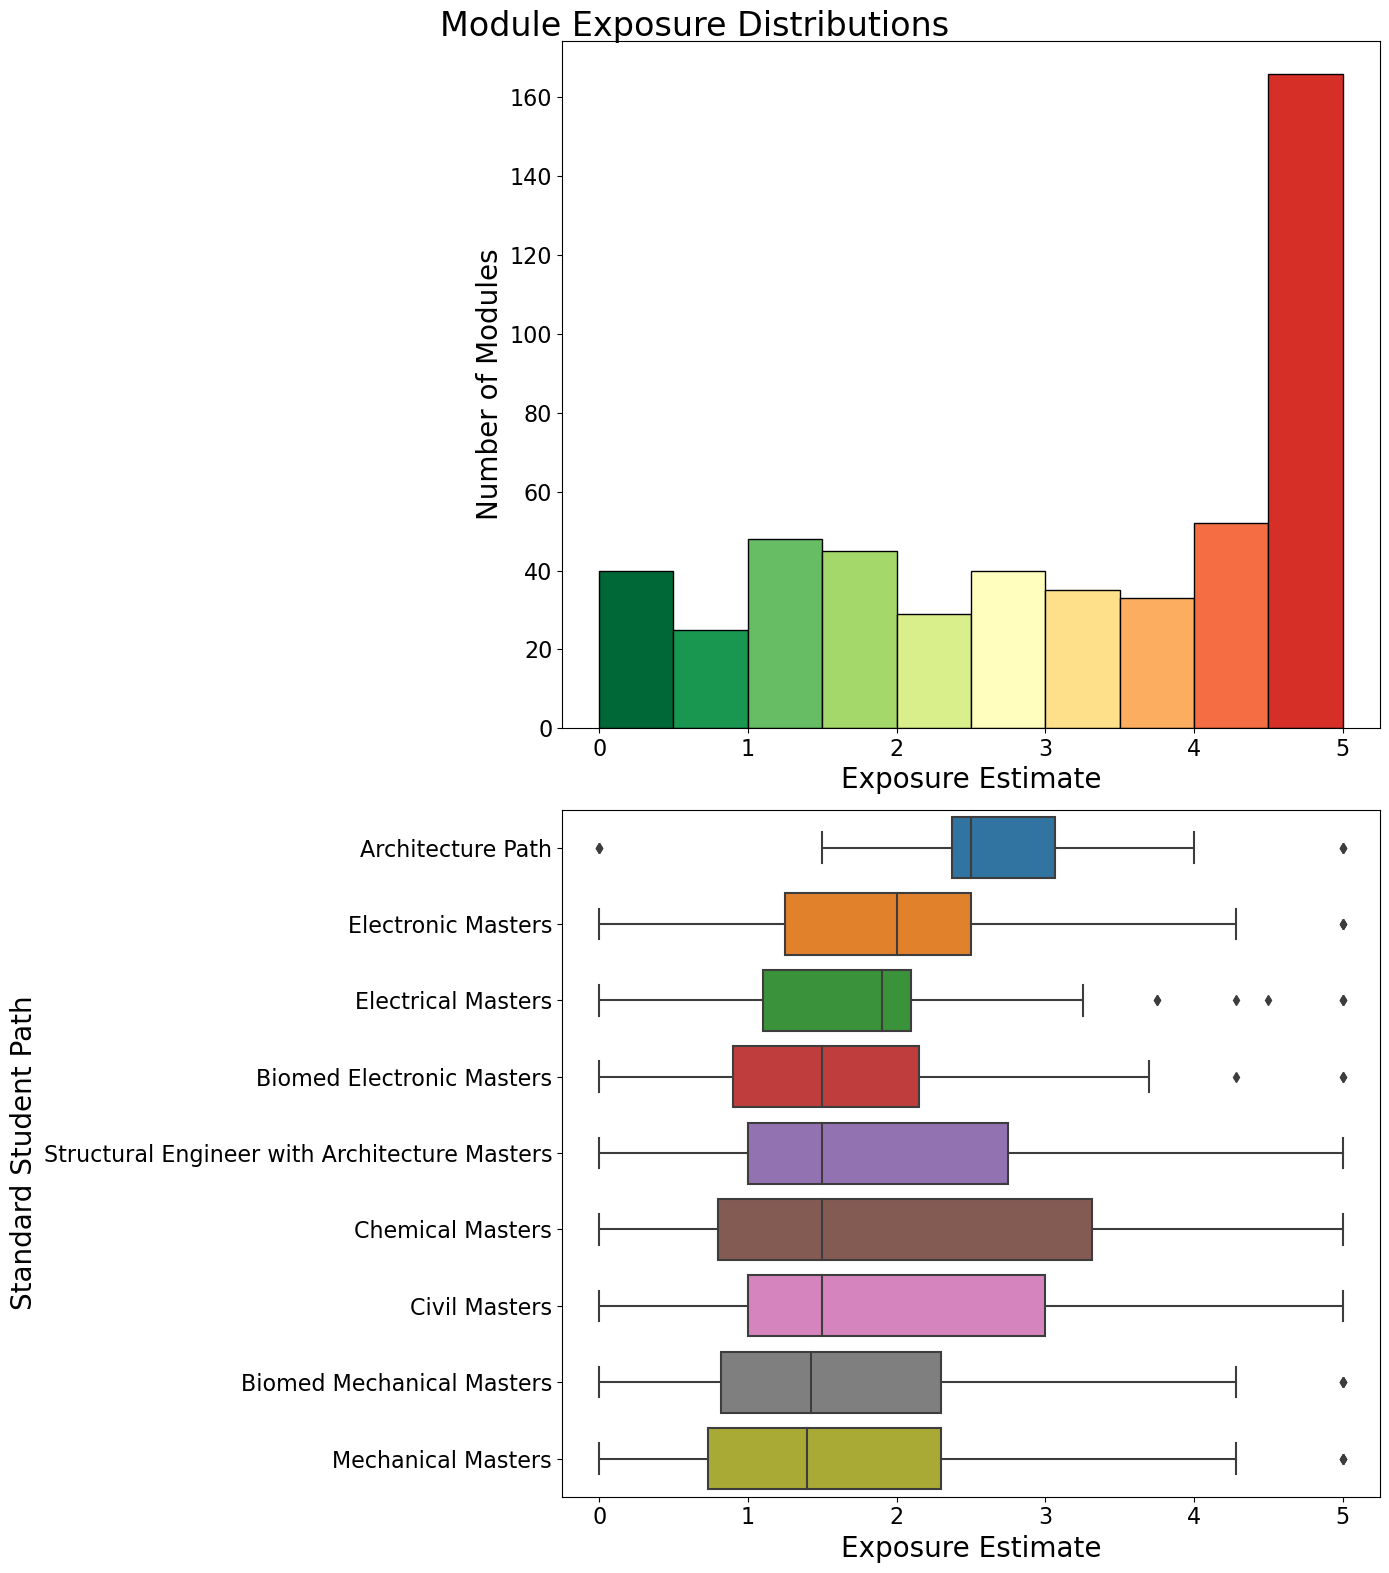

In [25]:
fig, (ax, bx)=plt.subplots(nrows=2, figsize=(14, 16))

plot=sns.histplot(data=modules, x="Exposure Estimate", \
             common_bins=True, ax=ax, bins=10)

for i, bin_ in enumerate(plot.patches):
    bin_.set_facecolor(plt.cm.RdYlGn_r((i/2)/5))
    
#Set the title
fig.suptitle("Module Exposure Distributions", fontsize=24)

#Format the Axes
ax.set_xlabel("Exposure Estimate", fontsize=20)
#ax.yticks(fontsize=16)
ax.set_ylabel("Number of Modules", fontsize=20)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
#ax.get_legend().remove()

##########
sns.boxplot(data=paths_df, x="Exposure Estimate", y="Path", ax=bx,
           order=["Architecture Path", "Electronic Masters", "Electrical Masters", "Biomed Electronic Masters",\
                  "Structural Engineer with Architecture Masters",\
                  "Chemical Masters", "Civil Masters", "Biomed Mechanical Masters", "Mechanical Masters" ])

bx.set_xlabel("Exposure Estimate", fontsize=20)
#ax.yticks(fontsize=16)
bx.set_ylabel("Standard Student Path", fontsize=20)
bx.tick_params(axis='y', labelsize=16)
bx.tick_params(axis='x', labelsize=16)

fig.tight_layout()

#Set the path to save the graphs
dir_output=Path.Path("Graphs")
#Set the filename for th figure
dir_output=dir_output / "RiskAssessment" / "Summary"
dir_output.mkdir(parents=True, exist_ok=True)
filename= dir_output / ("Distibution.png")
plt.savefig(filename, dpi=1200)

In [26]:
print("Mean : %0.2f\n Mode : %0.2f\n Median : %0.2f" \
      %(modules["Exposure Estimate"].mean(), modules["Exposure Estimate"].mode(), modules["Exposure Estimate"].median()))

Mean : 3.08
 Mode : 5.00
 Median : 3.25


C:\Users\catha\AppData\Local\Temp\ipykernel_18012\3744374870.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Mean : %0.2f\n Mode : %0.2f\n Median : %0.2f" \


In [27]:
lowest=10
highest=-5

school_high=None
school_low=None

school_ratings={}

#Go through all the schools
for school in modules["School"].unique():
    #Only get the modules given by a certain school
    find=modules[modules["School"]==school]
    #Get the school average
    school_avg=find["Exposure Estimate"].mean()
    school_ratings[school]=school_avg
    
    #Update if the school average is higher than the current highest
    if school_avg > highest:
        #Update the highest and save the school 
        highest=school_avg
        school_high=school
        
    #Repeat above but for the lowest
    if school_avg < lowest:
        lowest=school_avg
        school_low=school
        
print("The school with the lowest mean is %s with a mean of %0.2f" %(school_low, lowest))
print("The school with the highest mean is %s with a mean of %0.2f" %(school_high, highest))

for school in modules["School"].unique():
    print("The rating for %s is %0.2f" %(school, school_ratings[school]))

The school with the lowest mean is Electrical & Electronic Eng with a mean of 2.22
The school with the highest mean is Architecture, Plan & Env Pol with a mean of 3.56
The rating for Architecture, Plan & Env Pol is 3.56
The rating for Biosystems & Food Engineering is 3.32
The rating for Chem & Bioprocess Engineering is 3.36
The rating for Civil Engineering is 2.91
The rating for Electrical & Electronic Eng is 2.22
The rating for Mechanical & Materials Eng is 2.65


In [28]:
from openpyxl.styles import PatternFill

#Set the columns we want
for_excel=modules[["Module Title", "Exposure Estimate", "Enrolled Students 22/23", "School", "Credits", "Level" ]]
#for_excel["Exposure Colour Rating"]=""

#We will set the colourmap we will use for the ratings
cmaps = plt.cm.RdYlGn_r

#def colour_cell(s):
#    rating=s
#    return ['background-color: %s' %cmaps(rating/5) if True]
    
#Apply the colour to the cell
#for_excel["Exposure Colour Rating"]=for_excel.style.apply({"Exposure Estimate" : lambda x:cmaps[x/5]})
for_excel=for_excel.style.background_gradient(subset=["Exposure Estimate"], cmap=cmaps, vmin=0, vmax=5)

for_excel.to_excel("Report.xlsx", index=True)

In [29]:
for_excel

,Module Title,Exposure Estimate,Enrolled Students 22/23,School,Credits,Level
Module Code,,,,,,
ARCT10010,Architectural Design I,2.500000,72,"Architecture, Plan & Env Pol",15.000000,1
ARCT10020,Architectural Design II,2.500000,61,"Architecture, Plan & Env Pol",15.000000,1
ARCT10030,Architecture & its Environment,5.000000,78,"Architecture, Plan & Env Pol",5.000000,1
ARCT10040,Intro. to Building Envelope,1.750000,61,"Architecture, Plan & Env Pol",5.000000,1
ARCT10070,Survey Course 1,3.000000,80,"Architecture, Plan & Env Pol",5.000000,1
ARCT10090,Perspectives on Architecture,2.000000,61,"Architecture, Plan & Env Pol",5.000000,1
ARCT10120,Into Practice,4.000000,64,"Architecture, Plan & Env Pol",5.000000,1
ARCT20010,Architectural Design IV,2.500000,65,"Architecture, Plan & Env Pol",15.000000,2
ARCT20020,The Indoor Environment,5.000000,68,"Architecture, Plan & Env Pol",5.000000,2


# School Summary Graphs